In [2]:
#import the libraries
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


/Users/sagargulabani/dev/ml-learning/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def show(tensor, ch=1, size = (28,28), num = 16):
    # tensor 128 X 784 ( we are going to process 128 images at a time, 784 for 28 * 28 images)
    data = tensor.detach().cpu().view(-1, ch, *size) # we are going to reshape 784 to (28 X 28), So -1 is whatever remains after that. so (128 X -1 X 28 X 28)
    grid = make_grid(data[:num], nrow=4).permute(1, 2, 0) # (16 X 1 X 28 X 28). Change the order of dimensions for matplotlib so it will become (28 X 28 X1)
    plt.imshow(grid)
    plt.show()



In [4]:
# setup of the main parameters and the hyperparameters

epochs = 500
cur_step = 0
info_step = 300 # show visually look of image created by generator, get information every 200 images.
mean_gen_loss = 0
mean_disc_loss = 0

z_dim = 64 # dimensionality of the noise vector given to generator.
lr = 0.00001
loss_func = nn.BCEWithLogitsLoss() # take values, apply sigmod function so values will be 0 and 1. After that it will apply Binary Cross Entropy. Make values more stable.
bs = 128 # send 128 images in every process. batch size.
device = 'mps'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), shuffle=True, batch_size=bs)

# number of steps (60000/128) = 469 steps



In [5]:
def genBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.BatchNorm1d(out),
        nn.ReLU(inplace=True)
    )

class Generator(nn.Module):
    def __init__(self, z_dim = 64, i_dim = 784, h_dim = 128):
        super().__init__()
        self.gen = nn.Sequential(
            genBlock(z_dim, h_dim), # enter as 64, exit as 128, basically 64 features are entering, and when you have 128 neurons, so for each neuron you get one data point so total 128 points in one vector. see image for example. in image there are 3 features and 2 neurons. each neuron has as many weights as the number of features.
            genBlock(h_dim, h_dim * 2),
            genBlock(h_dim *2, h_dim * 4),
            genBlock(h_dim *4, h_dim * 8),
            nn.Linear(h_dim * 8, i_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)
        


In [6]:
def gen_noise(number, z_dim):
    return torch.randn(number, z_dim).to(device=device)

In [7]:
## Discriminator

def discBlock(inp, out):
    return nn.Sequential(
        nn.Linear(inp, out),
        nn.LeakyReLU(0.2) # small negative value on certain slope so as to not kill those neurons.
    )

class Discriminator(nn.Module):
    def __init__(self, i_dim=784, h_dim = 256):
        super().__init__()
        self.disc=nn.Sequential(
            discBlock(i_dim, h_dim*4), # 784 to 1024
            discBlock(h_dim * 4, h_dim * 2), # 1024 to 512
            discBlock(h_dim * 2, h_dim), # 512 to 256
            nn.Linear(h_dim, 1)
        )
    
    def forward(self, image):
        return self.disc(image)

 

In [8]:
gen = Generator(z_dim=z_dim).to(device=device)

In [9]:
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)

disc = Discriminator().to(device=device)

disc_optimizer = torch.optim.Adam(disc.parameters(), lr=lr)

In [10]:
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [11]:
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [12]:
x,y = next(iter(dataloader))

In [13]:
print(x.shape)

torch.Size([128, 1, 28, 28])


In [14]:
print(y.shape)

torch.Size([128])


In [15]:
noise = gen_noise(bs, z_dim)

In [16]:
fake = gen(noise)
fake.shape

torch.Size([128, 784])

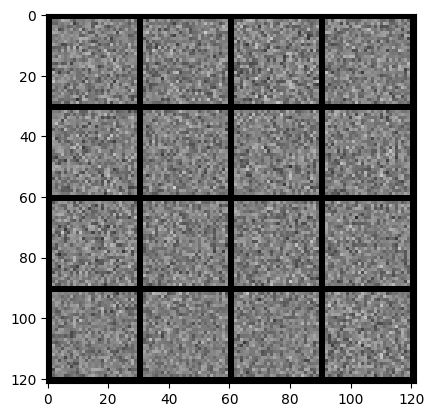

In [17]:
show(fake)

In [28]:
# calculate the loss

# generator loss

def calc_gen_loss(loss_func, gen, disc, bs, z_dim):
    noise = gen_noise(bs, z_dim)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred) # this is ones because as per generator, if image is real i.e 1 then loss is 0.
    gen_loss = loss_func(pred, targets)
    return gen_loss

In [29]:
def calc_disc_loss(loss_func, gen, disc, bs, real, z_dim):
    noise = gen_noise(bs, z_dim)
    fake = gen(noise)
    disc_fake = disc(fake.detach()) # we need to detach the fake, we don't want to change the parameters of the generator so we need to detach, detach the fake images from calculation of the gradients.
    disc_fake_targets = torch.zeros_like(disc_fake) # this is ones because as per discriminator, if fake image is fake i.e 0 then loss is 0.
    disc_fake_loss = loss_func(disc_fake, disc_fake_targets)

    disc_real = disc(real)
    disc_real_targets = torch.ones_like(disc_real) # this is ones because as per discriminator, if real image is real i.e 1 then loss is 0.
    disc_real_loss = loss_func(disc_real, disc_real_targets)
    disc_loss = (disc_fake_loss + disc_real_loss)/2
    return disc_loss


 48%|████▊     | 223/469 [00:03<00:03, 66.08it/s]

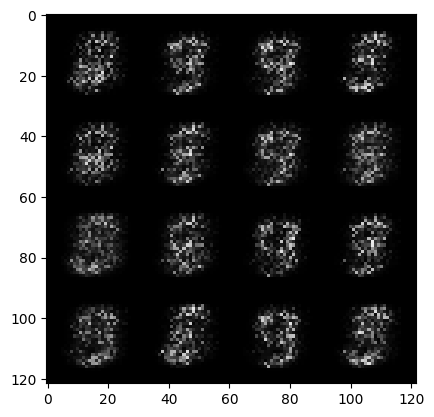

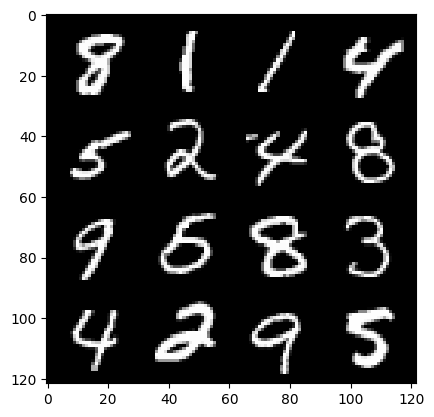

 51%|█████     | 237/469 [00:03<00:03, 58.62it/s]

0: step 2400 / Gen loss: 3.701979769070941 / disc_loss: 0.04402520749097069


 10%|█         | 49/469 [00:00<00:06, 60.50it/s]

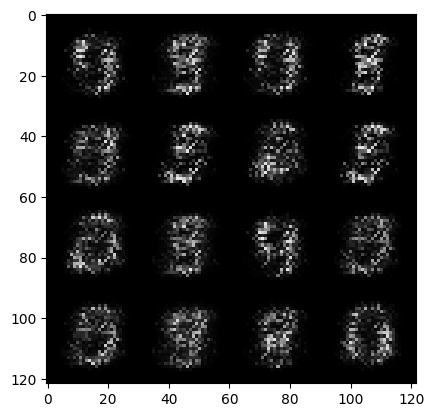

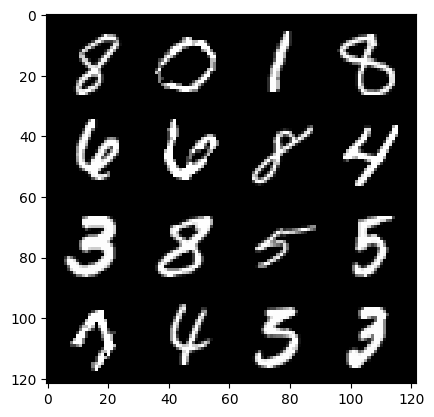

 13%|█▎        | 63/469 [00:01<00:07, 54.96it/s]

1: step 2700 / Gen loss: 4.238127773602803 / disc_loss: 0.033497204172114575


 75%|███████▌  | 353/469 [00:05<00:01, 68.61it/s]

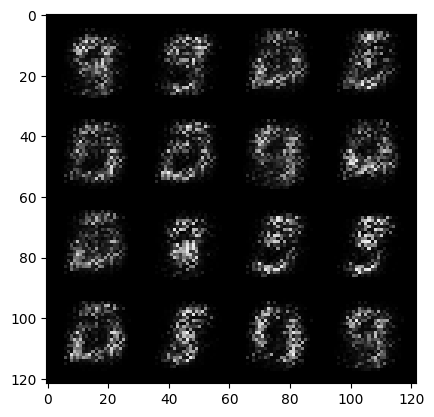

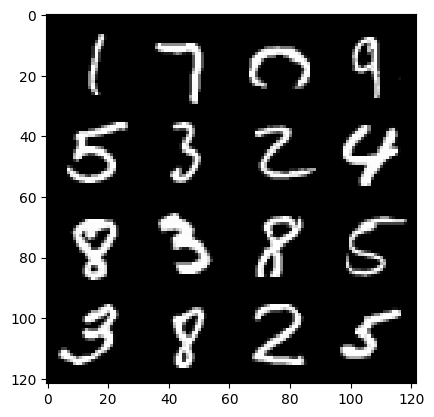

 78%|███████▊  | 368/469 [00:05<00:01, 60.60it/s]

1: step 3000 / Gen loss: 4.740157322883609 / disc_loss: 0.03125306735436122


 39%|███▉      | 182/469 [00:02<00:04, 71.21it/s]

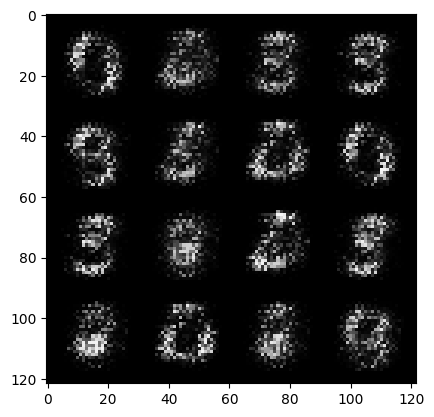

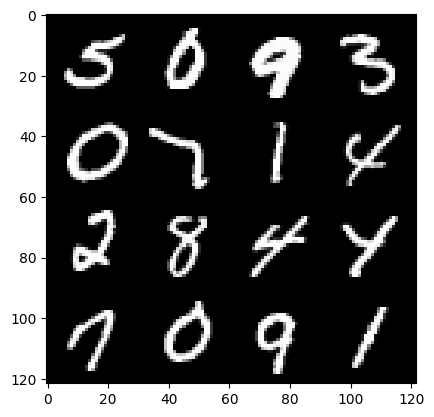

 42%|████▏     | 198/469 [00:02<00:04, 63.30it/s]

2: step 3300 / Gen loss: 4.710576885541285 / disc_loss: 0.029916072779645548


  3%|▎         | 14/469 [00:00<00:06, 66.95it/s]

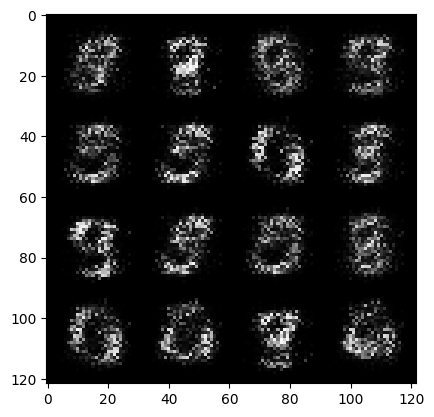

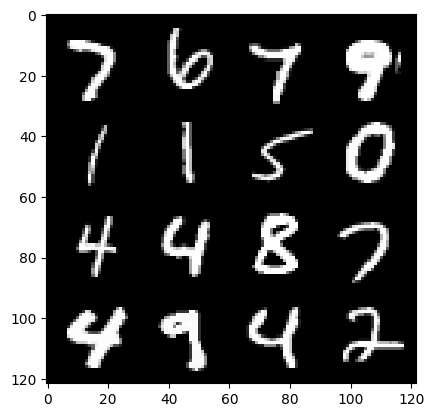

  6%|▌         | 28/469 [00:00<00:08, 54.71it/s]

3: step 3600 / Gen loss: 4.9858799632390305 / disc_loss: 0.02856063252935806


 66%|██████▌   | 310/469 [00:04<00:02, 68.17it/s]

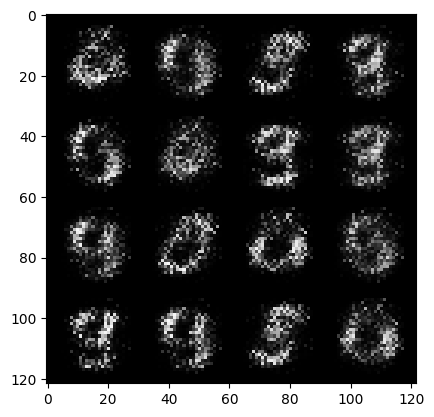

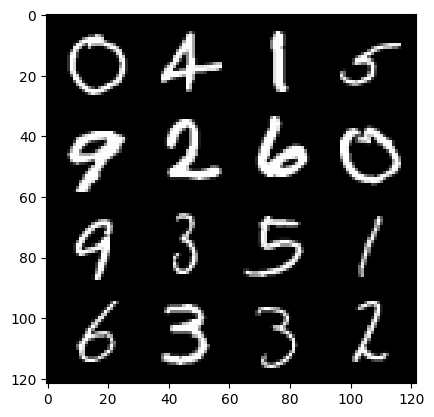

 69%|██████▉   | 325/469 [00:04<00:02, 60.81it/s]

3: step 3900 / Gen loss: 5.435863105456032 / disc_loss: 0.022250905738522602


 31%|███       | 144/469 [00:01<00:04, 73.26it/s]

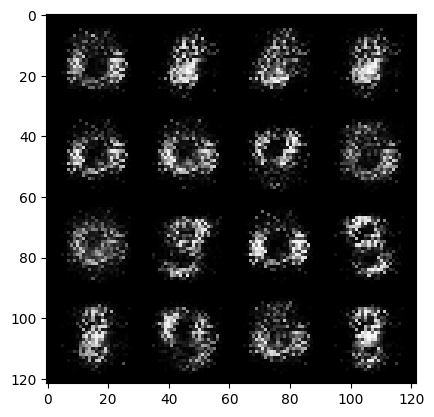

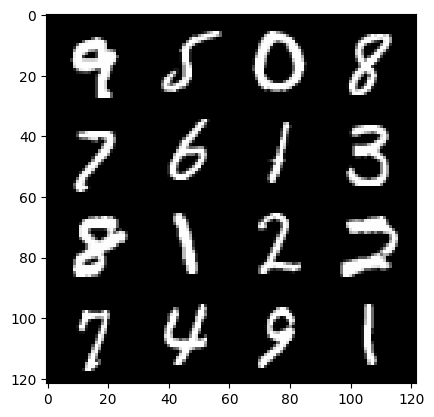

 34%|███▍      | 159/469 [00:02<00:04, 63.17it/s]

4: step 4200 / Gen loss: 5.79849318822225 / disc_loss: 0.021459460056697348


 94%|█████████▍| 440/469 [00:06<00:00, 72.04it/s]

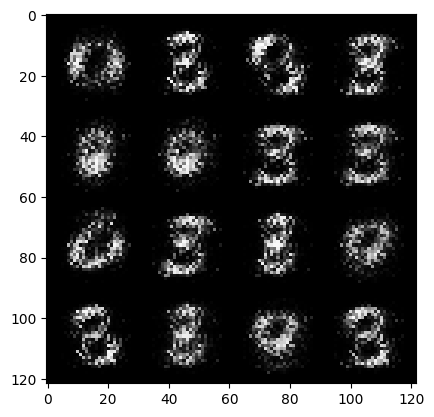

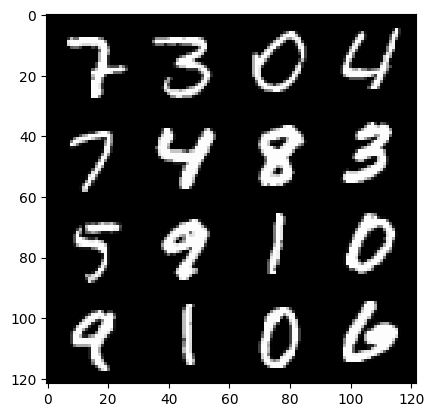

 97%|█████████▋| 455/469 [00:06<00:00, 63.07it/s]

4: step 4500 / Gen loss: 5.810070700645444 / disc_loss: 0.020911764021342025


 59%|█████▊    | 275/469 [00:04<00:02, 69.24it/s]

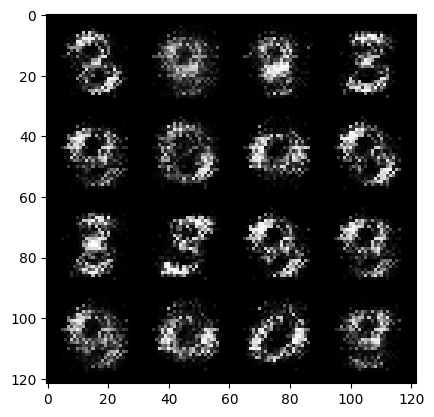

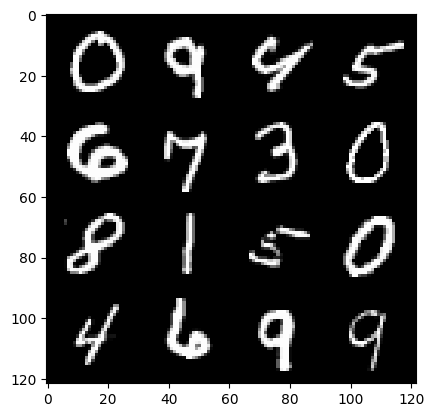

 62%|██████▏   | 290/469 [00:04<00:02, 61.61it/s]

5: step 4800 / Gen loss: 5.696303521792098 / disc_loss: 0.020054332391979793


 23%|██▎       | 109/469 [00:01<00:05, 64.13it/s]

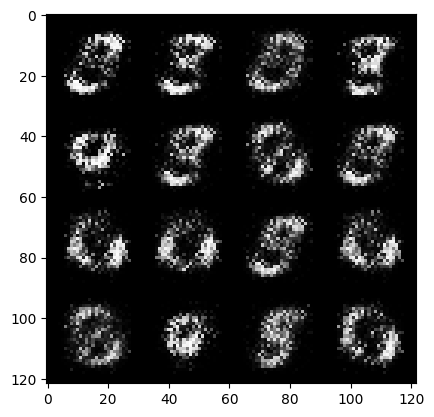

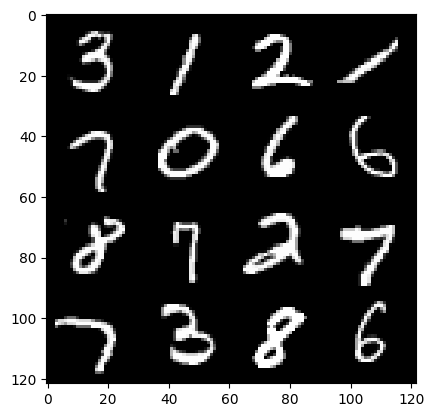

 26%|██▌       | 123/469 [00:01<00:05, 58.46it/s]

6: step 5100 / Gen loss: 5.854005730946857 / disc_loss: 0.019839171452137334


 87%|████████▋ | 408/469 [00:06<00:00, 73.04it/s]

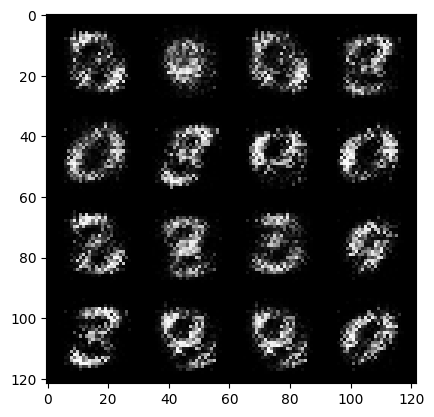

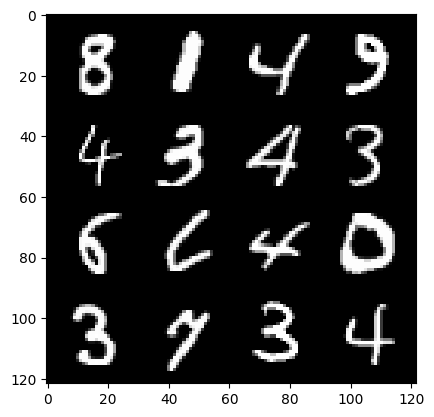

 90%|█████████ | 424/469 [00:06<00:00, 64.29it/s]

6: step 5400 / Gen loss: 6.1267503150304155 / disc_loss: 0.016194977639242998


 50%|█████     | 235/469 [00:03<00:03, 68.77it/s]

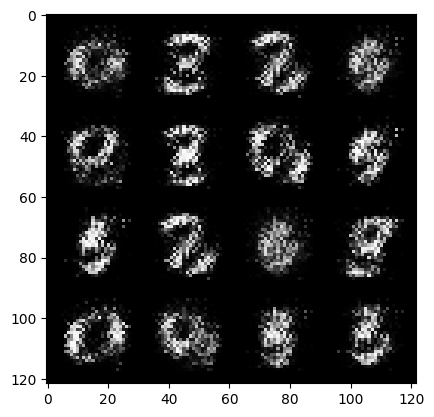

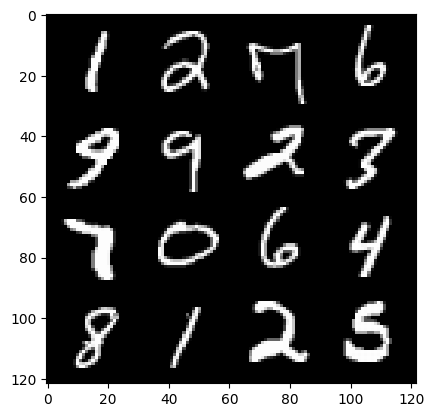

 53%|█████▎    | 249/469 [00:03<00:03, 58.57it/s]

7: step 5700 / Gen loss: 6.143405167261757 / disc_loss: 0.015715395283574855


 14%|█▎        | 64/469 [00:00<00:05, 72.90it/s]

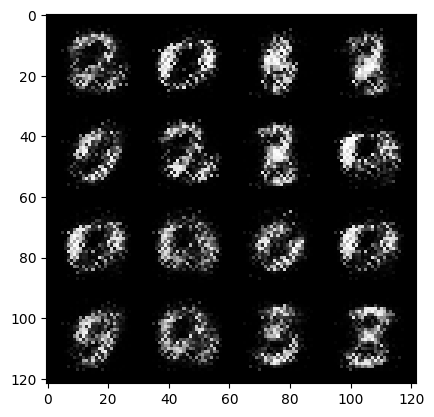

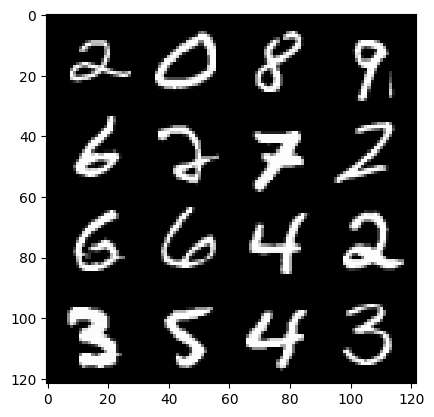

 17%|█▋        | 80/469 [00:01<00:06, 64.04it/s]

8: step 6000 / Gen loss: 6.409999821980791 / disc_loss: 0.013254129112077257


 78%|███████▊  | 368/469 [00:05<00:01, 73.38it/s]

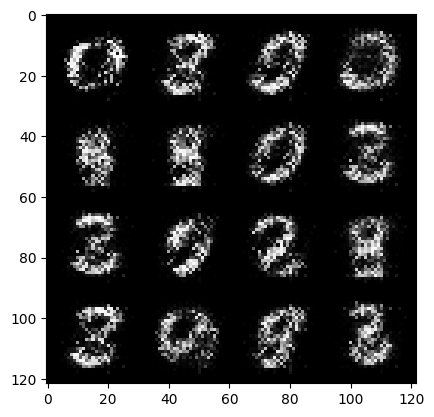

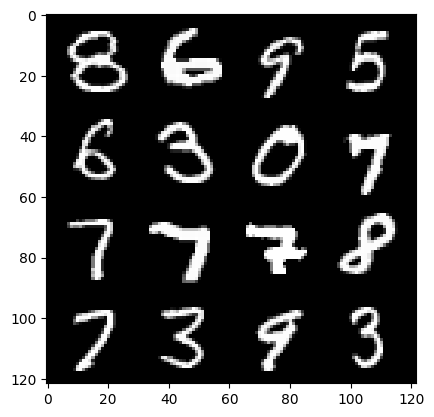

 82%|████████▏ | 384/469 [00:05<00:01, 64.36it/s]

8: step 6300 / Gen loss: 6.346717971165975 / disc_loss: 0.011333222302297752


 42%|████▏     | 199/469 [00:02<00:04, 67.03it/s]

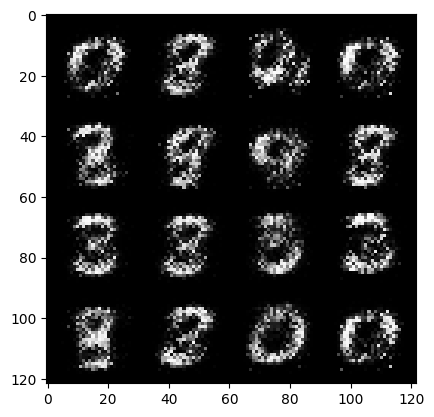

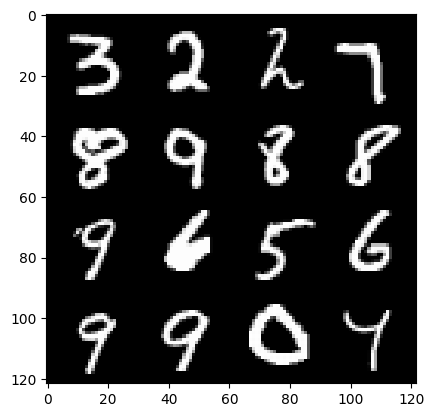

 46%|████▌     | 214/469 [00:03<00:04, 59.69it/s]

9: step 6600 / Gen loss: 6.510999312400818 / disc_loss: 0.010280226408503948


  7%|▋         | 32/469 [00:00<00:06, 72.65it/s]

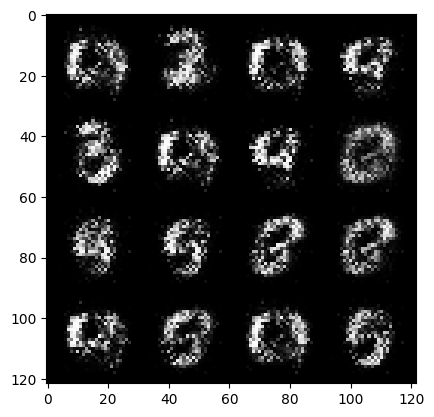

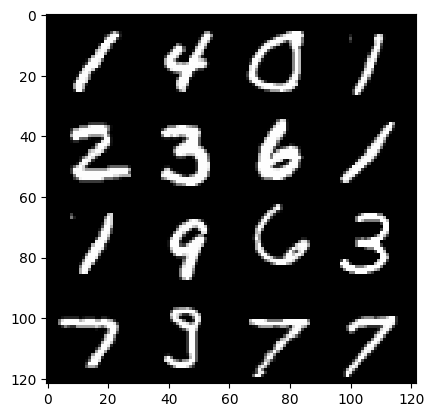

 10%|█         | 47/469 [00:00<00:06, 60.58it/s]

10: step 6900 / Gen loss: 6.42852071921031 / disc_loss: 0.010697408423293388


 70%|██████▉   | 327/469 [00:04<00:01, 76.57it/s]

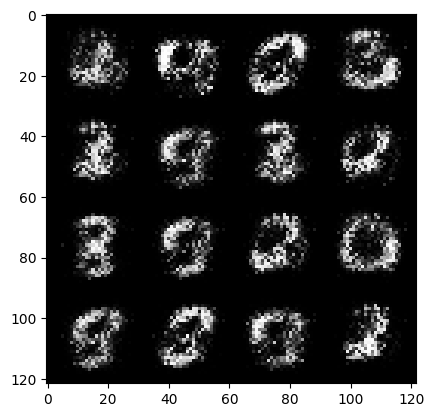

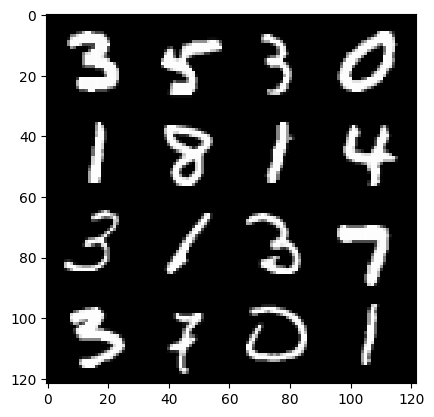

 73%|███████▎  | 343/469 [00:04<00:01, 65.38it/s]

10: step 7200 / Gen loss: 6.796272123654683 / disc_loss: 0.012125206346778822


 34%|███▍      | 159/469 [00:02<00:04, 68.92it/s]

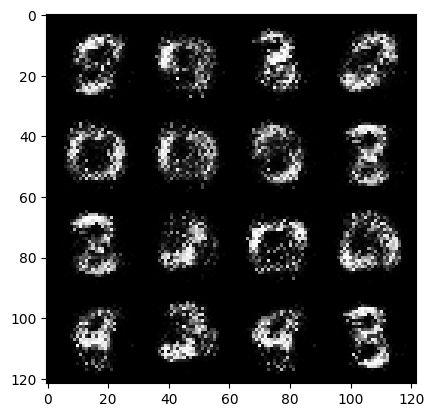

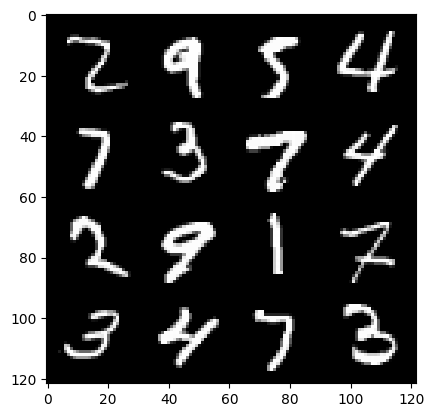

 37%|███▋      | 174/469 [00:02<00:04, 60.26it/s]

11: step 7500 / Gen loss: 6.518045233090722 / disc_loss: 0.012381602226135631


 98%|█████████▊| 460/469 [00:06<00:00, 67.19it/s]

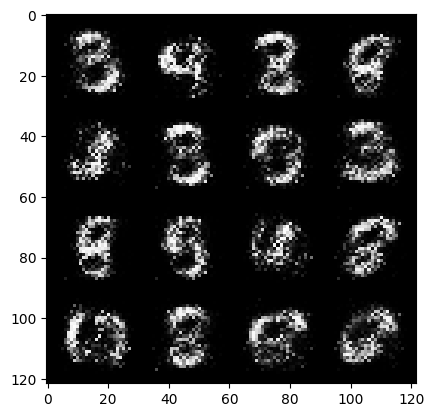

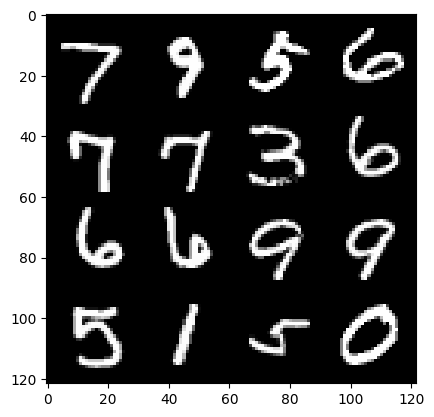

100%|██████████| 469/469 [00:06<00:00, 70.40it/s]


11: step 7800 / Gen loss: 6.618209377924595 / disc_loss: 0.012118723811581725


 62%|██████▏   | 291/469 [00:04<00:02, 69.34it/s]

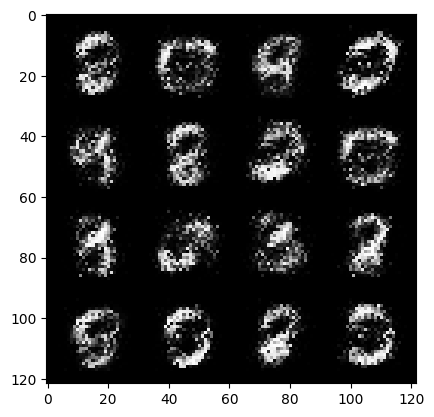

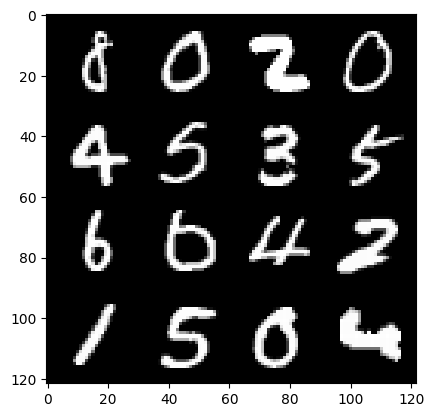

 65%|██████▌   | 306/469 [00:04<00:02, 61.87it/s]

12: step 8100 / Gen loss: 7.0093447128931725 / disc_loss: 0.010423040393119054


 27%|██▋       | 126/469 [00:01<00:05, 65.46it/s]

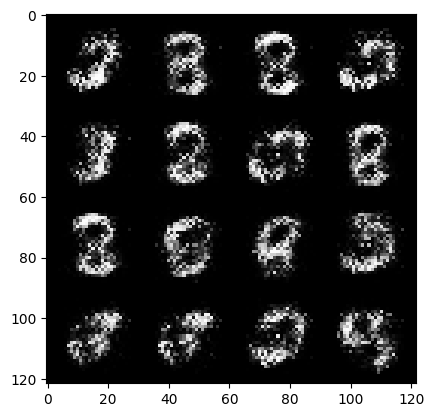

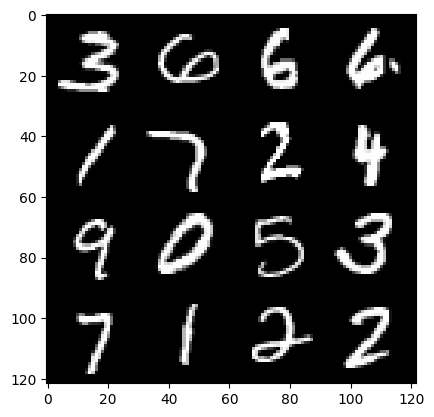

 30%|██▉       | 140/469 [00:02<00:05, 57.80it/s]

13: step 8400 / Gen loss: 6.999301443099971 / disc_loss: 0.010125796988916897


 90%|█████████ | 424/469 [00:06<00:00, 73.79it/s]

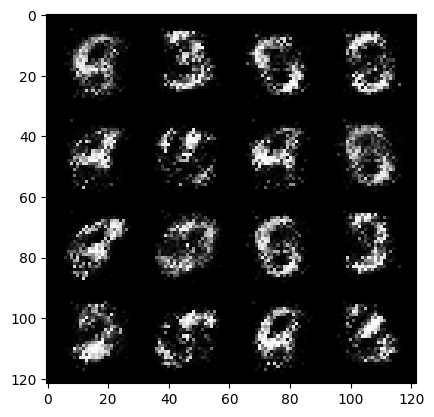

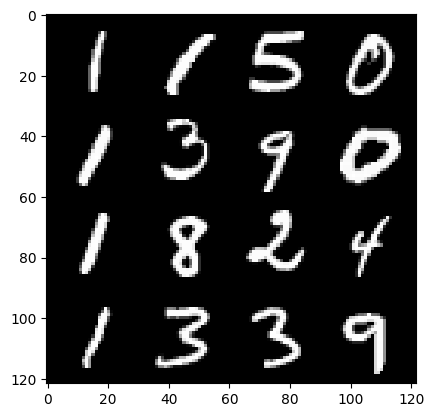

 94%|█████████▍| 440/469 [00:06<00:00, 57.92it/s]

13: step 8700 / Gen loss: 7.189677449862166 / disc_loss: 0.011204164873342966


 54%|█████▍    | 255/469 [00:03<00:02, 72.68it/s]

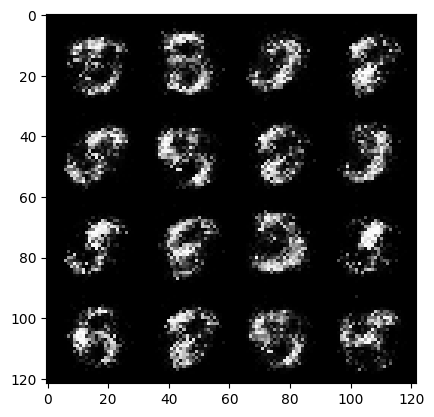

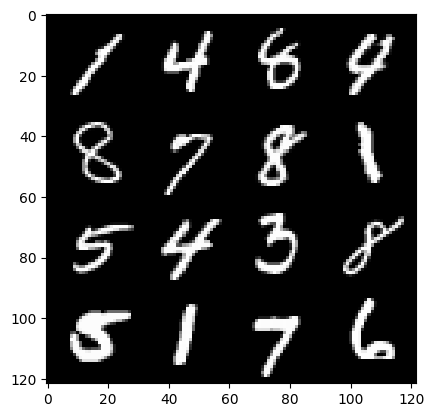

 58%|█████▊    | 271/469 [00:03<00:03, 63.60it/s]

14: step 9000 / Gen loss: 7.405457584063216 / disc_loss: 0.015089942140039064


 19%|█▉        | 88/469 [00:01<00:05, 72.76it/s]

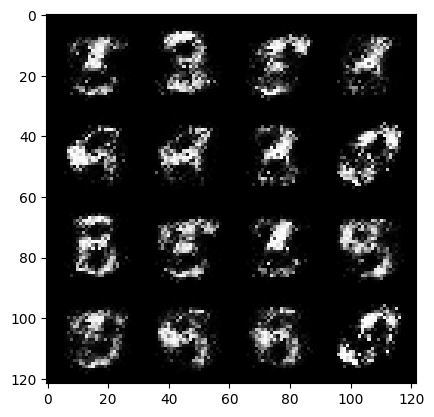

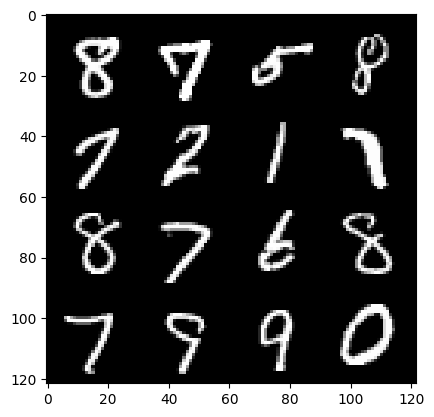

 20%|██        | 96/469 [00:01<00:06, 60.36it/s]

15: step 9300 / Gen loss: 7.127580699920651 / disc_loss: 0.017131760109526394


 82%|████████▏ | 383/469 [00:05<00:01, 72.80it/s]

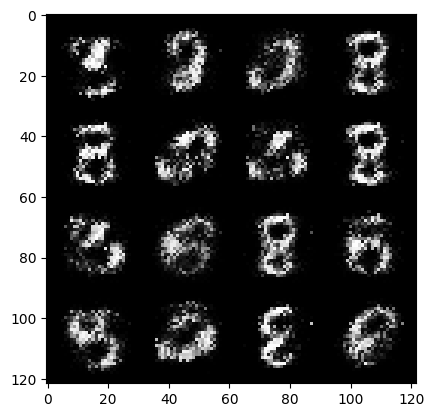

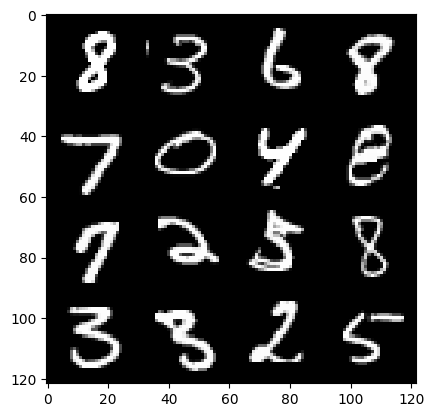

 85%|████████▌ | 399/469 [00:05<00:01, 63.85it/s]

15: step 9600 / Gen loss: 6.903592335383095 / disc_loss: 0.015066306578616304


 46%|████▌     | 216/469 [00:02<00:03, 71.97it/s]

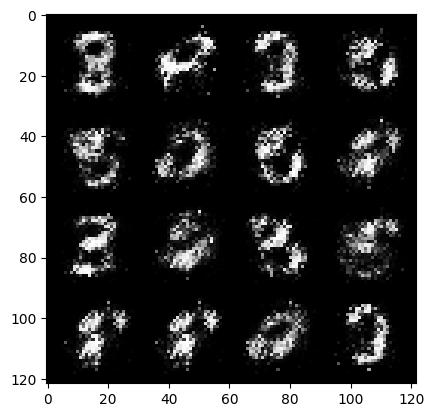

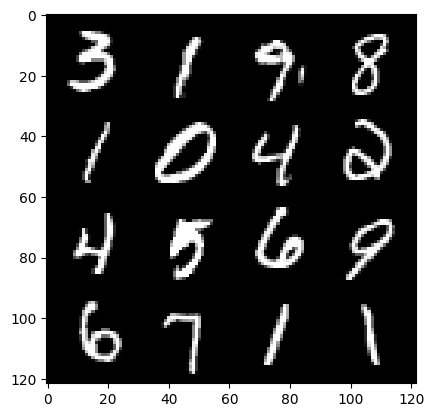

 49%|████▉     | 232/469 [00:03<00:03, 62.78it/s]

16: step 9900 / Gen loss: 7.513365176518756 / disc_loss: 0.013514767045465611


 10%|█         | 49/469 [00:00<00:06, 64.54it/s]

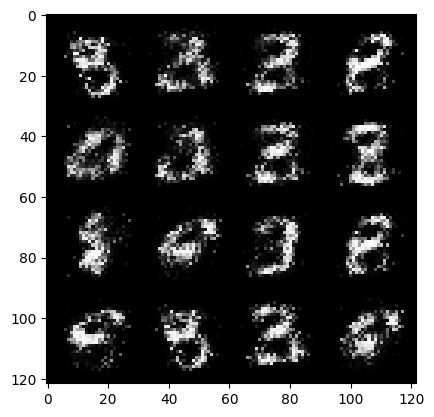

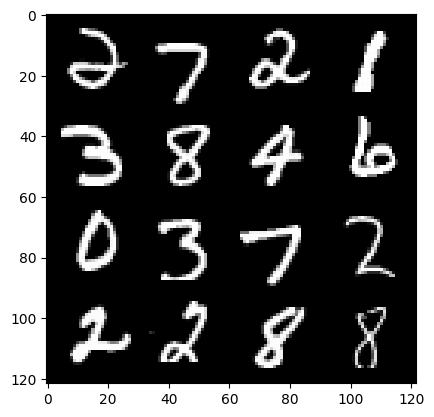

 13%|█▎        | 63/469 [00:01<00:07, 55.93it/s]

17: step 10200 / Gen loss: 7.501859188079841 / disc_loss: 0.01391458303357164


 74%|███████▎  | 345/469 [00:05<00:01, 65.71it/s]

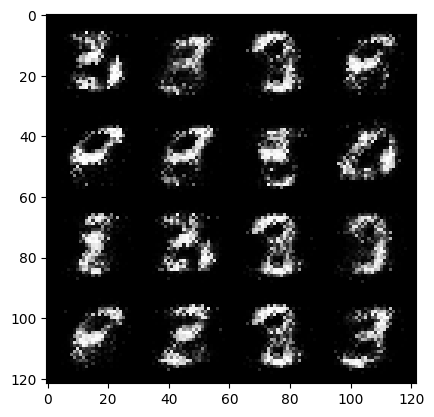

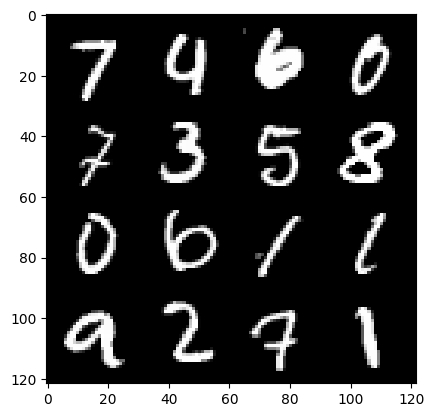

 77%|███████▋  | 359/469 [00:05<00:01, 56.39it/s]

17: step 10500 / Gen loss: 7.161210600535077 / disc_loss: 0.013884772503903754


 39%|███▊      | 181/469 [00:02<00:03, 75.40it/s]

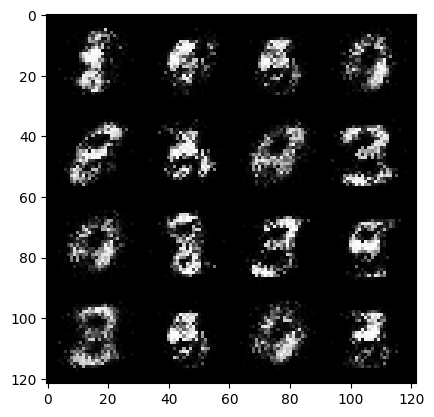

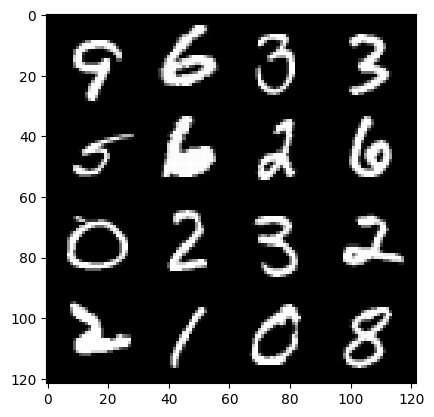

 40%|████      | 189/469 [00:02<00:04, 62.49it/s]

18: step 10800 / Gen loss: 7.061719171206154 / disc_loss: 0.013492225722099349


  2%|▏         | 8/469 [00:00<00:06, 75.33it/s]

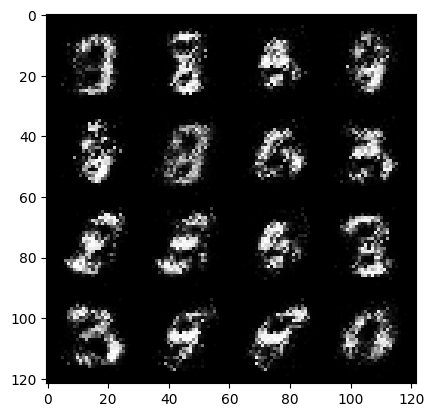

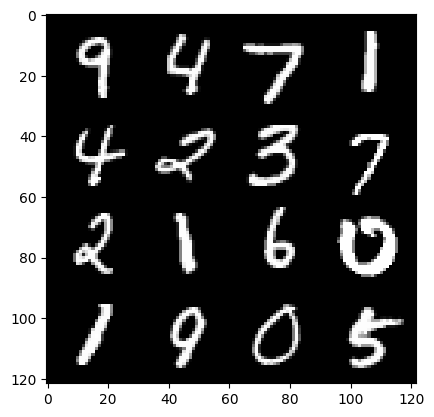

  5%|▌         | 24/469 [00:00<00:07, 60.67it/s]

19: step 11100 / Gen loss: 7.151522100766496 / disc_loss: 0.01610946183636163


 66%|██████▌   | 308/469 [00:04<00:02, 71.91it/s]

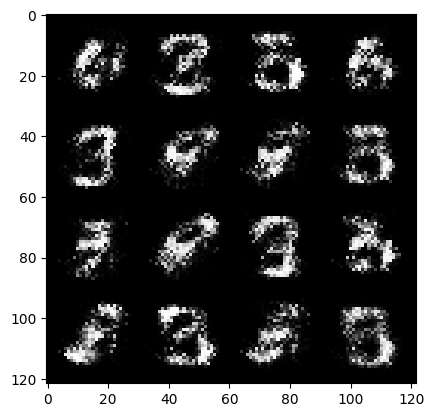

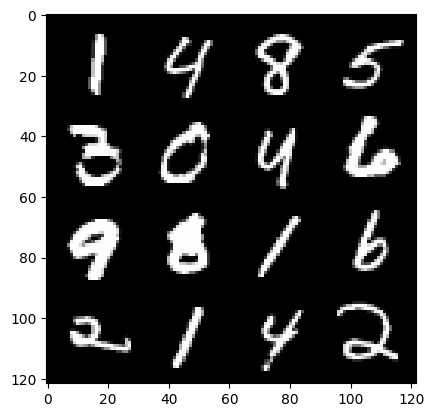

 69%|██████▉   | 323/469 [00:04<00:02, 62.04it/s]

19: step 11400 / Gen loss: 6.887675741513568 / disc_loss: 0.01586485233933974


 29%|██▉       | 136/469 [00:02<00:04, 67.24it/s]

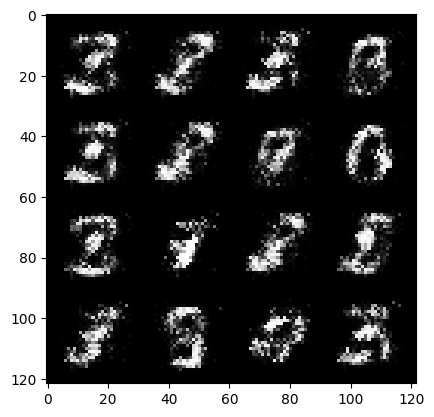

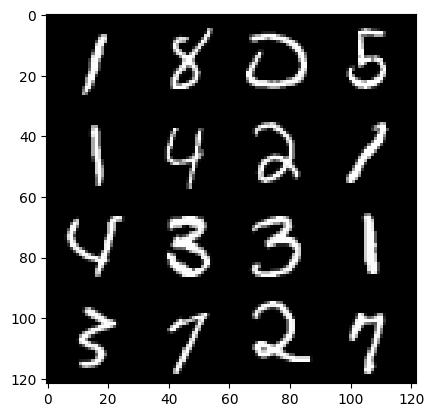

 32%|███▏      | 151/469 [00:02<00:05, 57.78it/s]

20: step 11700 / Gen loss: 7.030421935717265 / disc_loss: 0.015587910645020499


 93%|█████████▎| 438/469 [00:06<00:00, 76.31it/s]

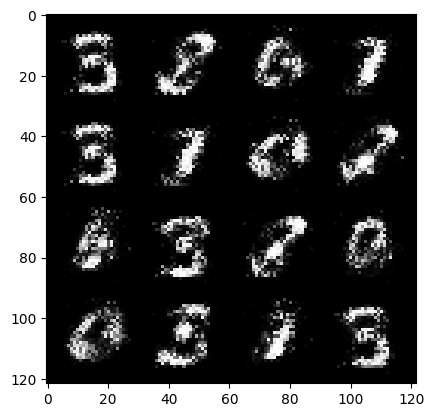

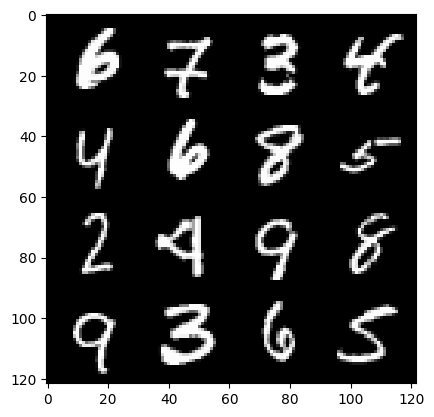

 97%|█████████▋| 454/469 [00:06<00:00, 65.49it/s]

20: step 12000 / Gen loss: 6.863313220342006 / disc_loss: 0.014707962750302018


 58%|█████▊    | 272/469 [00:03<00:02, 73.21it/s]

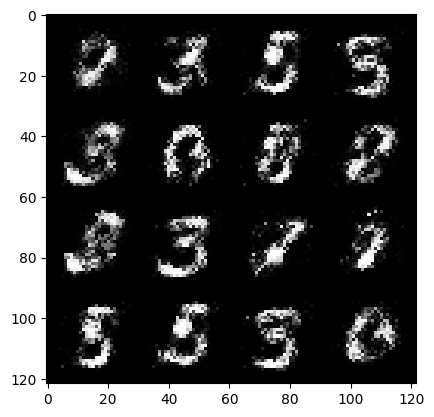

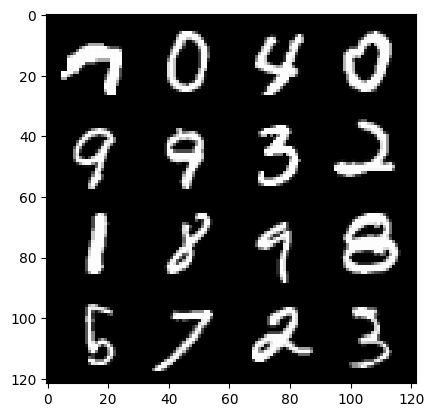

 61%|██████▏   | 288/469 [00:03<00:02, 63.78it/s]

21: step 12300 / Gen loss: 7.269106268882752 / disc_loss: 0.016185339170818522


 21%|██▏       | 100/469 [00:01<00:05, 72.80it/s]

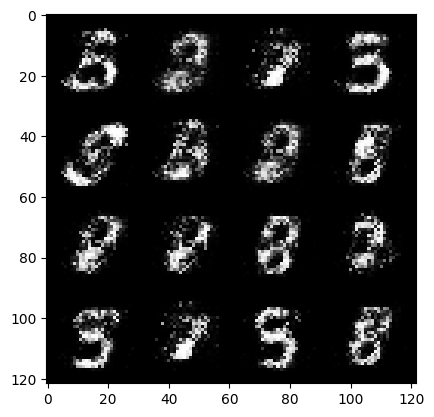

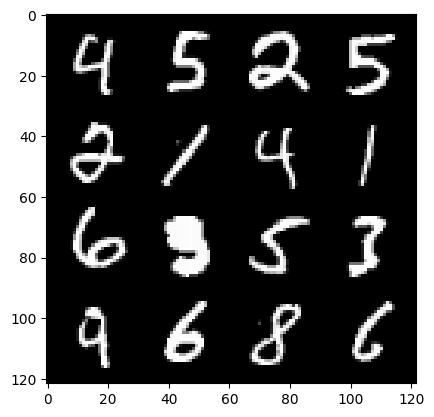

 25%|██▍       | 116/469 [00:01<00:05, 63.20it/s]

22: step 12600 / Gen loss: 6.57067108631134 / disc_loss: 0.02142574822374927


 86%|████████▋ | 405/469 [00:05<00:00, 71.88it/s]

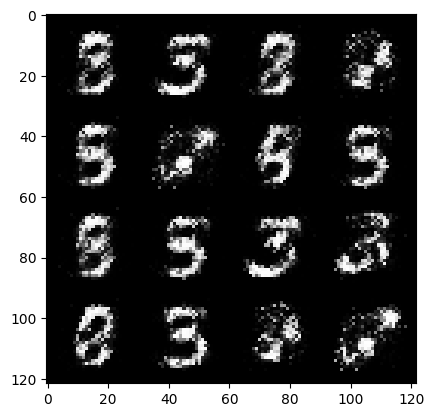

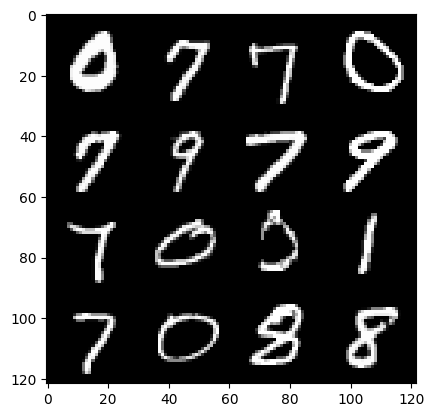

 88%|████████▊ | 413/469 [00:06<00:00, 58.76it/s]

22: step 12900 / Gen loss: 6.448946809768678 / disc_loss: 0.01973424386853972


 50%|█████     | 236/469 [00:03<00:03, 69.32it/s]

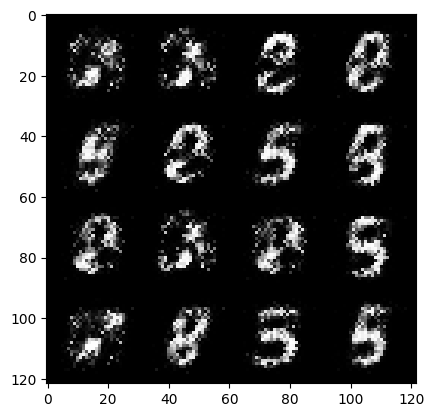

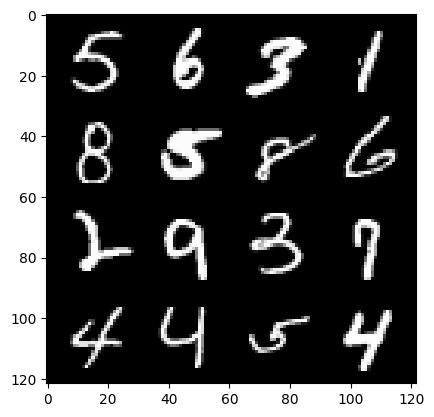

 54%|█████▎    | 251/469 [00:03<00:03, 61.88it/s]

23: step 13200 / Gen loss: 6.535632030169168 / disc_loss: 0.019076897011448934


 14%|█▎        | 64/469 [00:00<00:05, 77.66it/s]

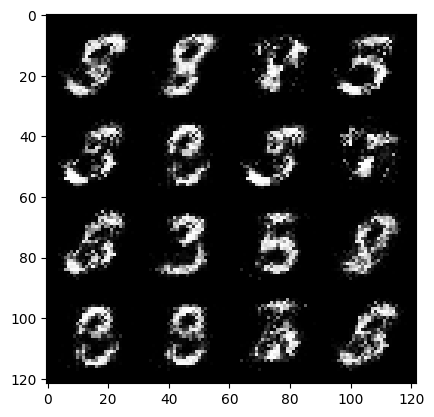

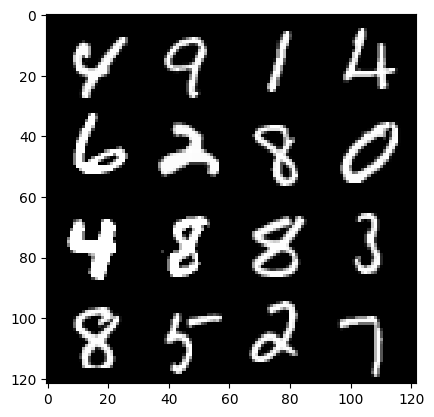

 17%|█▋        | 80/469 [00:01<00:05, 65.20it/s]

24: step 13500 / Gen loss: 6.951624517440799 / disc_loss: 0.018826688822979738


 77%|███████▋  | 360/469 [00:04<00:01, 77.62it/s]

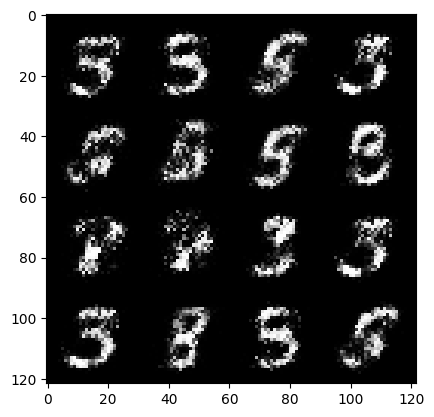

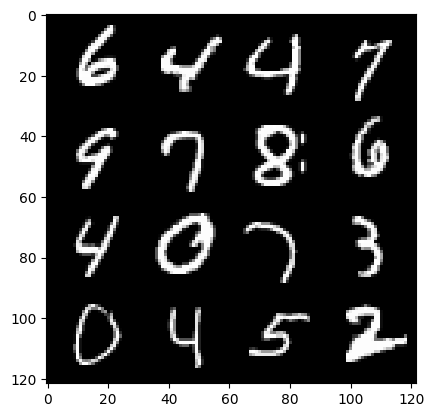

 80%|███████▉  | 375/469 [00:05<00:01, 63.35it/s]

24: step 13800 / Gen loss: 6.844145132700593 / disc_loss: 0.02017569840420039


 42%|████▏     | 198/469 [00:02<00:03, 75.01it/s]

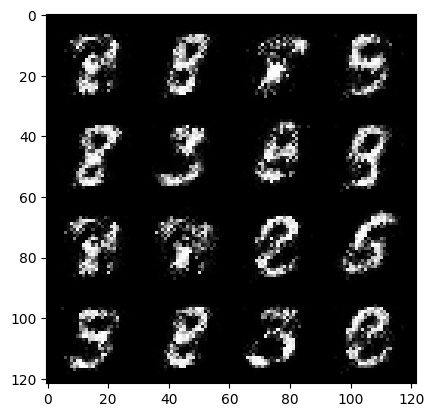

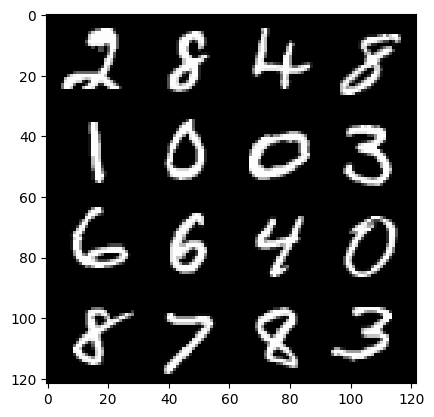

 44%|████▍     | 206/469 [00:02<00:04, 61.47it/s]

25: step 14100 / Gen loss: 6.475640810330705 / disc_loss: 0.018836525046887497


  5%|▍         | 22/469 [00:00<00:06, 69.14it/s]

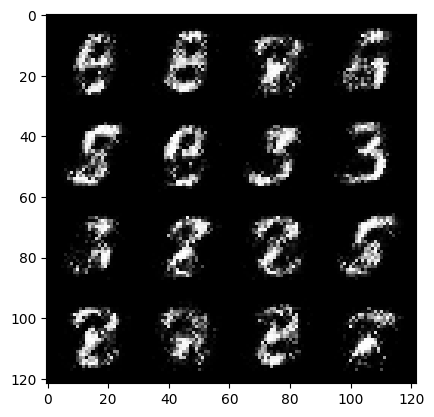

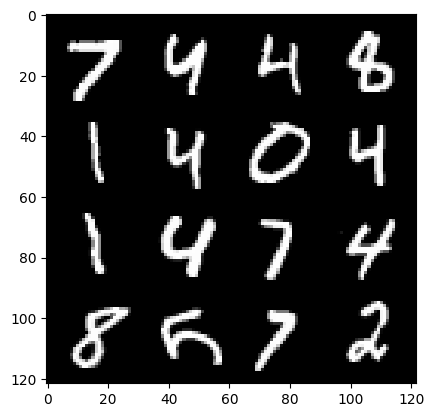

  8%|▊         | 36/469 [00:00<00:07, 57.36it/s]

26: step 14400 / Gen loss: 6.384227949778238 / disc_loss: 0.020407011734011264


 69%|██████▉   | 323/469 [00:04<00:02, 71.98it/s]

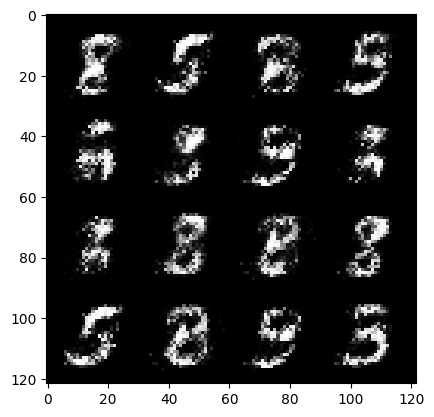

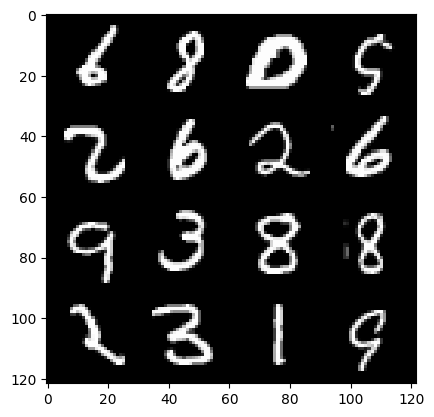

 72%|███████▏  | 339/469 [00:05<00:02, 62.35it/s]

26: step 14700 / Gen loss: 6.326828443209328 / disc_loss: 0.0239212626280884


 34%|███▍      | 160/469 [00:02<00:04, 75.31it/s]

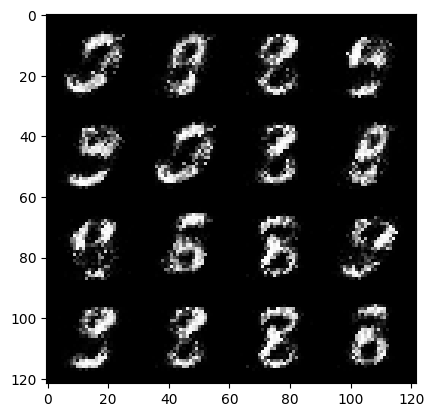

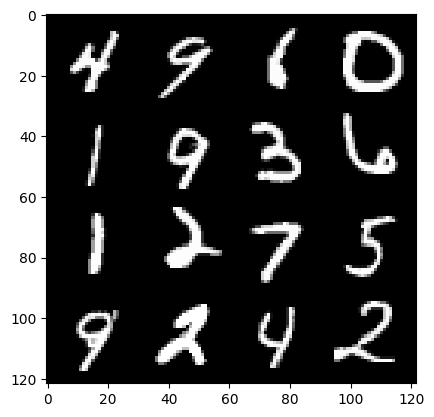

 36%|███▌      | 168/469 [00:02<00:05, 59.29it/s]

27: step 15000 / Gen loss: 6.26234163125356 / disc_loss: 0.024339452204294513


 98%|█████████▊| 458/469 [00:06<00:00, 71.22it/s]

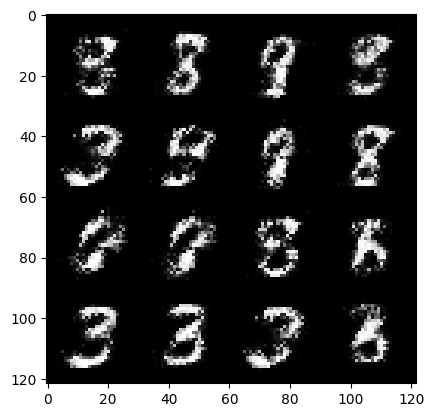

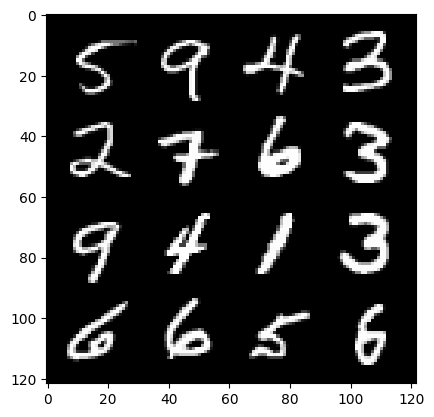

100%|██████████| 469/469 [00:06<00:00, 69.94it/s]


27: step 15300 / Gen loss: 6.037912184397378 / disc_loss: 0.02843544221172731


 61%|██████    | 286/469 [00:04<00:02, 71.14it/s]

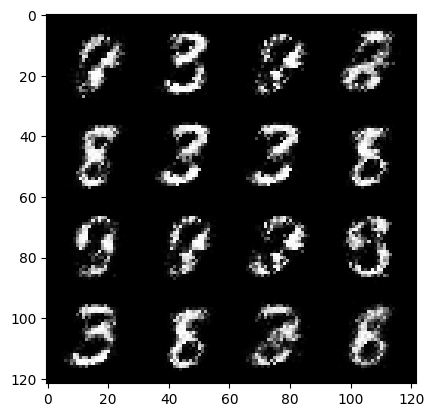

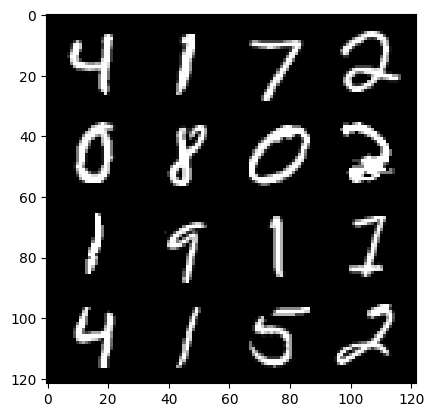

 64%|██████▍   | 302/469 [00:04<00:02, 62.82it/s]

28: step 15600 / Gen loss: 6.081119343439737 / disc_loss: 0.03268761725164948


 26%|██▌       | 120/469 [00:01<00:05, 66.14it/s]

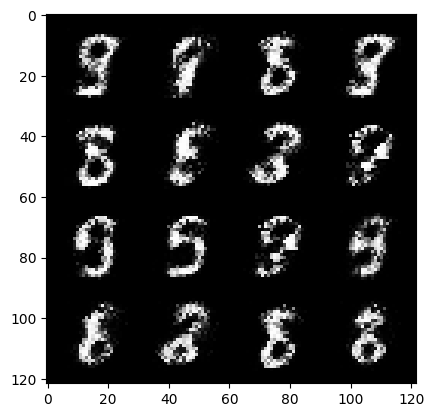

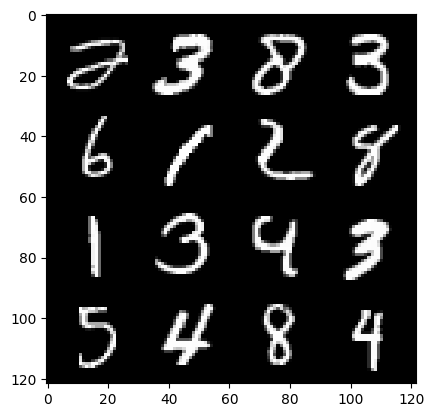

 27%|██▋       | 127/469 [00:02<00:07, 46.19it/s]

29: step 15900 / Gen loss: 5.892939883867898 / disc_loss: 0.031242934412633365


 90%|████████▉ | 420/469 [00:06<00:00, 65.79it/s]

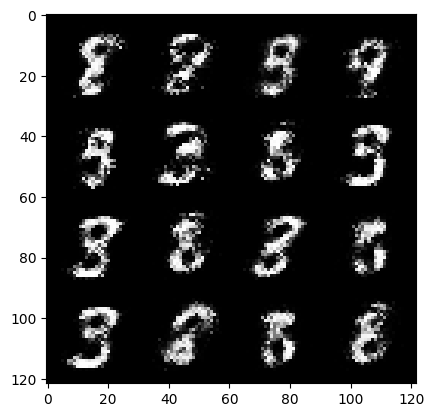

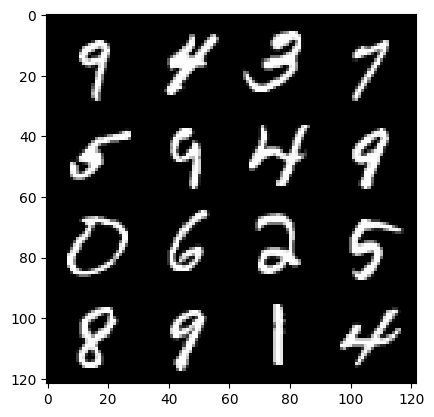

 93%|█████████▎| 434/469 [00:06<00:00, 56.40it/s]

29: step 16200 / Gen loss: 6.066170392036443 / disc_loss: 0.02547937757490823


 53%|█████▎    | 250/469 [00:03<00:03, 69.57it/s]

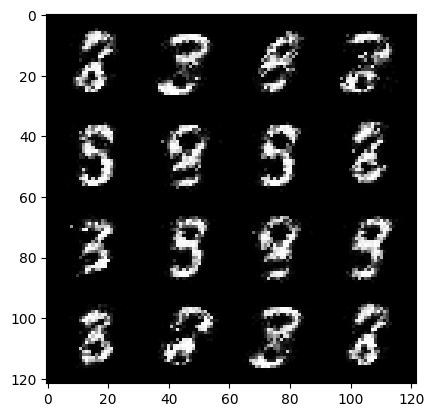

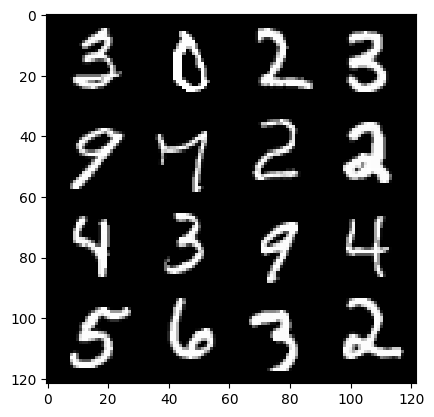

 56%|█████▋    | 264/469 [00:04<00:03, 59.45it/s]

30: step 16500 / Gen loss: 5.910878500938413 / disc_loss: 0.027920610653236484


 17%|█▋        | 80/469 [00:01<00:05, 76.68it/s]

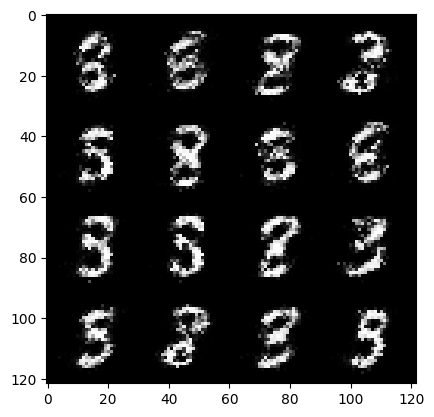

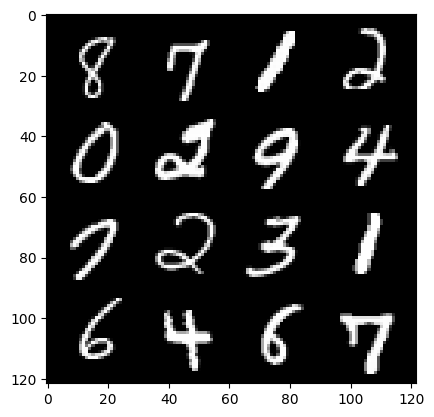

 20%|██        | 96/469 [00:01<00:05, 65.49it/s]

31: step 16800 / Gen loss: 5.69138874053955 / disc_loss: 0.033267654680336524


 82%|████████▏ | 384/469 [00:05<00:01, 69.84it/s]

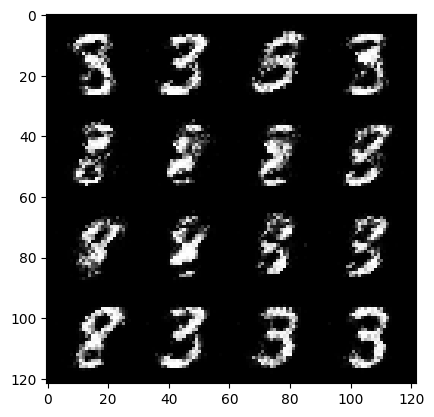

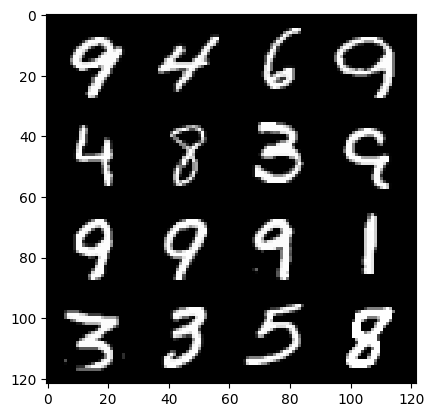

 84%|████████▎ | 392/469 [00:05<00:01, 55.47it/s]

31: step 17100 / Gen loss: 5.776686166127521 / disc_loss: 0.03507346459664403


 45%|████▍     | 211/469 [00:03<00:03, 66.93it/s]

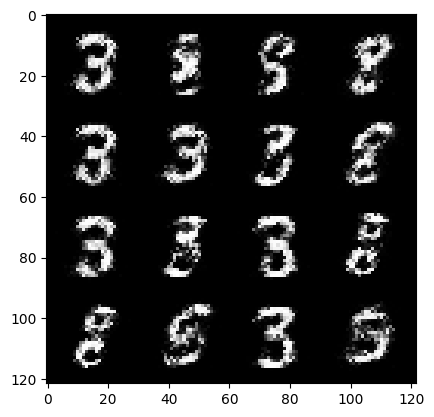

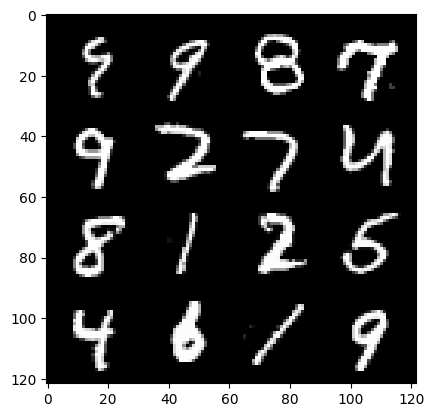

 48%|████▊     | 225/469 [00:03<00:04, 58.09it/s]

32: step 17400 / Gen loss: 5.410097346305841 / disc_loss: 0.04235625693884989


  9%|▉         | 44/469 [00:00<00:06, 69.25it/s]

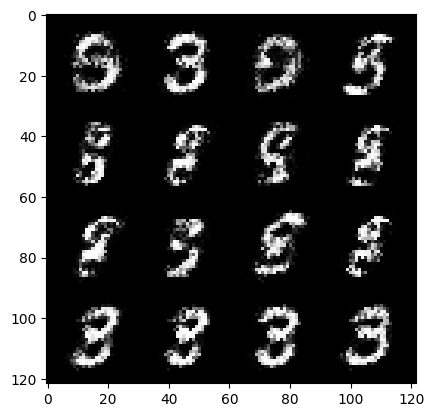

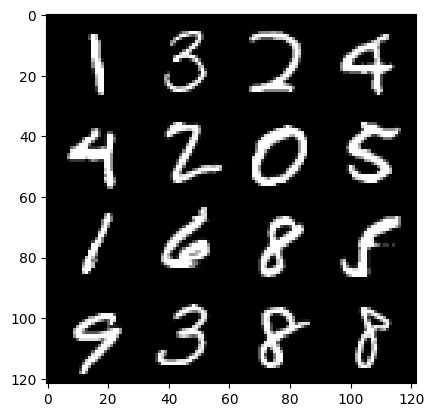

 13%|█▎        | 59/469 [00:00<00:06, 60.21it/s]

33: step 17700 / Gen loss: 5.878044441541041 / disc_loss: 0.03673758881166578


 73%|███████▎  | 341/469 [00:04<00:01, 72.93it/s]

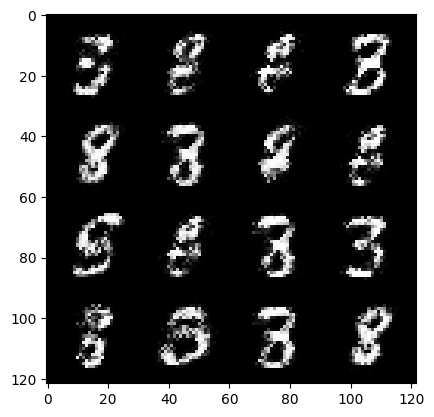

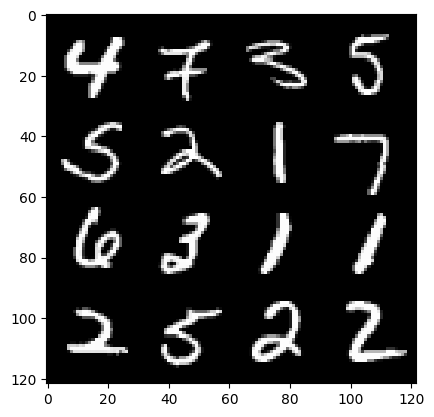

 76%|███████▌  | 356/469 [00:05<00:01, 62.61it/s]

33: step 18000 / Gen loss: 5.779380876223247 / disc_loss: 0.04163828237913547


 37%|███▋      | 173/469 [00:02<00:04, 70.67it/s]

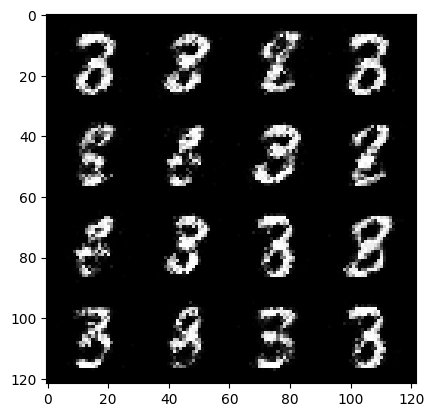

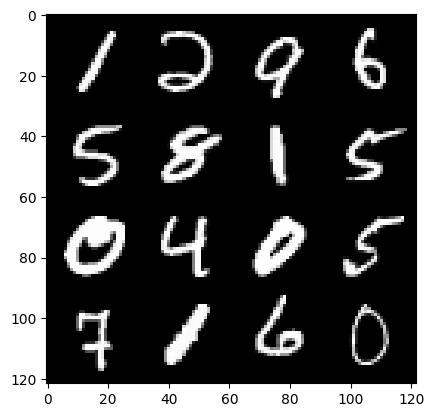

 40%|████      | 188/469 [00:02<00:04, 59.48it/s]

34: step 18300 / Gen loss: 5.677863732973736 / disc_loss: 0.03840989863965659


  1%|▏         | 7/469 [00:00<00:07, 65.40it/s]

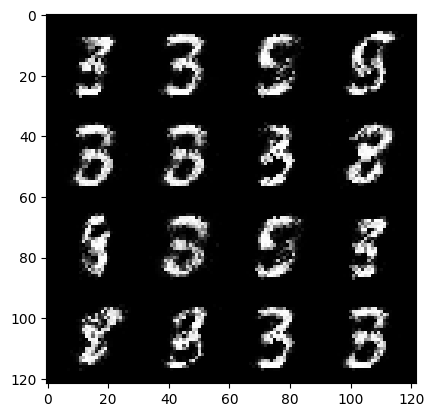

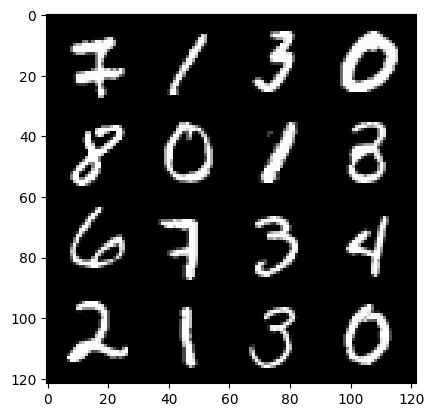

  4%|▍         | 21/469 [00:00<00:08, 54.23it/s]

35: step 18600 / Gen loss: 5.68418579896291 / disc_loss: 0.037976704267784954


 64%|██████▍   | 302/469 [00:04<00:02, 67.22it/s]

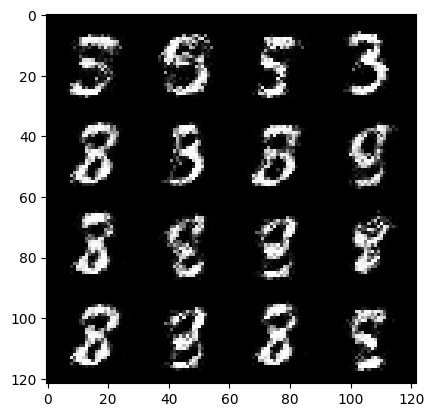

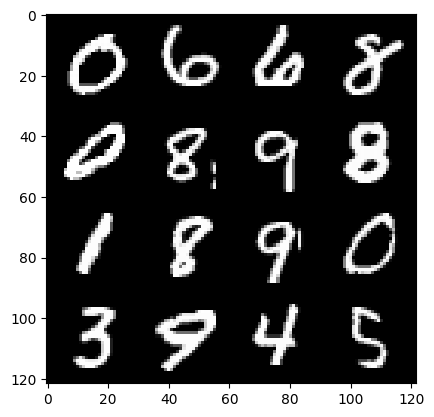

 67%|██████▋   | 316/469 [00:04<00:02, 60.53it/s]

35: step 18900 / Gen loss: 5.560989915529895 / disc_loss: 0.041593542244906245


 29%|██▉       | 137/469 [00:02<00:04, 66.79it/s]

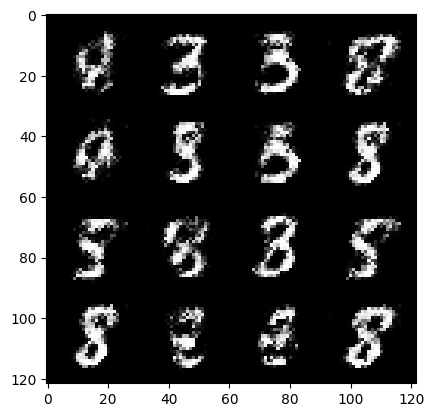

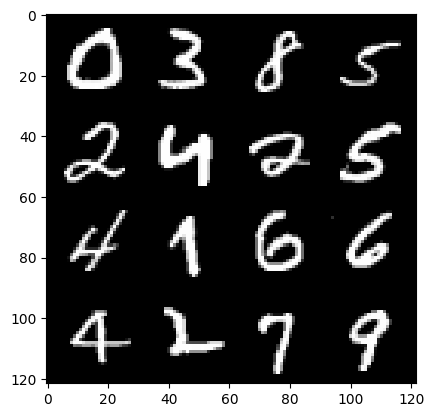

 32%|███▏      | 152/469 [00:02<00:05, 59.90it/s]

36: step 19200 / Gen loss: 5.34638345003128 / disc_loss: 0.05234484115305045


 93%|█████████▎| 434/469 [00:06<00:00, 68.17it/s]

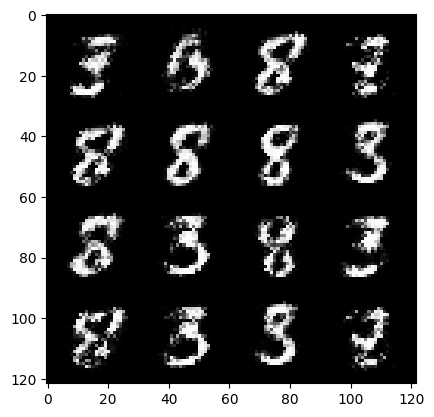

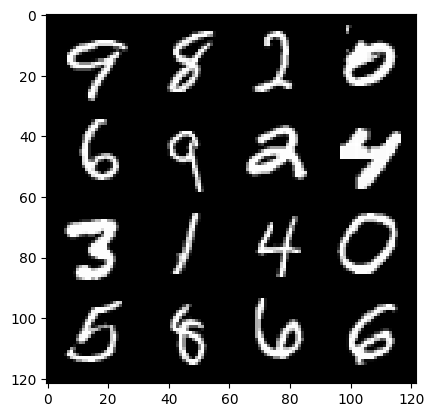

 96%|█████████▌| 448/469 [00:06<00:00, 58.80it/s]

36: step 19500 / Gen loss: 5.466650168100994 / disc_loss: 0.05027074685630694


 57%|█████▋    | 268/469 [00:03<00:02, 70.90it/s]

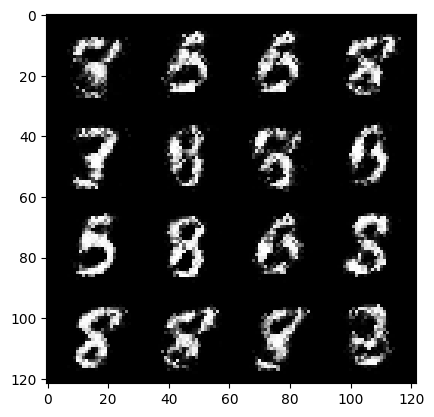

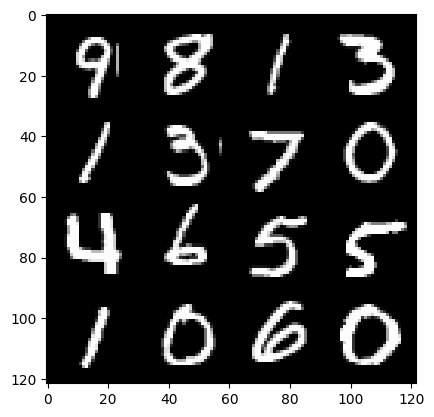

 60%|██████    | 283/469 [00:04<00:03, 59.74it/s]

37: step 19800 / Gen loss: 5.388246440887447 / disc_loss: 0.05472876527036231


 20%|██        | 96/469 [00:01<00:05, 73.96it/s]

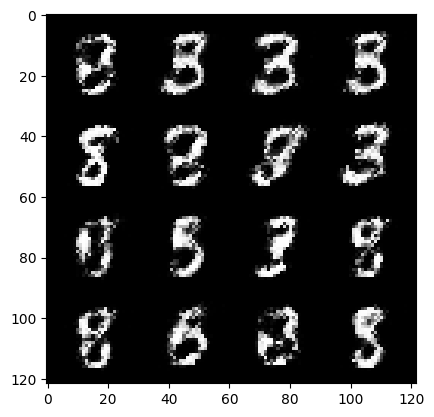

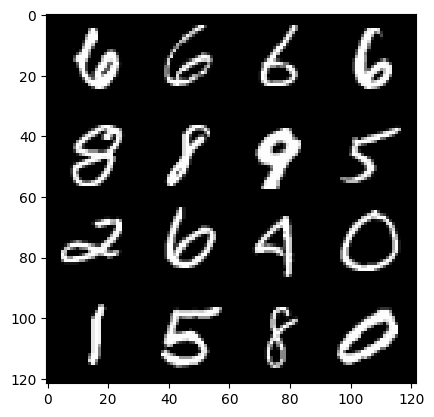

 24%|██▍       | 112/469 [00:01<00:05, 63.52it/s]

38: step 20100 / Gen loss: 5.519842003981275 / disc_loss: 0.04596015677166482


 85%|████████▍ | 398/469 [00:05<00:00, 74.28it/s]

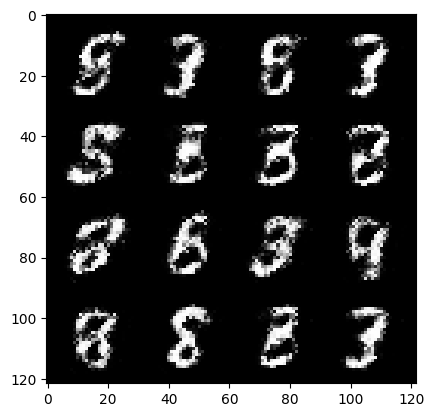

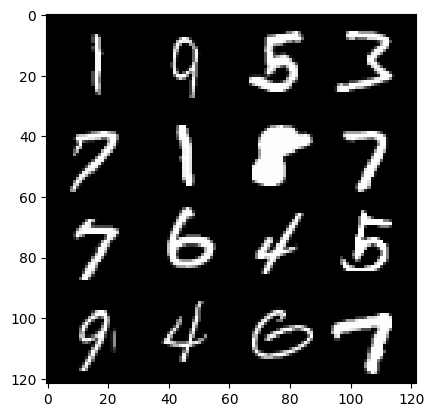

 88%|████████▊ | 414/469 [00:05<00:00, 63.42it/s]

38: step 20400 / Gen loss: 5.2608417256673174 / disc_loss: 0.04707815769749384


 49%|████▉     | 229/469 [00:03<00:03, 66.44it/s]

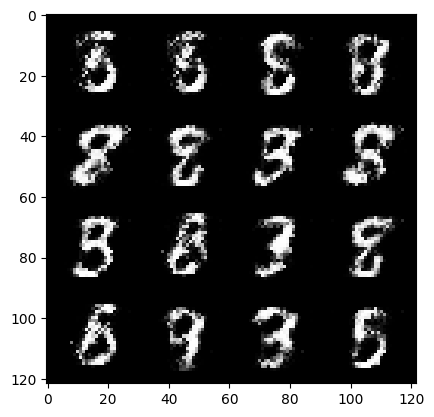

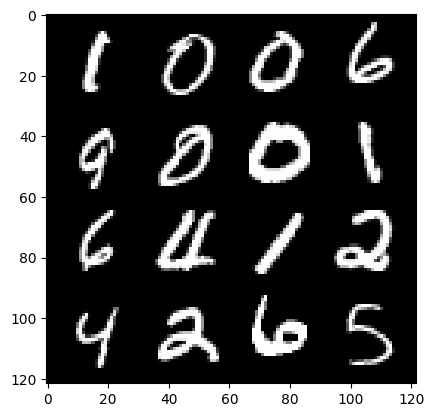

 52%|█████▏    | 244/469 [00:03<00:03, 59.01it/s]

39: step 20700 / Gen loss: 5.442509261767077 / disc_loss: 0.045781434737145854


 12%|█▏        | 57/469 [00:00<00:06, 68.37it/s]

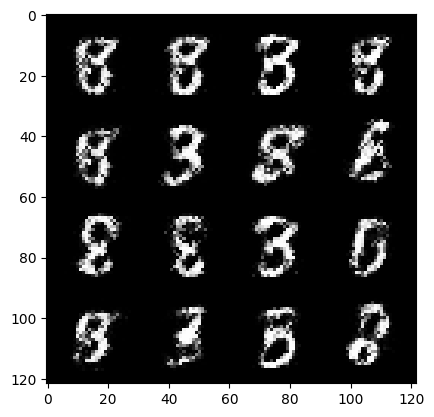

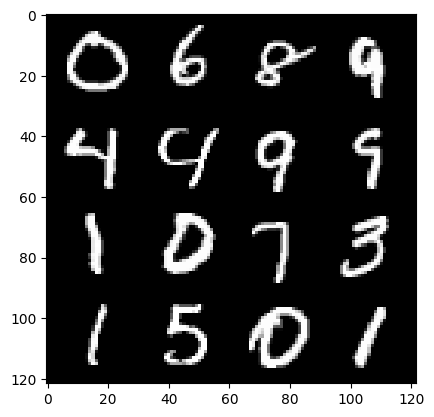

 15%|█▍        | 70/469 [00:01<00:06, 57.35it/s]

40: step 21000 / Gen loss: 5.485439963340757 / disc_loss: 0.05368075874944527


 77%|███████▋  | 360/469 [00:05<00:01, 66.75it/s]

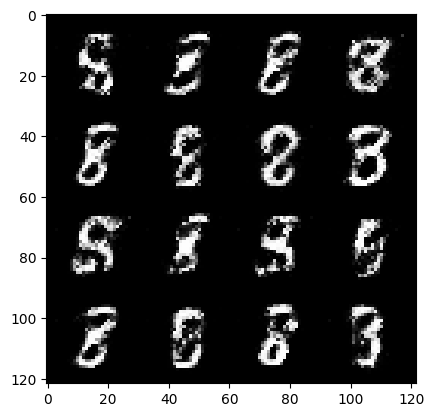

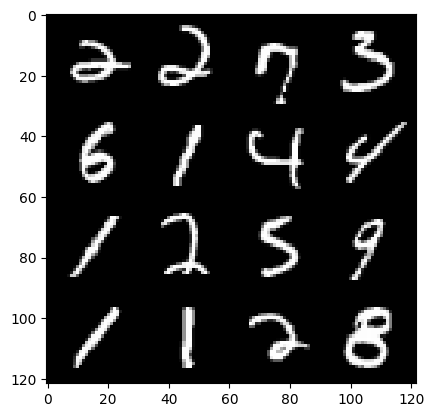

 80%|███████▉  | 374/469 [00:05<00:01, 58.34it/s]

40: step 21300 / Gen loss: 5.253634241422018 / disc_loss: 0.05423312151183684


 41%|████      | 192/469 [00:02<00:03, 74.58it/s]

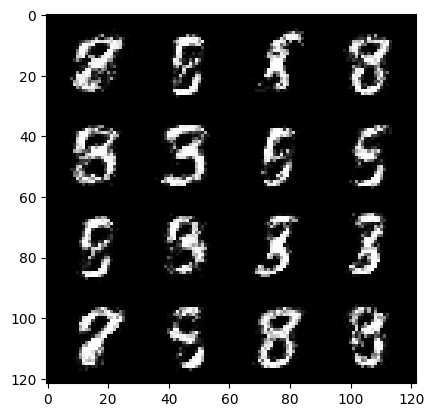

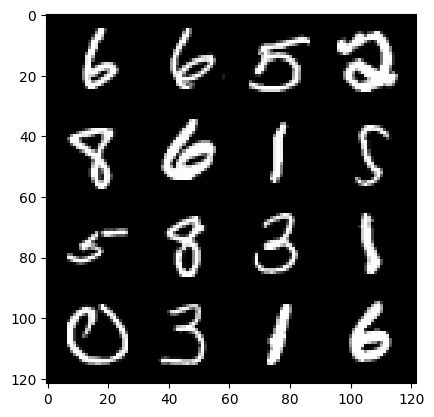

 44%|████▍     | 208/469 [00:02<00:04, 65.11it/s]

41: step 21600 / Gen loss: 5.141587568918865 / disc_loss: 0.060074365331480875


  5%|▌         | 24/469 [00:00<00:05, 74.35it/s]

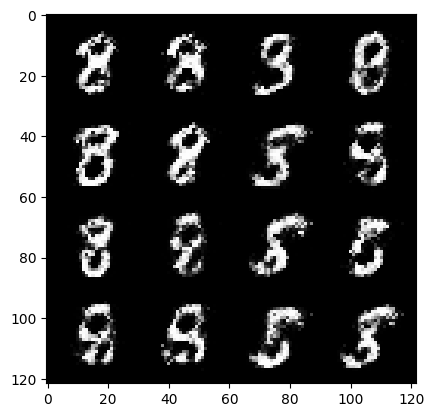

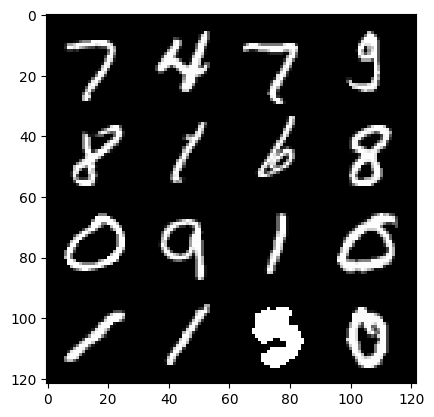

  9%|▊         | 40/469 [00:00<00:06, 62.95it/s]

42: step 21900 / Gen loss: 5.088168555895482 / disc_loss: 0.055287652149175595


 68%|██████▊   | 319/469 [00:04<00:02, 74.52it/s]

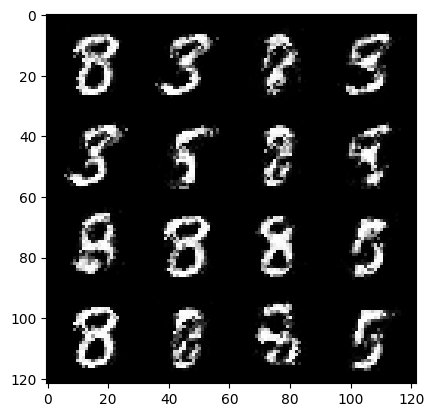

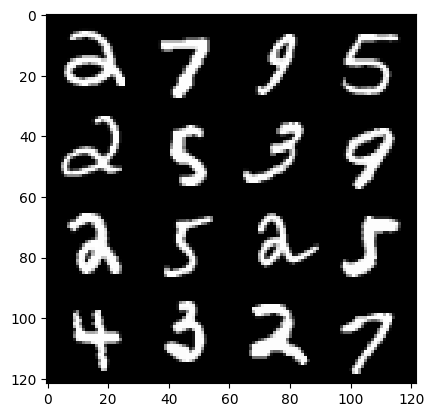

 71%|███████   | 334/469 [00:04<00:02, 62.27it/s]

42: step 22200 / Gen loss: 5.209270671208698 / disc_loss: 0.0592728448907534


 32%|███▏      | 152/469 [00:02<00:04, 75.78it/s]

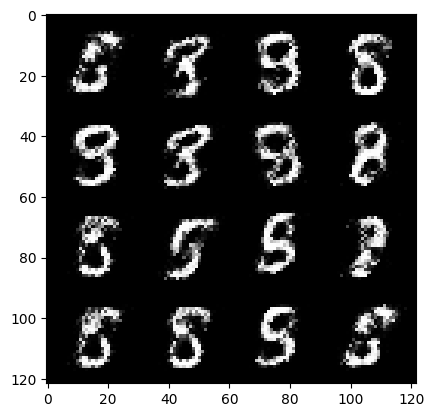

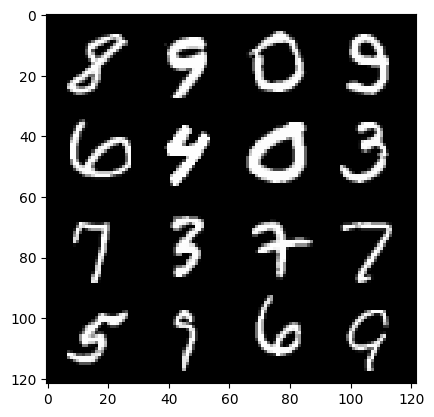

 36%|███▌      | 168/469 [00:02<00:04, 64.81it/s]

43: step 22500 / Gen loss: 5.194177117347715 / disc_loss: 0.061613971227779944


 97%|█████████▋| 455/469 [00:06<00:00, 73.66it/s]

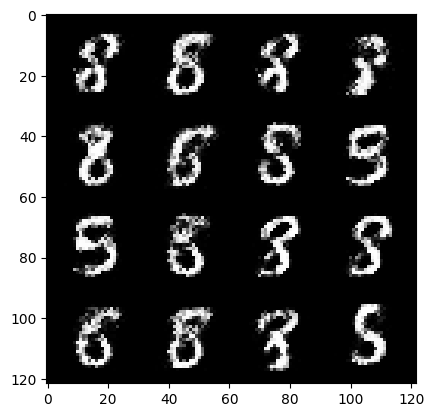

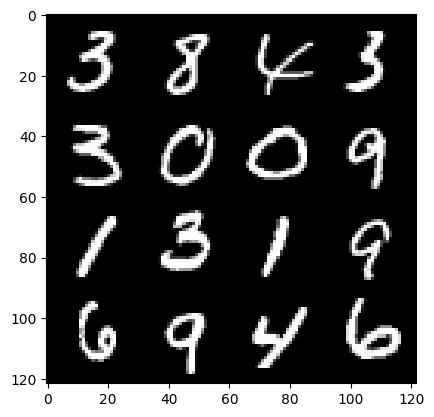

100%|██████████| 469/469 [00:06<00:00, 73.29it/s]


43: step 22800 / Gen loss: 5.203436157703395 / disc_loss: 0.07282830438887077


 61%|██████    | 287/469 [00:04<00:02, 65.82it/s]

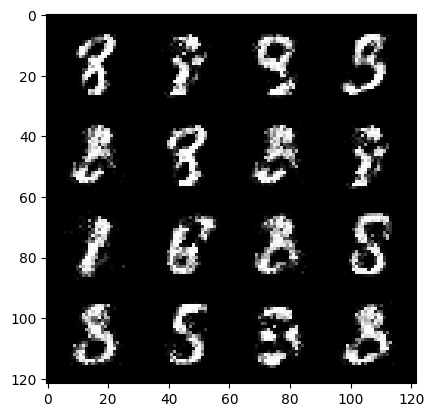

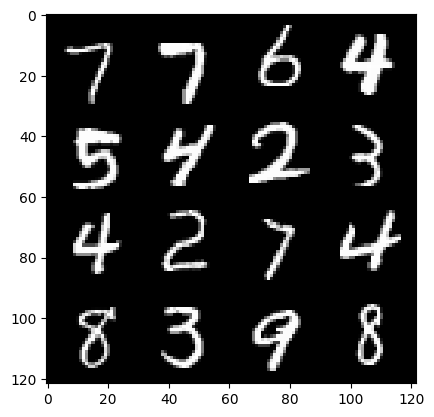

 63%|██████▎   | 294/469 [00:04<00:03, 54.54it/s]

44: step 23100 / Gen loss: 4.974368958473205 / disc_loss: 0.06222013014058273


 25%|██▍       | 116/469 [00:01<00:05, 69.93it/s]

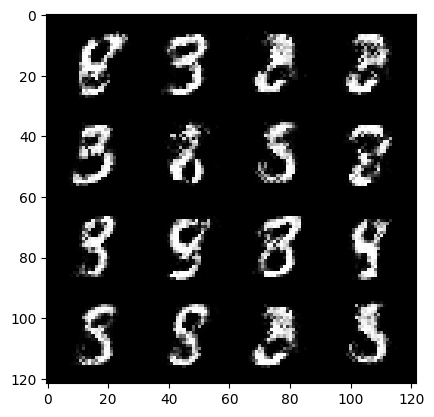

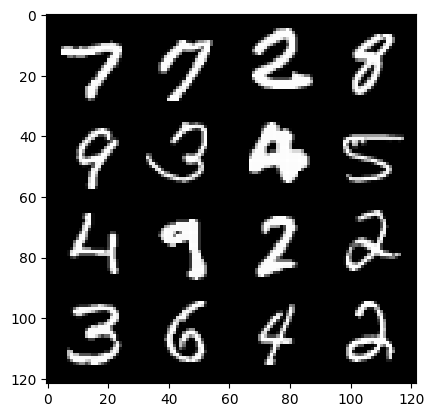

 28%|██▊       | 131/469 [00:01<00:05, 58.66it/s]

45: step 23400 / Gen loss: 4.940143833160398 / disc_loss: 0.060307966610416784


 88%|████████▊ | 414/469 [00:06<00:00, 72.68it/s]

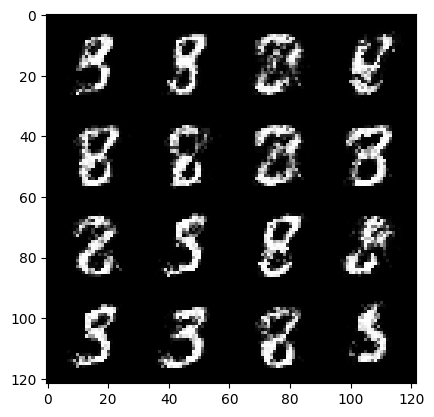

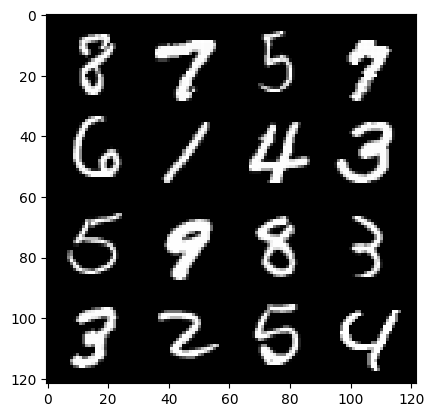

 91%|█████████▏| 429/469 [00:06<00:00, 55.12it/s]

45: step 23700 / Gen loss: 5.035358542601268 / disc_loss: 0.07018674983953434


 52%|█████▏    | 244/469 [00:03<00:03, 67.07it/s]

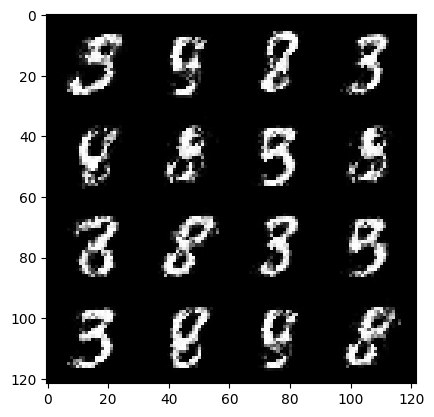

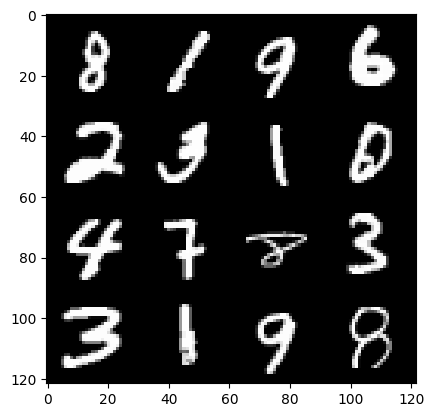

 55%|█████▍    | 257/469 [00:03<00:03, 55.87it/s]

46: step 24000 / Gen loss: 4.929617091814681 / disc_loss: 0.0639080323589345


 17%|█▋        | 80/469 [00:01<00:05, 68.00it/s]

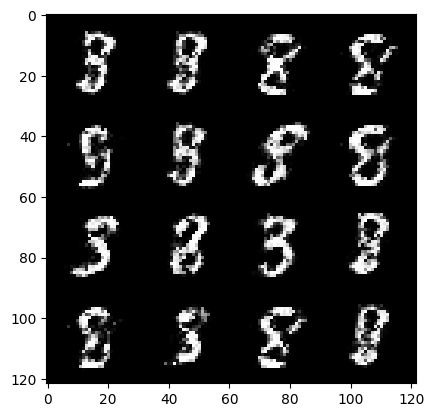

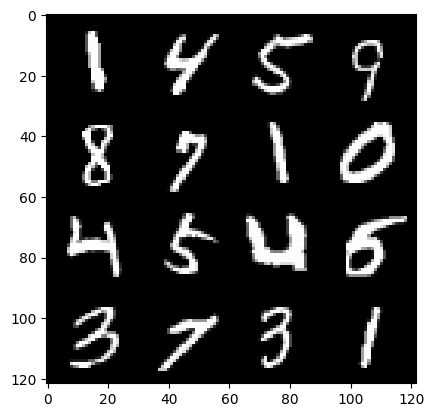

 19%|█▊        | 87/469 [00:01<00:06, 56.34it/s]

47: step 24300 / Gen loss: 5.04060562769572 / disc_loss: 0.06680226822694142


 80%|███████▉  | 374/469 [00:05<00:01, 75.43it/s]

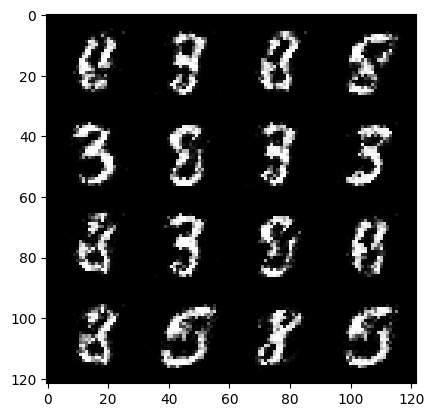

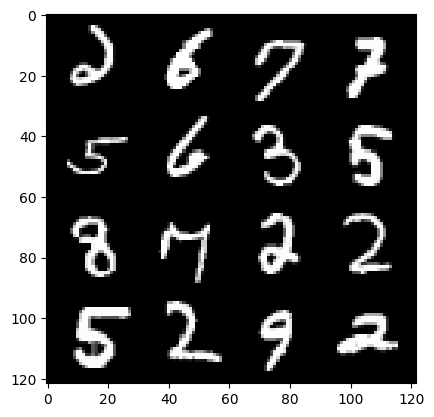

 83%|████████▎ | 389/469 [00:05<00:01, 64.71it/s]

47: step 24600 / Gen loss: 5.0319391743342115 / disc_loss: 0.06793122664093966


 44%|████▍     | 208/469 [00:02<00:03, 72.21it/s]

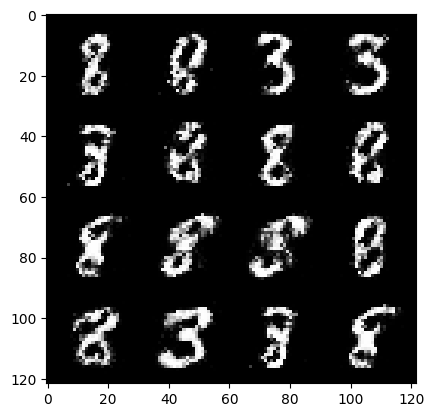

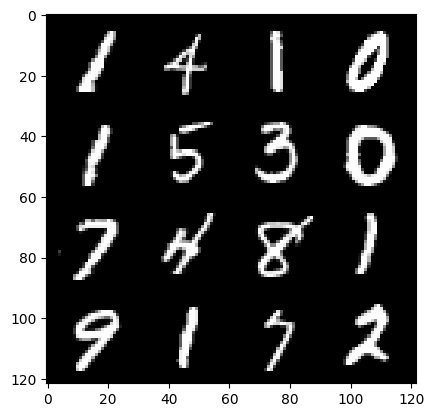

 48%|████▊     | 223/469 [00:03<00:04, 61.44it/s]

48: step 24900 / Gen loss: 5.012556436856587 / disc_loss: 0.07020957102378209


  8%|▊         | 39/469 [00:00<00:06, 70.93it/s]

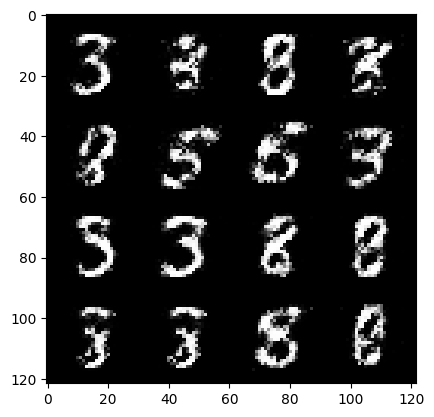

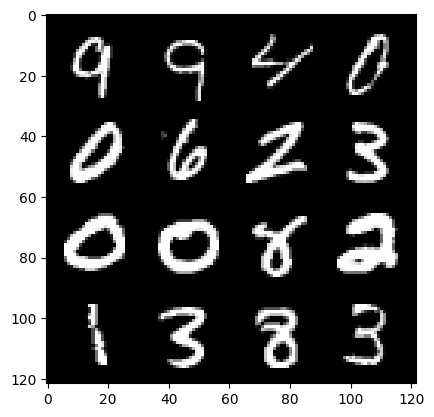

 12%|█▏        | 55/469 [00:00<00:06, 61.41it/s]

49: step 25200 / Gen loss: 4.860799353122708 / disc_loss: 0.07374115152284506


 72%|███████▏  | 338/469 [00:04<00:01, 70.11it/s]

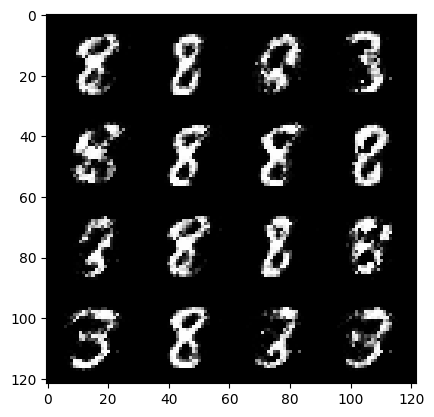

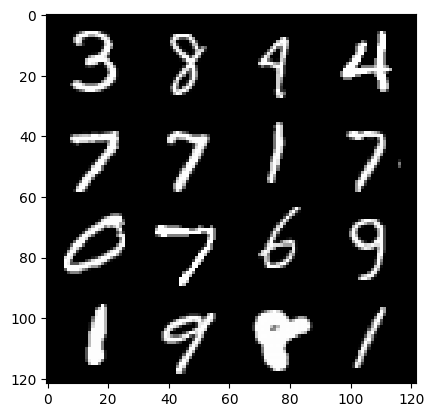

 75%|███████▌  | 353/469 [00:05<00:01, 60.98it/s]

49: step 25500 / Gen loss: 4.9248860168457025 / disc_loss: 0.059682959578931334


 36%|███▌      | 168/469 [00:02<00:04, 73.72it/s]

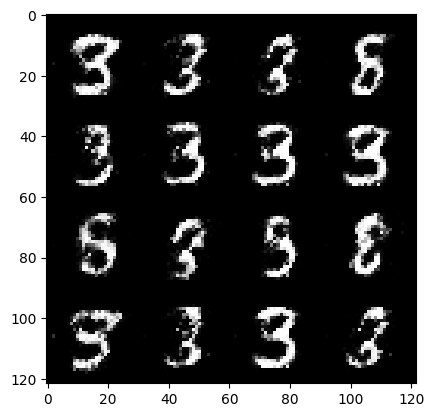

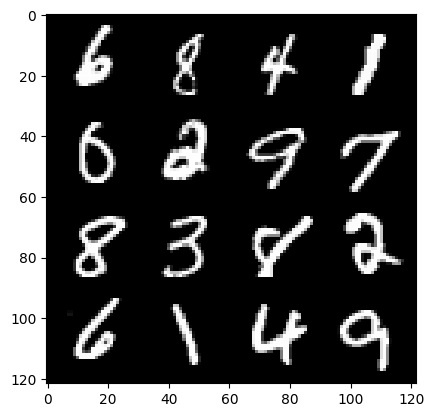

 39%|███▉      | 184/469 [00:02<00:04, 62.77it/s]

50: step 25800 / Gen loss: 4.967179711659749 / disc_loss: 0.06814250389114025


  0%|          | 0/469 [00:00<?, ?it/s]

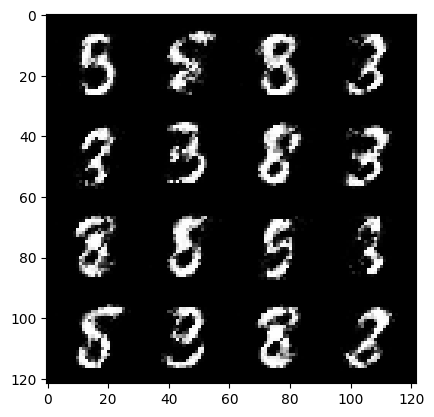

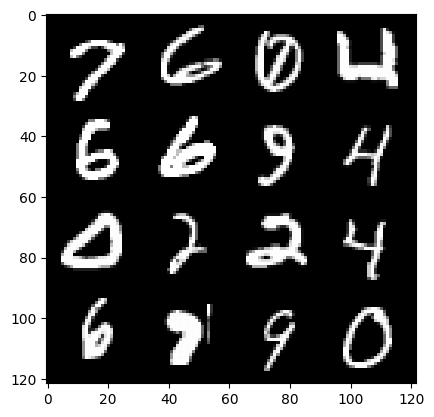

  2%|▏         | 11/469 [00:00<00:10, 45.71it/s]

51: step 26100 / Gen loss: 4.944244094689685 / disc_loss: 0.08119177825748919


 64%|██████▎   | 298/469 [00:04<00:02, 72.51it/s]

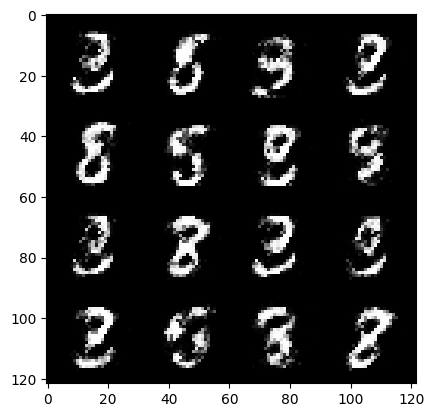

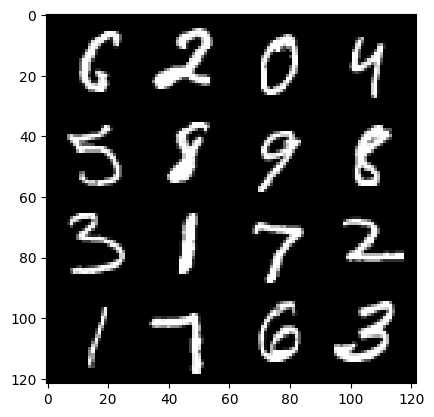

 67%|██████▋   | 313/469 [00:04<00:02, 60.45it/s]

51: step 26400 / Gen loss: 4.8221858565012585 / disc_loss: 0.07791055242220561


 27%|██▋       | 128/469 [00:01<00:04, 73.94it/s]

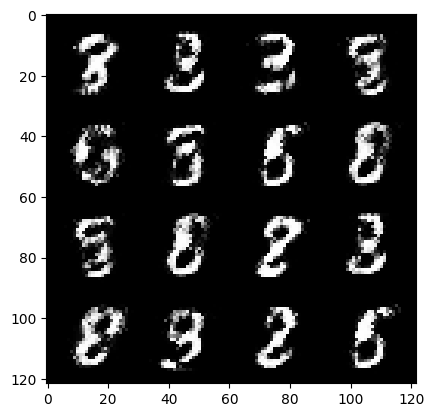

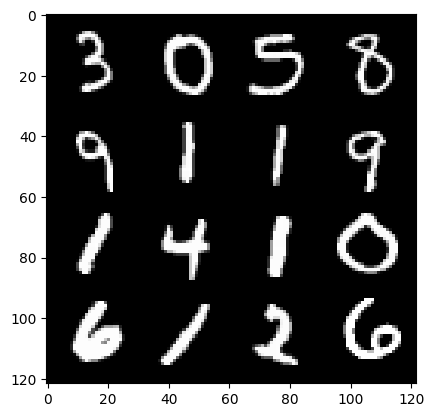

 30%|███       | 143/469 [00:02<00:05, 61.88it/s]

52: step 26700 / Gen loss: 5.042463455994921 / disc_loss: 0.06648191347097361


 92%|█████████▏| 433/469 [00:06<00:00, 66.04it/s]

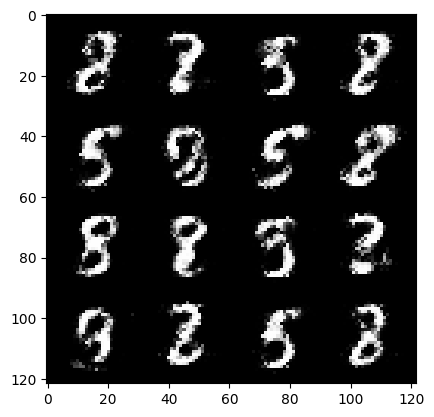

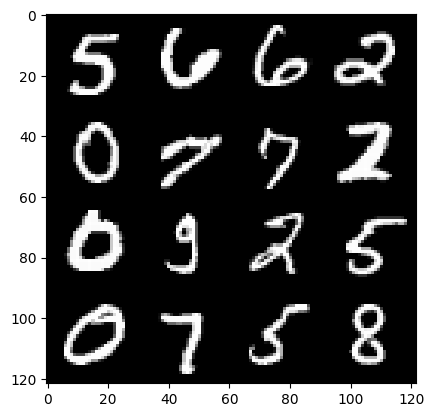

 95%|█████████▌| 447/469 [00:06<00:00, 56.59it/s]

52: step 27000 / Gen loss: 5.056162395477293 / disc_loss: 0.08271932619934277


 56%|█████▌    | 261/469 [00:03<00:03, 68.11it/s]

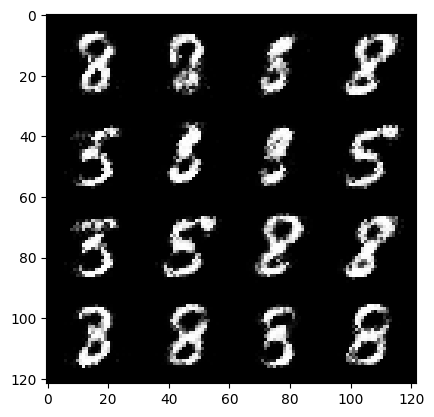

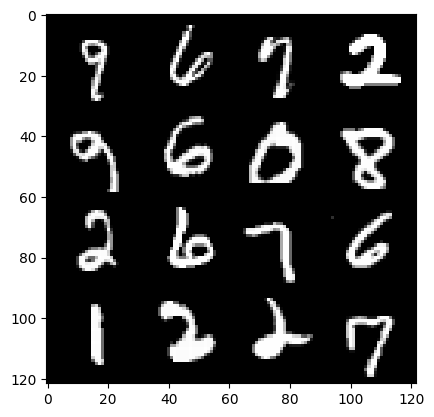

 59%|█████▊    | 275/469 [00:04<00:03, 59.40it/s]

53: step 27300 / Gen loss: 4.799222607612608 / disc_loss: 0.07909464973335473


 20%|██        | 96/469 [00:01<00:04, 77.25it/s]

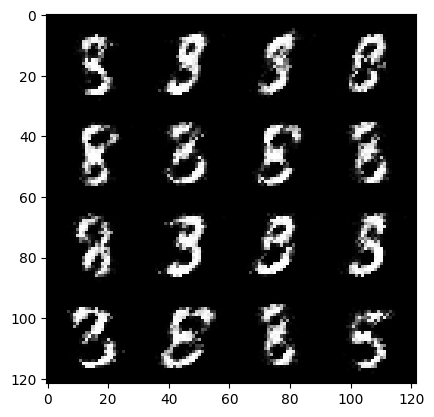

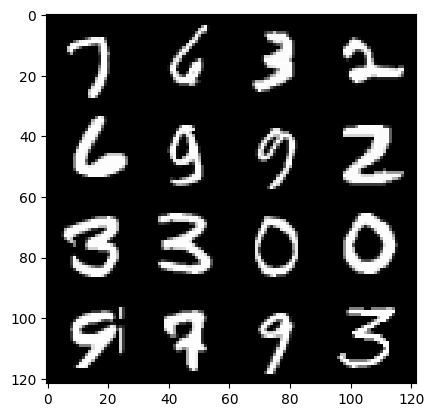

 24%|██▍       | 112/469 [00:01<00:05, 65.77it/s]

54: step 27600 / Gen loss: 4.4540411615371704 / disc_loss: 0.10115305950244274


 84%|████████▍ | 393/469 [00:05<00:01, 66.45it/s]

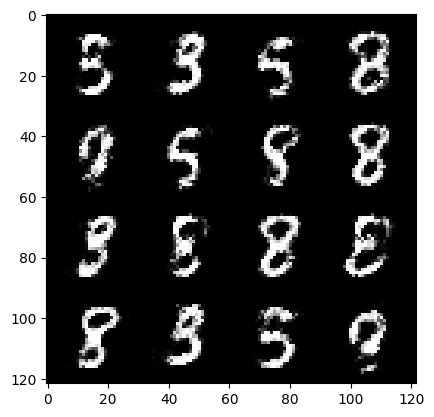

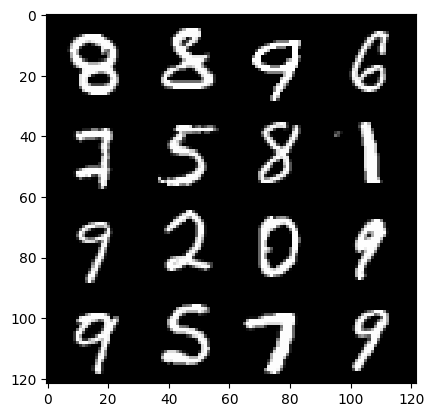

 87%|████████▋ | 407/469 [00:05<00:01, 59.22it/s]

54: step 27900 / Gen loss: 4.398201162020364 / disc_loss: 0.0883030265321334


 49%|████▊     | 228/469 [00:03<00:03, 74.08it/s]

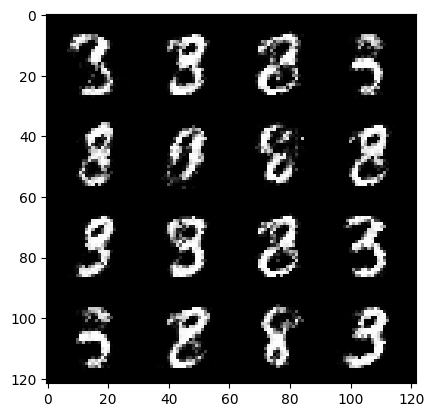

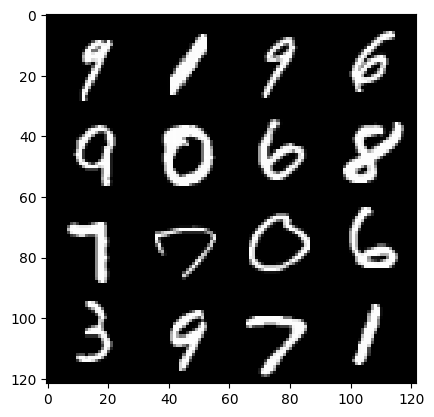

 52%|█████▏    | 243/469 [00:03<00:03, 63.48it/s]

55: step 28200 / Gen loss: 4.5196273581186945 / disc_loss: 0.08672175971791153


 12%|█▏        | 56/469 [00:00<00:05, 75.39it/s]

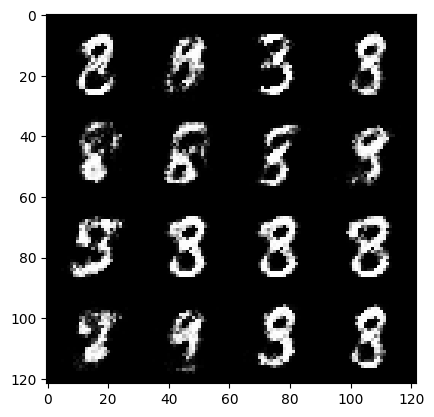

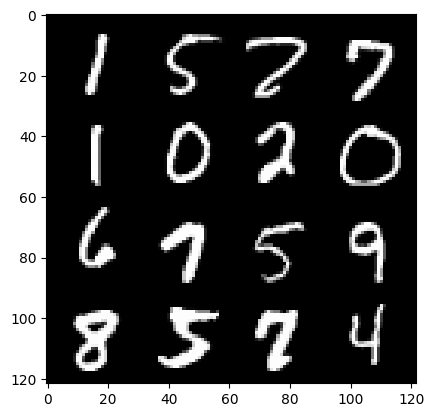

 15%|█▌        | 71/469 [00:01<00:06, 63.51it/s]

56: step 28500 / Gen loss: 4.43510449409485 / disc_loss: 0.09979372153679525


 76%|███████▌  | 355/469 [00:04<00:01, 74.32it/s]

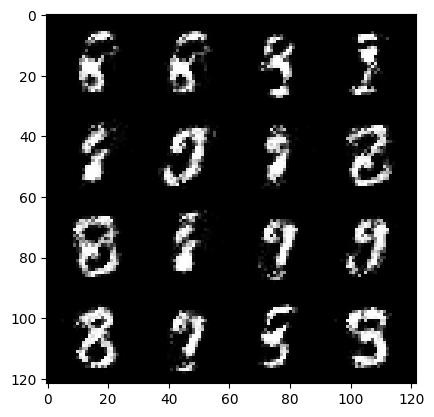

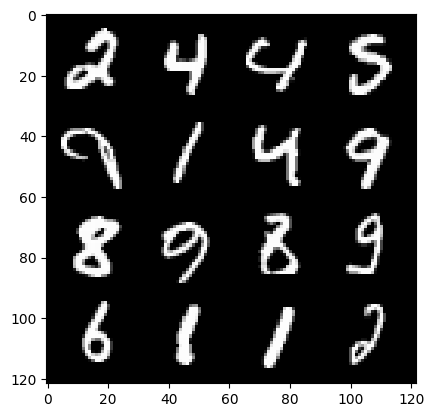

 79%|███████▉  | 371/469 [00:05<00:01, 64.98it/s]

56: step 28800 / Gen loss: 4.4368537068367 / disc_loss: 0.09837353757272169


 39%|███▉      | 184/469 [00:02<00:03, 75.65it/s]

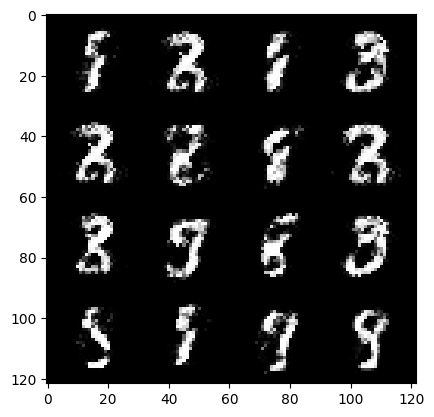

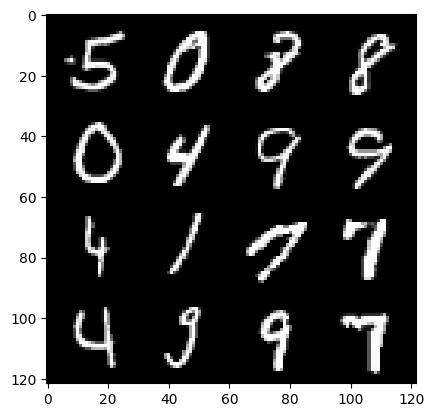

 42%|████▏     | 199/469 [00:02<00:04, 63.18it/s]

57: step 29100 / Gen loss: 4.635104488531748 / disc_loss: 0.09353936060021316


  3%|▎         | 16/469 [00:00<00:05, 76.77it/s]

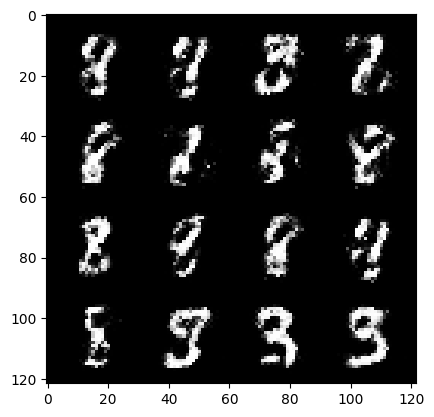

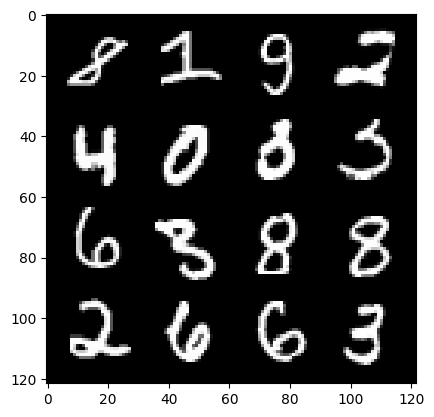

  7%|▋         | 31/469 [00:00<00:07, 61.75it/s]

58: step 29400 / Gen loss: 4.711418158213298 / disc_loss: 0.08297243548557166


 68%|██████▊   | 317/469 [00:04<00:01, 76.48it/s]

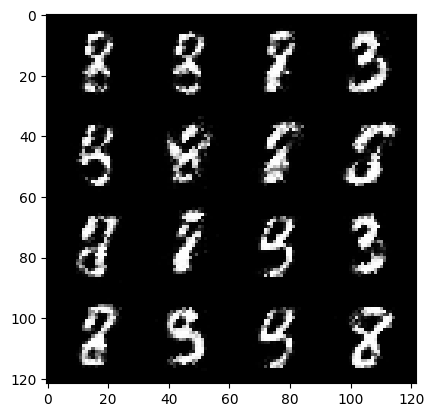

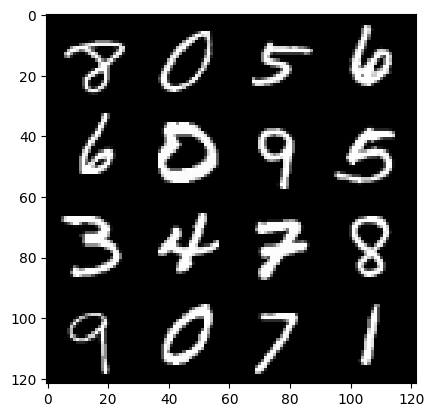

 71%|███████   | 333/469 [00:04<00:02, 65.12it/s]

58: step 29700 / Gen loss: 4.631728826363881 / disc_loss: 0.08068549759065108


 32%|███▏      | 152/469 [00:01<00:04, 76.80it/s]

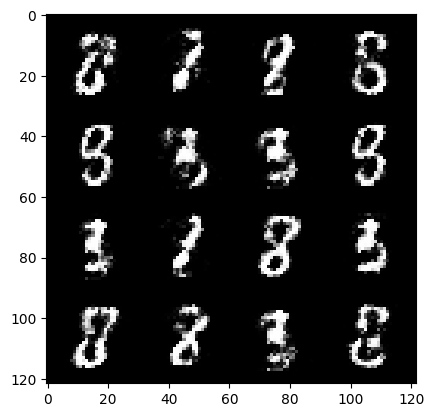

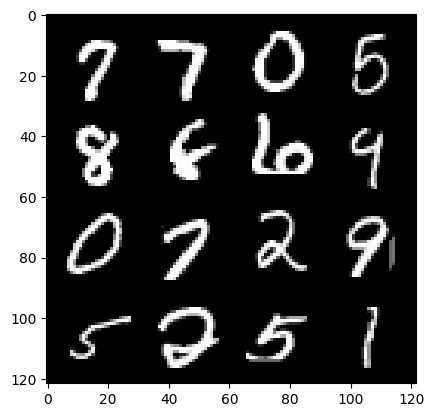

 36%|███▌      | 167/469 [00:02<00:04, 64.40it/s]

59: step 30000 / Gen loss: 4.56790992975235 / disc_loss: 0.10180321777860327


 95%|█████████▌| 446/469 [00:05<00:00, 75.72it/s]

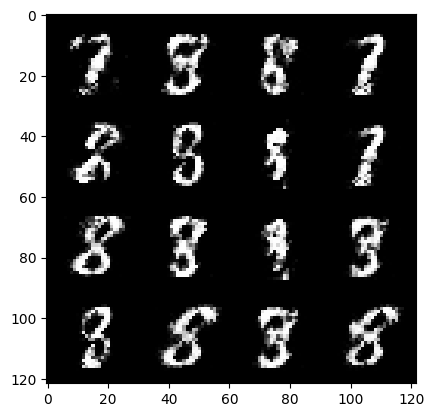

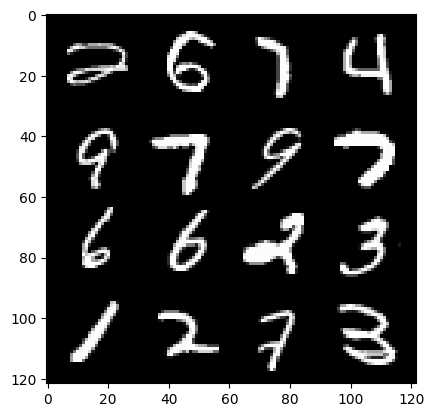

 98%|█████████▊| 461/469 [00:06<00:00, 62.38it/s]

59: step 30300 / Gen loss: 4.420413806438443 / disc_loss: 0.10102325805773339


 59%|█████▉    | 277/469 [00:03<00:02, 70.46it/s]

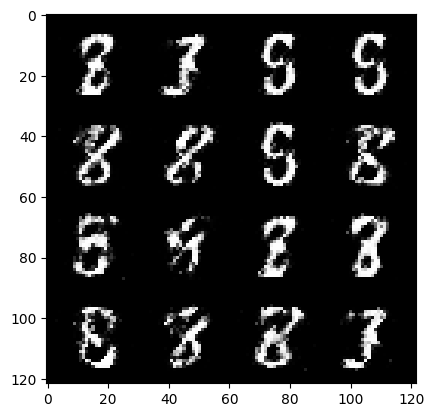

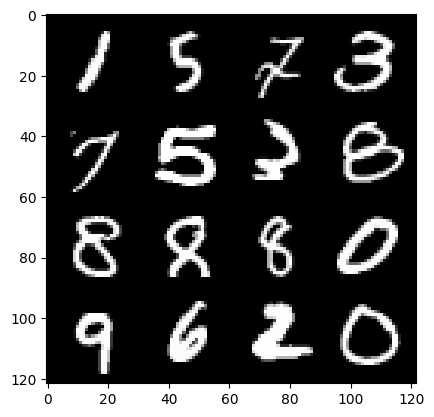

 62%|██████▏   | 292/469 [00:04<00:02, 60.19it/s]

60: step 30600 / Gen loss: 4.469321215947466 / disc_loss: 0.0869414725030462


 23%|██▎       | 109/469 [00:01<00:05, 69.79it/s]

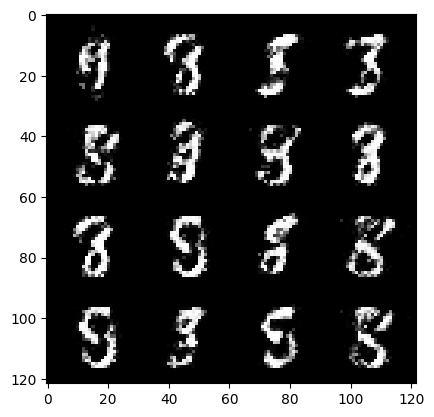

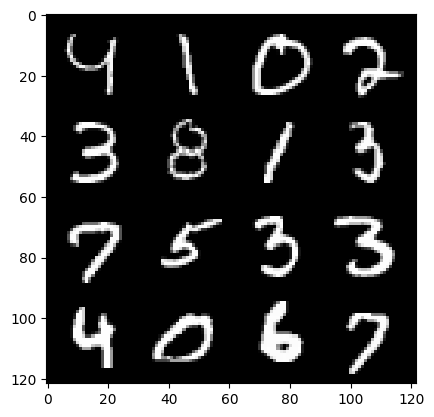

 26%|██▌       | 123/469 [00:01<00:05, 59.11it/s]

61: step 30900 / Gen loss: 4.5139162445068335 / disc_loss: 0.08729758751268189


 88%|████████▊ | 413/469 [00:05<00:00, 71.89it/s]

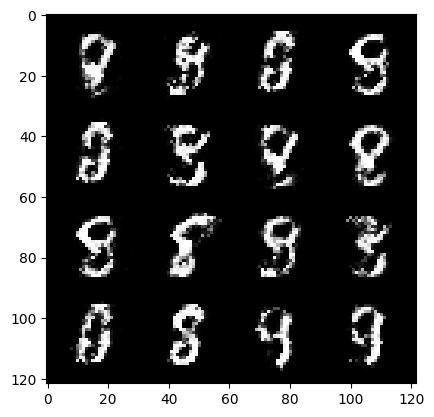

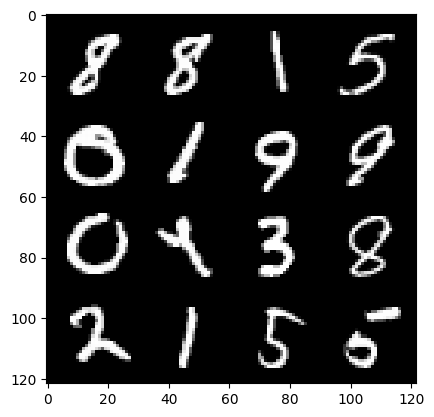

 91%|█████████▏| 428/469 [00:06<00:00, 61.96it/s]

61: step 31200 / Gen loss: 4.441189272403713 / disc_loss: 0.10346550519267719


 51%|█████     | 238/469 [00:03<00:03, 70.08it/s]

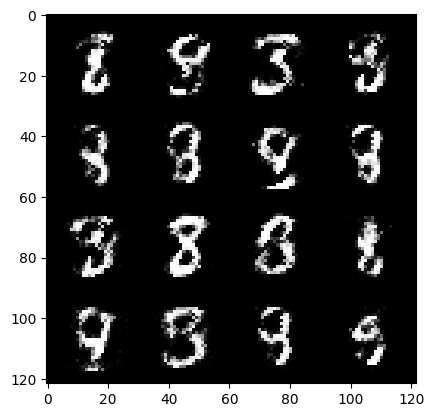

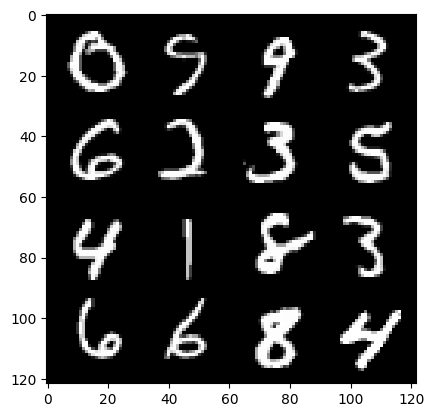

 54%|█████▍    | 254/469 [00:03<00:03, 61.97it/s]

62: step 31500 / Gen loss: 4.533424584865563 / disc_loss: 0.10350757993757725


 15%|█▌        | 72/469 [00:00<00:05, 76.69it/s]

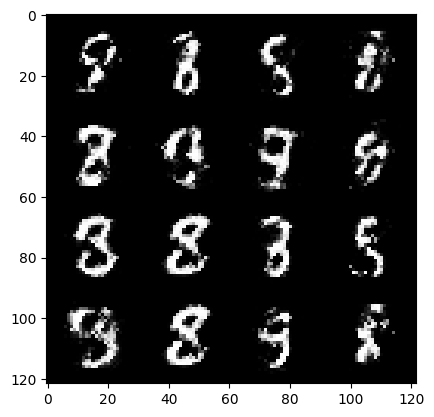

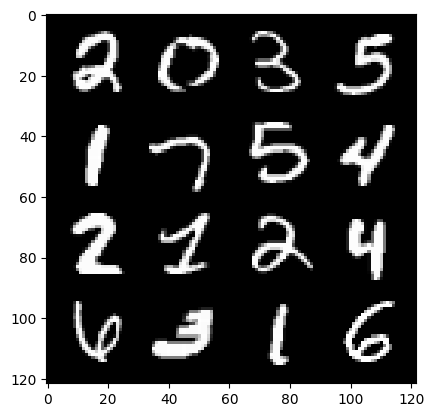

 19%|█▉        | 88/469 [00:01<00:06, 59.45it/s]

63: step 31800 / Gen loss: 4.603607695897425 / disc_loss: 0.09515229190389322


 80%|███████▉  | 375/469 [00:05<00:01, 76.50it/s]

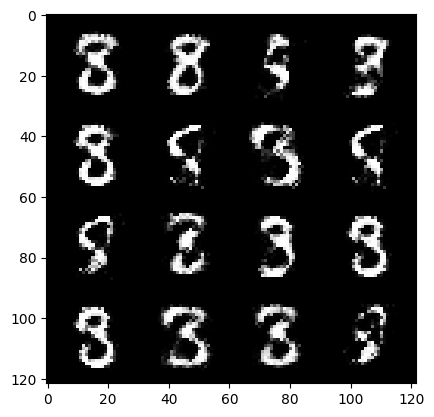

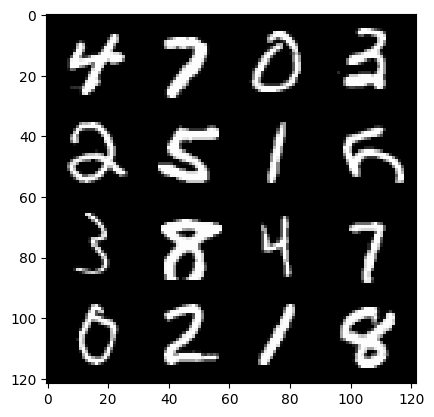

 83%|████████▎ | 391/469 [00:05<00:01, 65.01it/s]

63: step 32100 / Gen loss: 4.34842851479848 / disc_loss: 0.0966330142195026


 43%|████▎     | 200/469 [00:02<00:03, 75.77it/s]

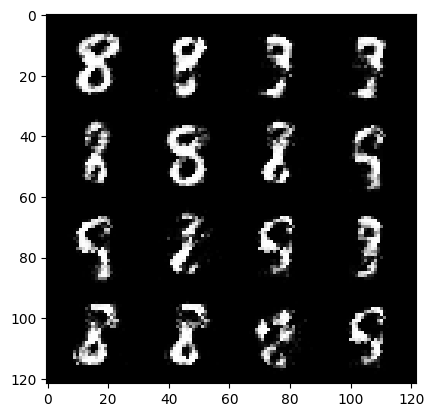

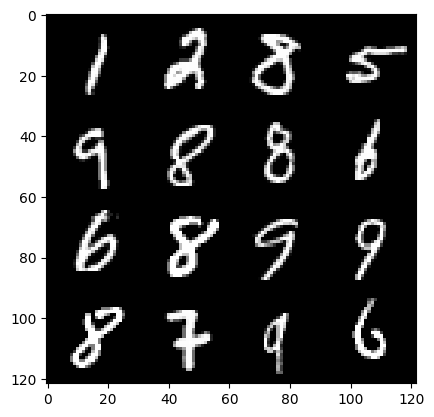

 46%|████▌     | 215/469 [00:02<00:04, 62.84it/s]

64: step 32400 / Gen loss: 4.426271464029954 / disc_loss: 0.08757334208736826


  7%|▋         | 32/469 [00:00<00:05, 75.81it/s]

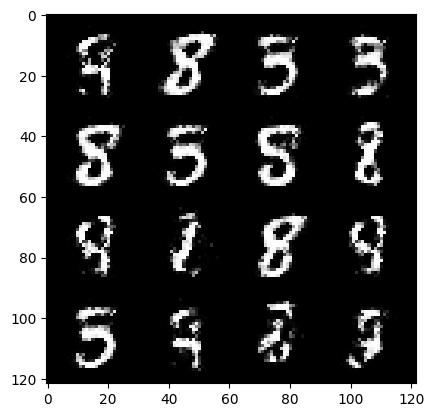

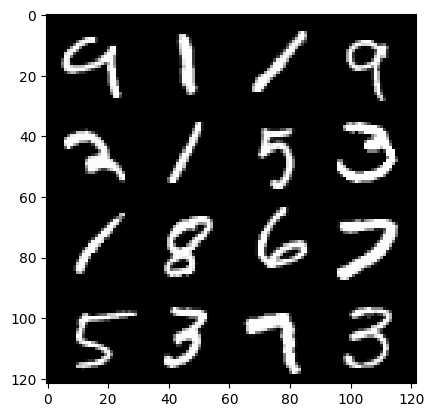

 10%|█         | 47/469 [00:00<00:06, 62.32it/s]

65: step 32700 / Gen loss: 4.338526615301767 / disc_loss: 0.11021298093100389


 71%|███████▏  | 335/469 [00:04<00:01, 75.65it/s]

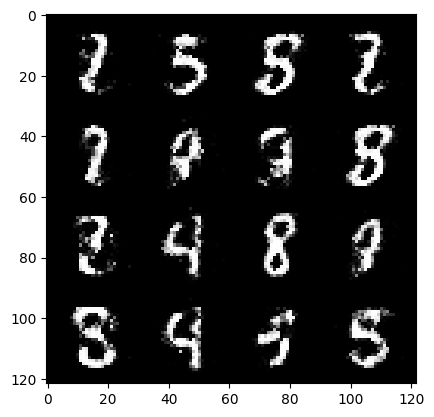

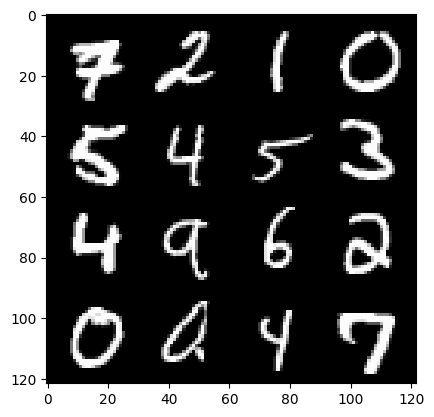

 75%|███████▍  | 350/469 [00:04<00:01, 63.99it/s]

65: step 33000 / Gen loss: 4.249196288585665 / disc_loss: 0.11157152617971108


 36%|███▌      | 168/469 [00:02<00:03, 76.67it/s]

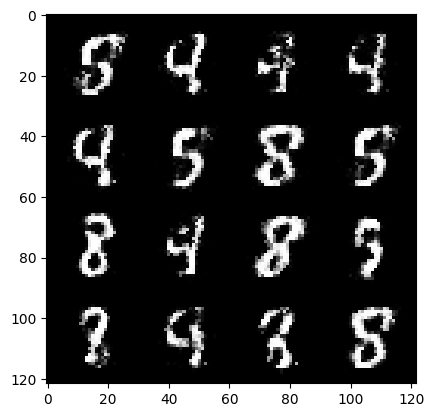

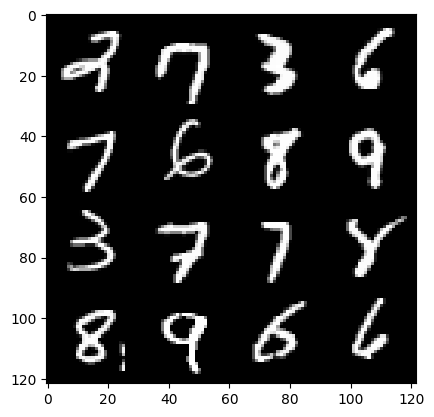

 39%|███▉      | 184/469 [00:02<00:04, 65.90it/s]

66: step 33300 / Gen loss: 4.2868394184112555 / disc_loss: 0.10240981366485363


  0%|          | 0/469 [00:00<?, ?it/s]

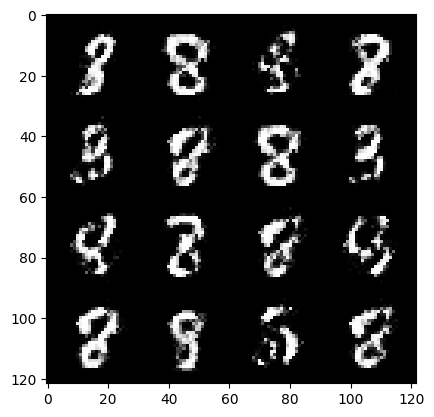

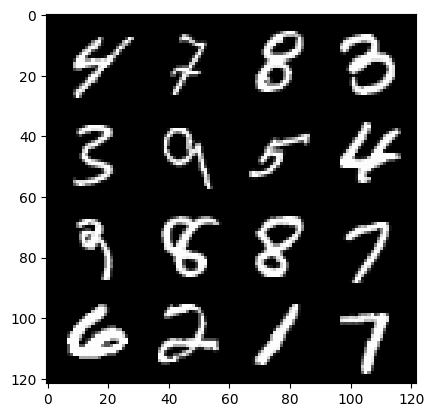

  2%|▏         | 11/469 [00:00<00:08, 53.44it/s]

67: step 33600 / Gen loss: 4.278764093716937 / disc_loss: 0.11192878028998773


 64%|██████▍   | 299/469 [00:03<00:02, 76.92it/s]

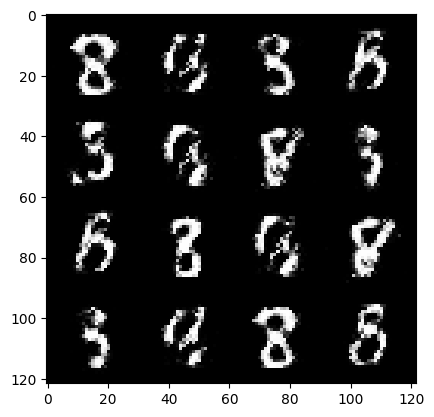

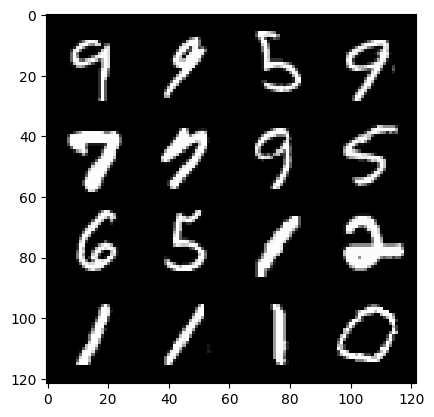

 67%|██████▋   | 315/469 [00:04<00:02, 66.95it/s]

67: step 33900 / Gen loss: 4.078789107004803 / disc_loss: 0.12857685872664057


 27%|██▋       | 128/469 [00:01<00:04, 76.30it/s]

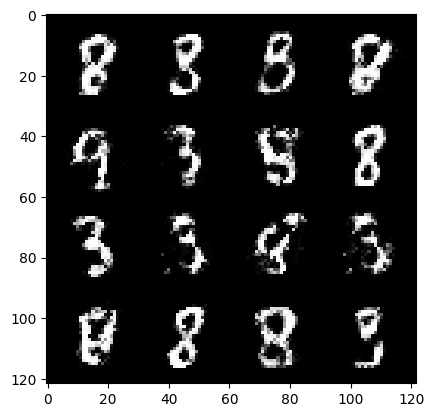

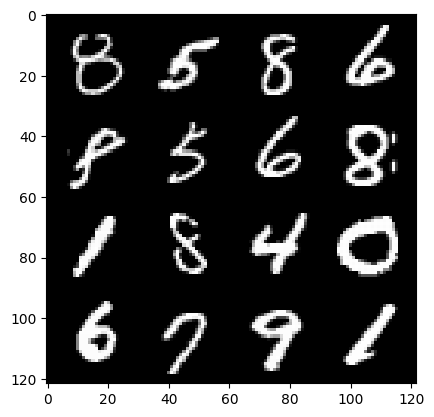

 31%|███       | 144/469 [00:01<00:04, 65.67it/s]

68: step 34200 / Gen loss: 4.294141956965129 / disc_loss: 0.11212437073389687


 92%|█████████▏| 431/469 [00:05<00:00, 76.67it/s]

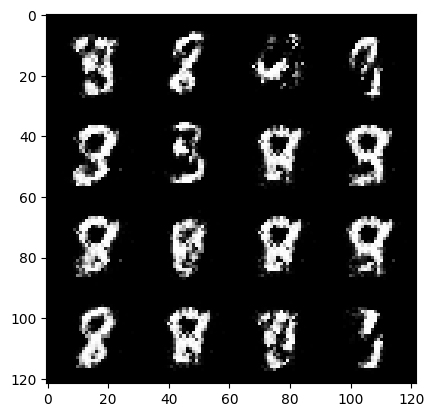

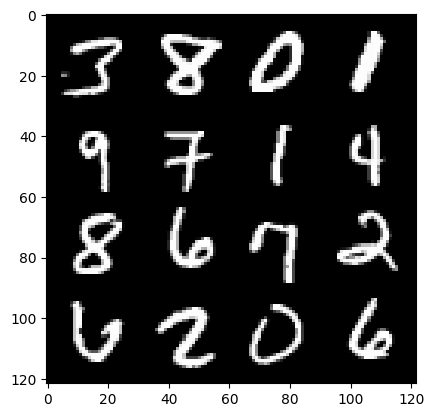

 94%|█████████▎| 439/469 [00:05<00:00, 62.16it/s]

68: step 34500 / Gen loss: 4.199828356107078 / disc_loss: 0.11586222827434538


 55%|█████▍    | 256/469 [00:03<00:02, 76.06it/s]

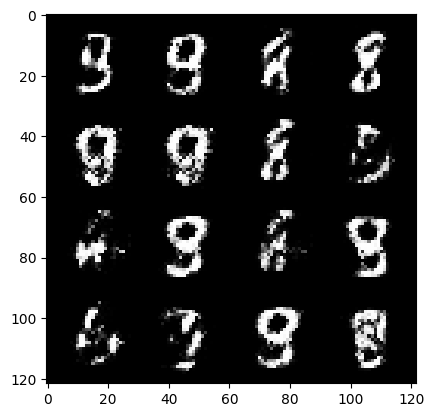

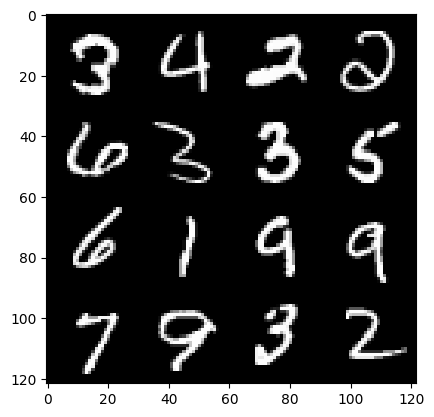

 58%|█████▊    | 271/469 [00:03<00:03, 64.05it/s]

69: step 34800 / Gen loss: 4.357322146097814 / disc_loss: 0.10807144235819584


 19%|█▉        | 88/469 [00:01<00:05, 75.33it/s]

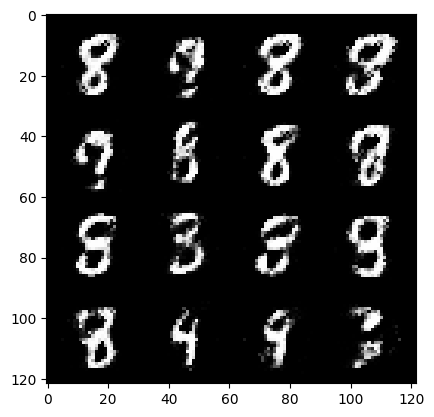

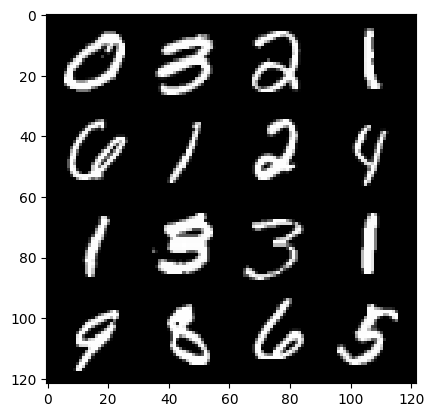

 22%|██▏       | 104/469 [00:01<00:05, 64.66it/s]

70: step 35100 / Gen loss: 4.262739813327791 / disc_loss: 0.11454516722510263


 83%|████████▎ | 391/469 [00:05<00:01, 75.14it/s]

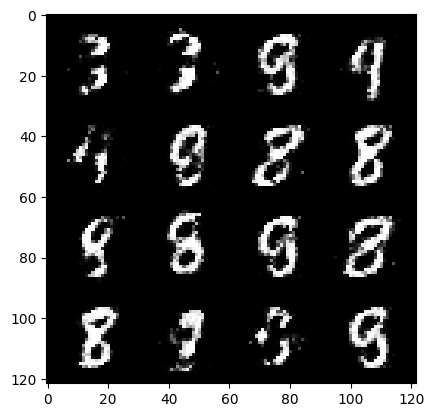

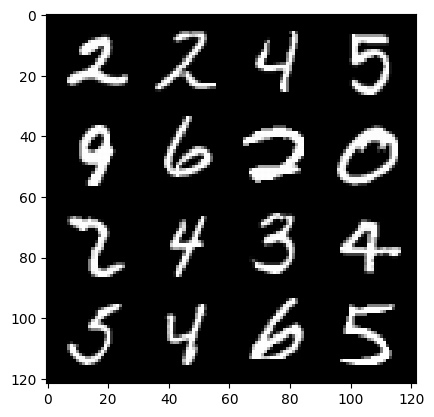

 87%|████████▋ | 407/469 [00:05<00:00, 64.48it/s]

70: step 35400 / Gen loss: 4.125038346449538 / disc_loss: 0.12305861974755924


 48%|████▊     | 224/469 [00:02<00:03, 76.32it/s]

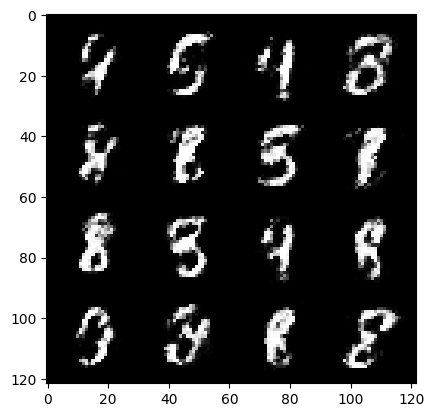

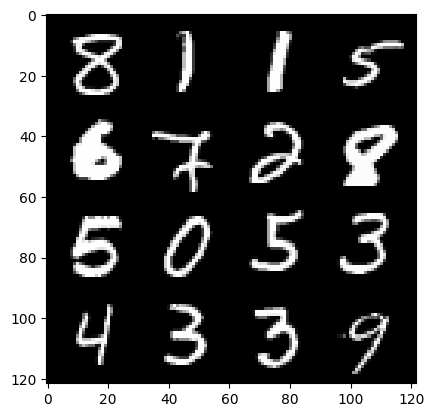

 49%|████▉     | 232/469 [00:03<00:03, 60.75it/s]

71: step 35700 / Gen loss: 3.912394065856936 / disc_loss: 0.13719337190190942


 10%|█         | 48/469 [00:00<00:05, 77.46it/s]

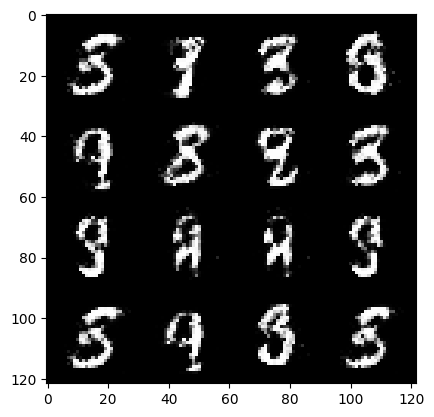

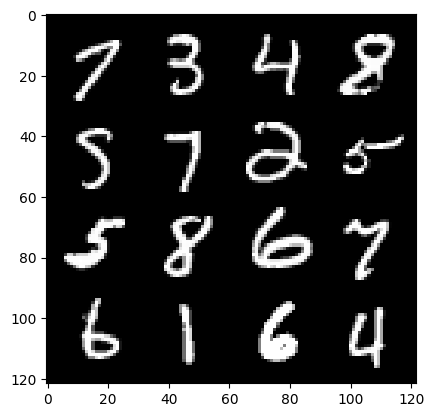

 14%|█▎        | 64/469 [00:00<00:06, 66.98it/s]

72: step 36000 / Gen loss: 3.997356345653532 / disc_loss: 0.10439245498428737


 75%|███████▌  | 352/469 [00:04<00:01, 76.94it/s]

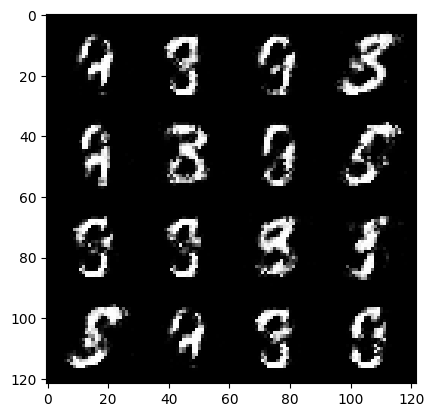

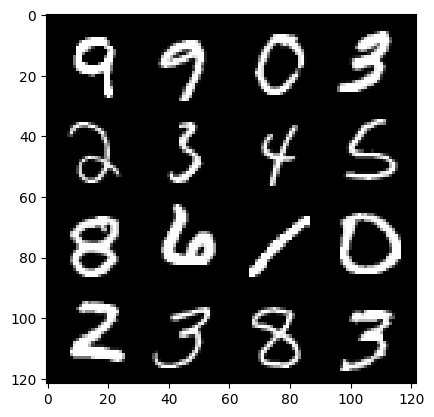

 78%|███████▊  | 368/469 [00:04<00:01, 65.75it/s]

72: step 36300 / Gen loss: 4.184902807076773 / disc_loss: 0.11048153406629957


 38%|███▊      | 179/469 [00:02<00:04, 70.36it/s]

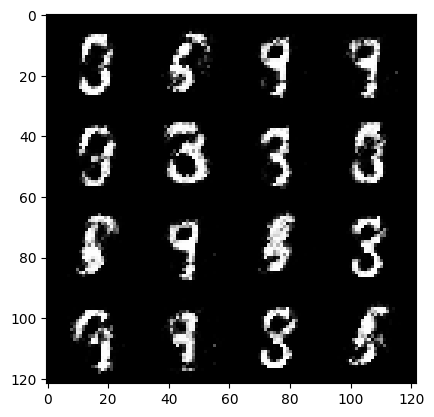

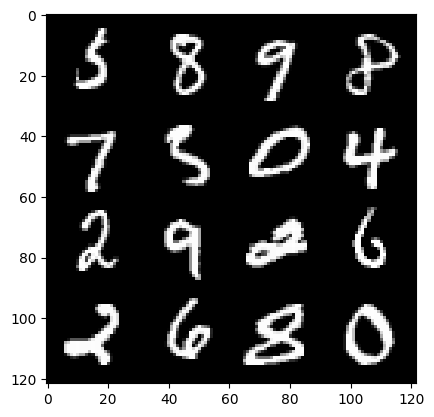

 42%|████▏     | 195/469 [00:02<00:04, 61.09it/s]

73: step 36600 / Gen loss: 3.973588861624397 / disc_loss: 0.11458922012398641


  3%|▎         | 16/469 [00:00<00:06, 74.26it/s]

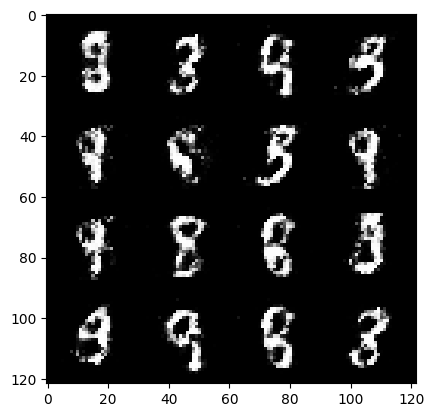

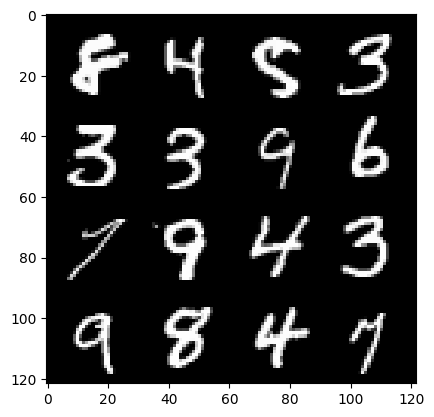

  7%|▋         | 31/469 [00:00<00:07, 60.71it/s]

74: step 36900 / Gen loss: 4.083616335391998 / disc_loss: 0.11956728159139553


 66%|██████▋   | 311/469 [00:04<00:02, 69.70it/s]

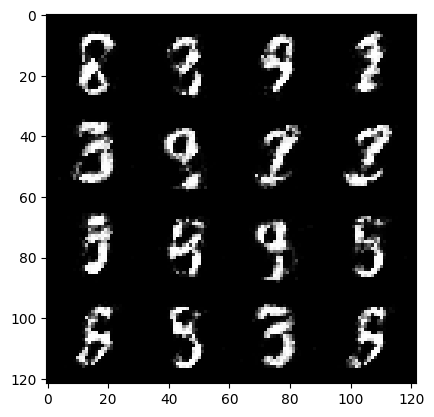

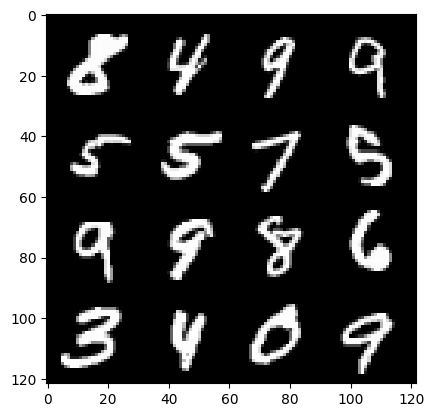

 69%|██████▉   | 325/469 [00:04<00:02, 61.69it/s]

74: step 37200 / Gen loss: 3.9410065746307357 / disc_loss: 0.1396331992000342


 30%|███       | 142/469 [00:02<00:04, 68.99it/s]

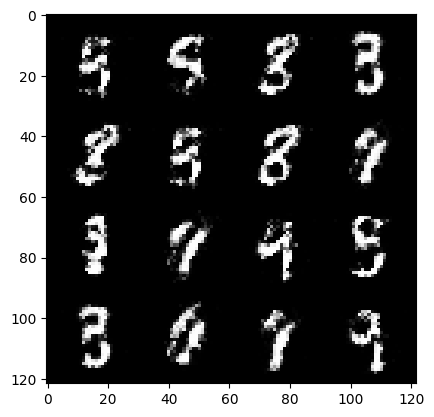

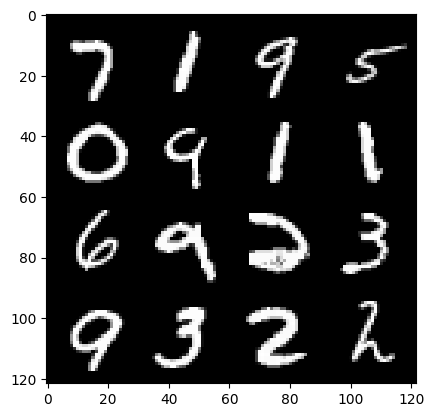

 33%|███▎      | 156/469 [00:02<00:05, 60.52it/s]

75: step 37500 / Gen loss: 3.7094272915522253 / disc_loss: 0.15014303604761767


 94%|█████████▍| 441/469 [00:06<00:00, 74.13it/s]

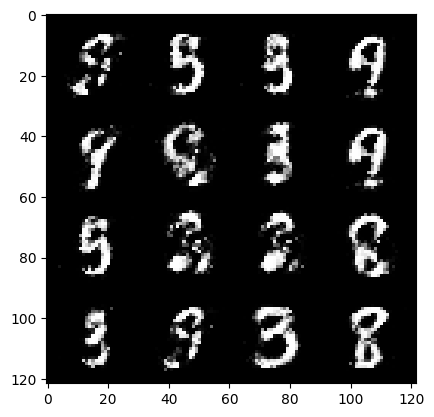

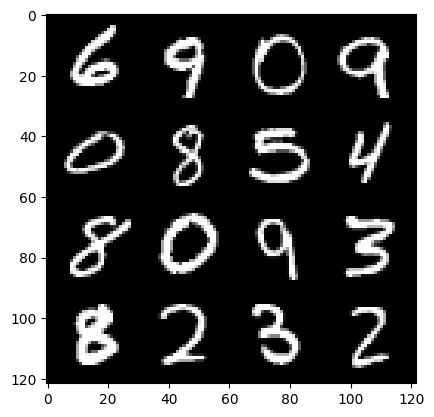

 97%|█████████▋| 457/469 [00:06<00:00, 63.85it/s]

75: step 37800 / Gen loss: 3.680014963944751 / disc_loss: 0.13803797310839092


 58%|█████▊    | 274/469 [00:03<00:02, 69.80it/s]

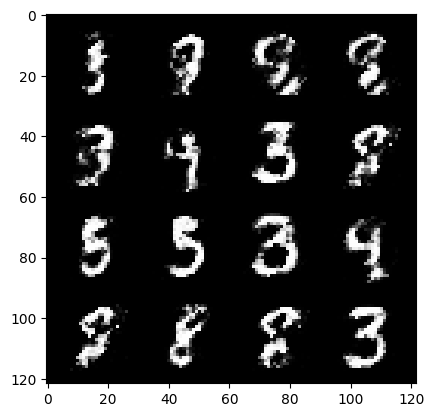

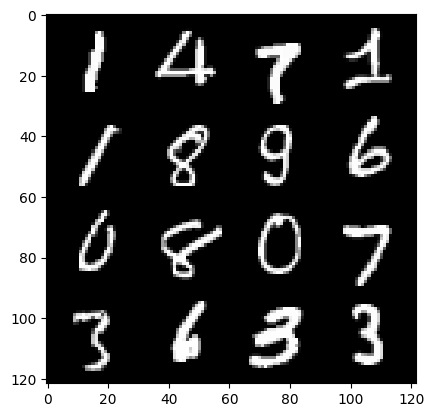

 61%|██████▏   | 288/469 [00:04<00:03, 58.98it/s]

76: step 38100 / Gen loss: 3.9127432338396697 / disc_loss: 0.12564909727623064


 22%|██▏       | 105/469 [00:01<00:05, 64.71it/s]

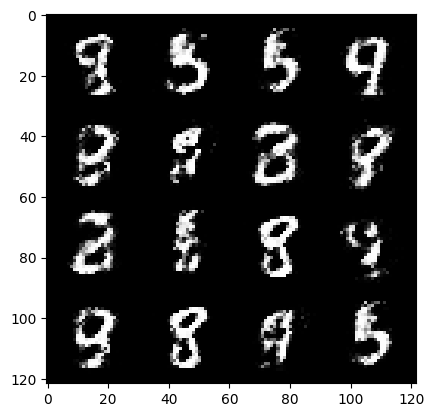

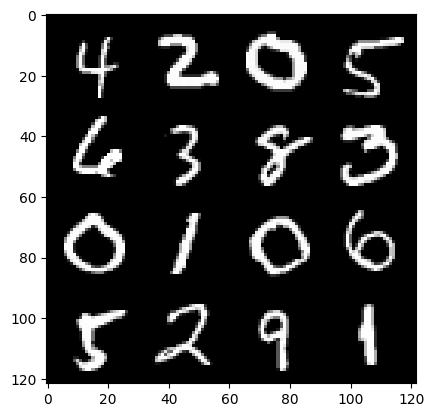

 25%|██▌       | 119/469 [00:01<00:06, 56.93it/s]

77: step 38400 / Gen loss: 3.7227646986643497 / disc_loss: 0.138452851648132


 86%|████████▌ | 404/469 [00:06<00:00, 68.40it/s]

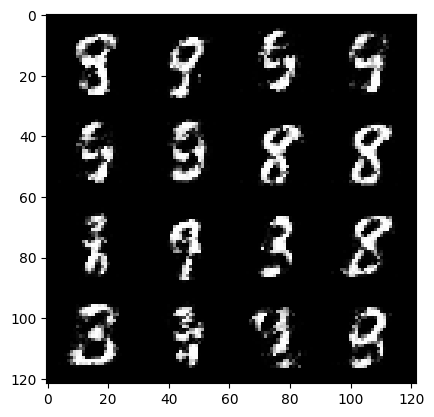

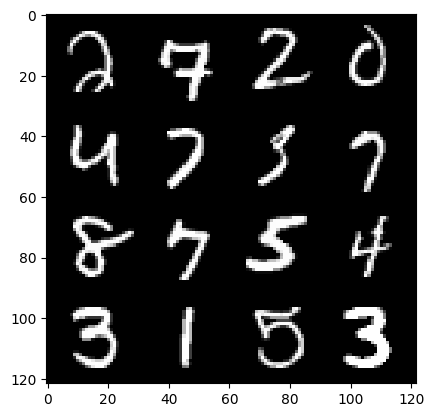

 89%|████████▉ | 418/469 [00:06<00:00, 60.89it/s]

77: step 38700 / Gen loss: 3.6301705257097887 / disc_loss: 0.13920395580430828


 50%|█████     | 236/469 [00:03<00:03, 74.09it/s]

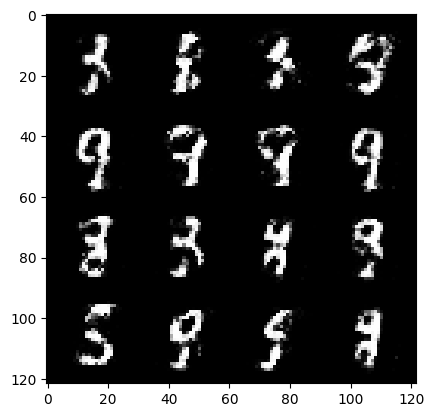

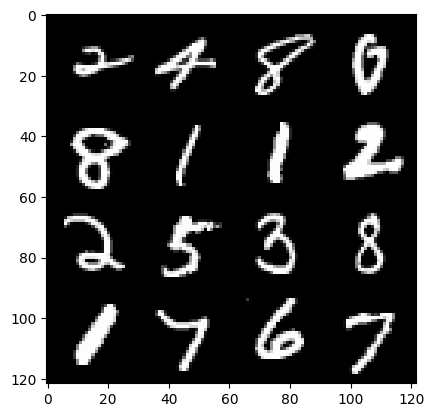

 54%|█████▎    | 252/469 [00:03<00:03, 64.07it/s]

78: step 39000 / Gen loss: 3.7233870927492765 / disc_loss: 0.1147907773281137


 15%|█▍        | 70/469 [00:01<00:06, 65.80it/s]

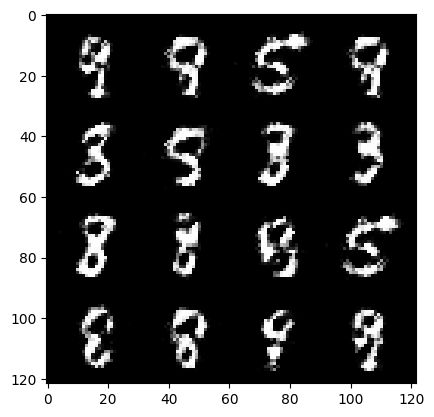

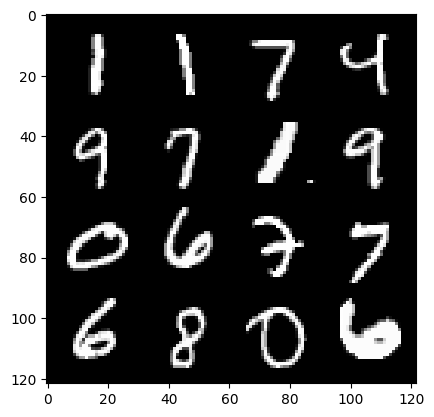

 18%|█▊        | 83/469 [00:01<00:06, 55.52it/s]

79: step 39300 / Gen loss: 3.7287043555577575 / disc_loss: 0.12357096939037251


 79%|███████▊  | 369/469 [00:05<00:01, 67.49it/s]

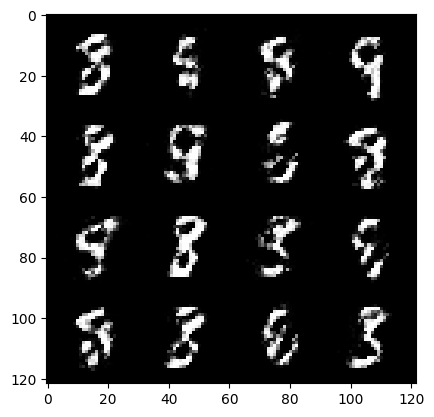

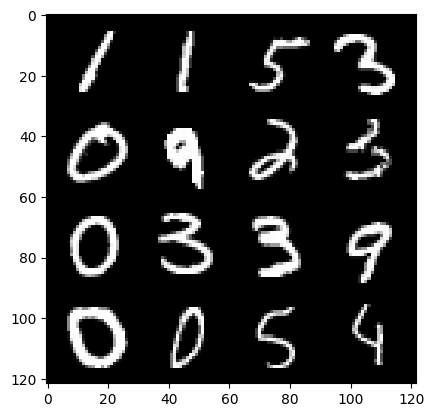

 82%|████████▏ | 384/469 [00:05<00:01, 59.38it/s]

79: step 39600 / Gen loss: 3.7001597078641266 / disc_loss: 0.12968092948198318


 42%|████▏     | 199/469 [00:02<00:03, 70.25it/s]

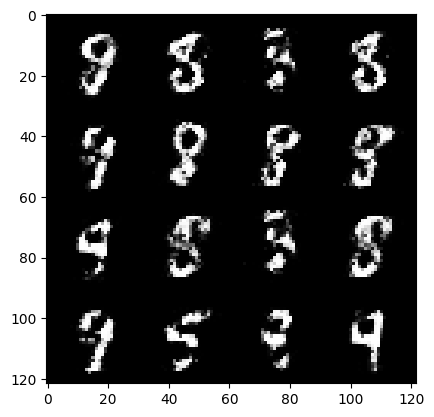

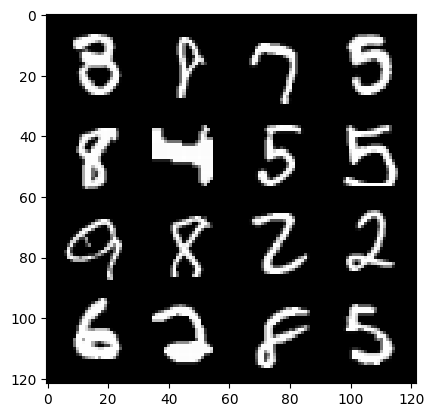

 46%|████▌     | 215/469 [00:03<00:04, 55.29it/s]

80: step 39900 / Gen loss: 3.7707110253969818 / disc_loss: 0.1436991886794567


  7%|▋         | 32/469 [00:00<00:06, 72.10it/s]

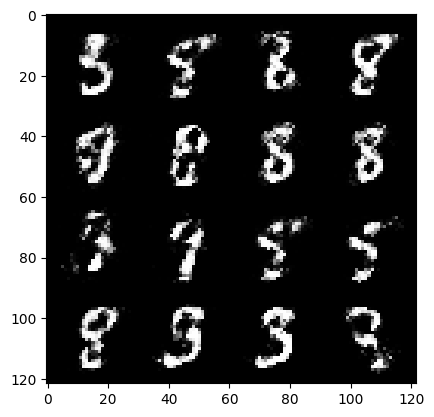

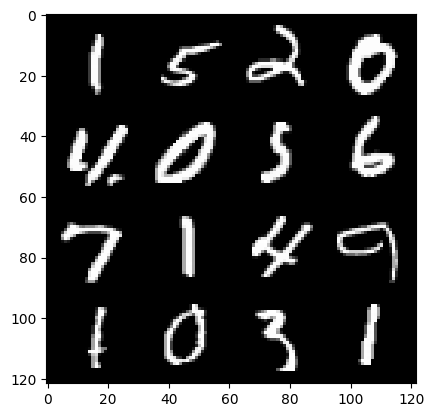

 10%|█         | 48/469 [00:00<00:06, 61.55it/s]

81: step 40200 / Gen loss: 3.7108832287788407 / disc_loss: 0.14284127276390776


 70%|██████▉   | 327/469 [00:04<00:01, 73.98it/s]

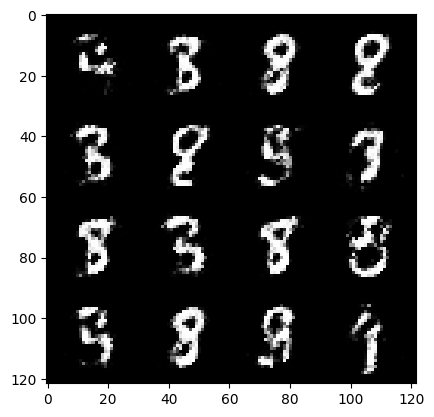

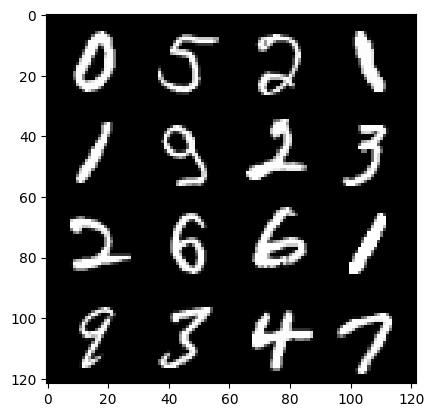

 73%|███████▎  | 343/469 [00:04<00:01, 64.56it/s]

81: step 40500 / Gen loss: 3.7147555526097604 / disc_loss: 0.13235777065157894


 34%|███▍      | 160/469 [00:02<00:04, 73.64it/s]

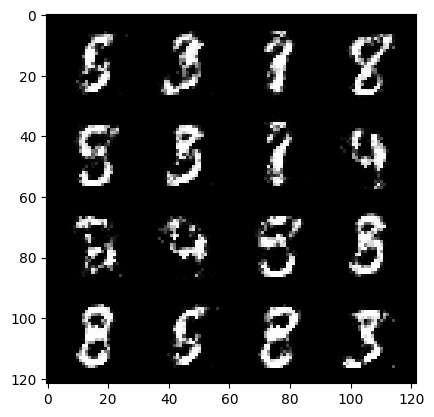

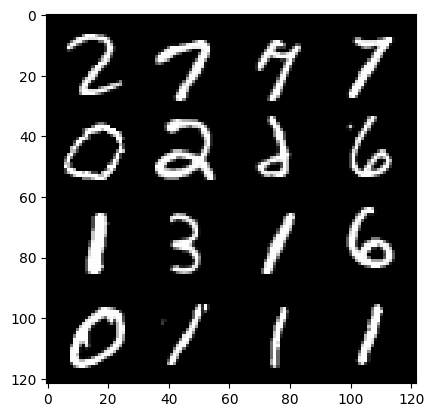

 37%|███▋      | 175/469 [00:02<00:04, 62.33it/s]

82: step 40800 / Gen loss: 3.583096322218577 / disc_loss: 0.14670524818201866


 99%|█████████▊| 462/469 [00:06<00:00, 73.76it/s]

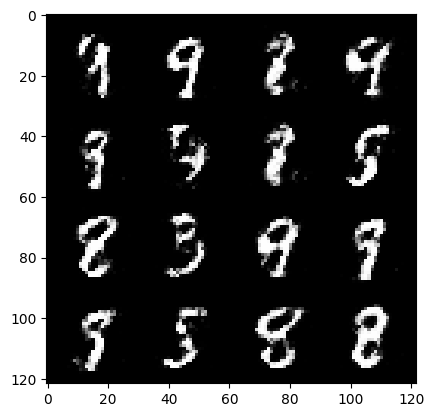

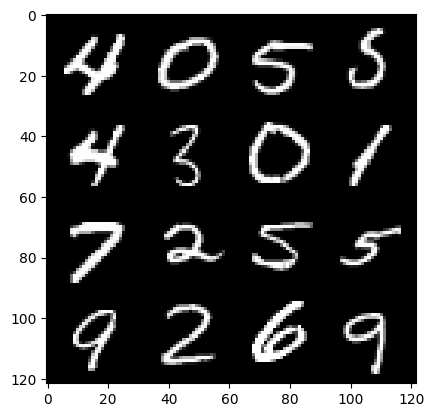

100%|██████████| 469/469 [00:06<00:00, 71.37it/s]


82: step 41100 / Gen loss: 3.5196644552548717 / disc_loss: 0.14015229783952232


 63%|██████▎   | 295/469 [00:04<00:02, 74.27it/s]

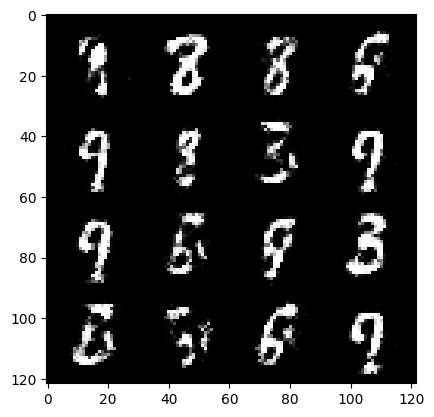

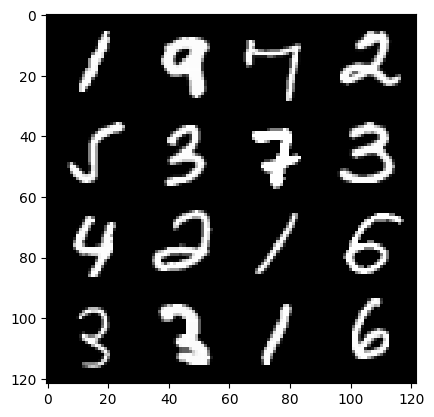

 66%|██████▋   | 311/469 [00:04<00:02, 64.06it/s]

83: step 41400 / Gen loss: 3.5444493333498683 / disc_loss: 0.15546507539848495


 26%|██▌       | 120/469 [00:01<00:04, 73.62it/s]

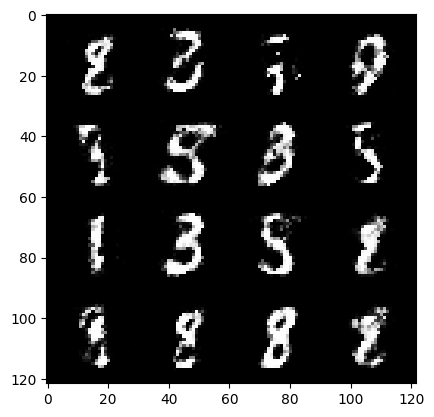

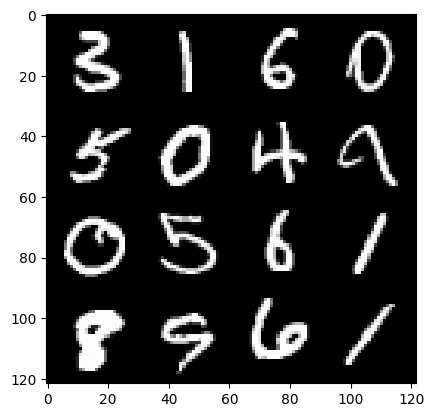

 29%|██▉       | 136/469 [00:01<00:05, 63.76it/s]

84: step 41700 / Gen loss: 3.469121760527293 / disc_loss: 0.14828092659513153


 91%|█████████ | 427/469 [00:05<00:00, 72.36it/s]

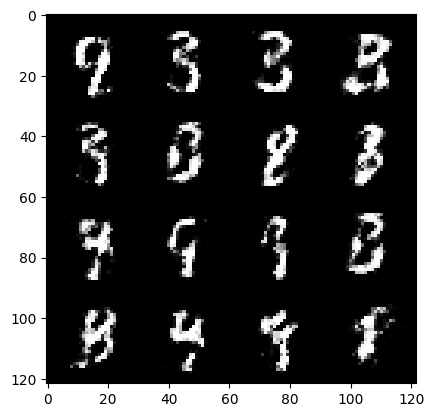

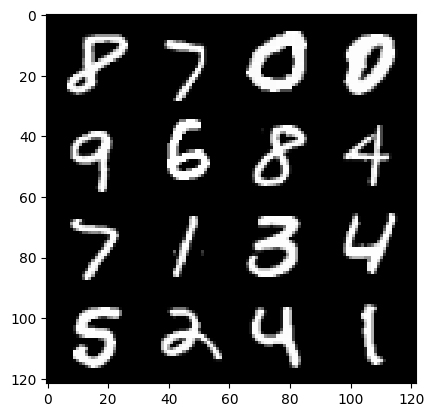

 93%|█████████▎| 435/469 [00:06<00:00, 59.95it/s]

84: step 42000 / Gen loss: 3.3969172016779625 / disc_loss: 0.15279752383629483


 55%|█████▍    | 256/469 [00:03<00:02, 74.14it/s]

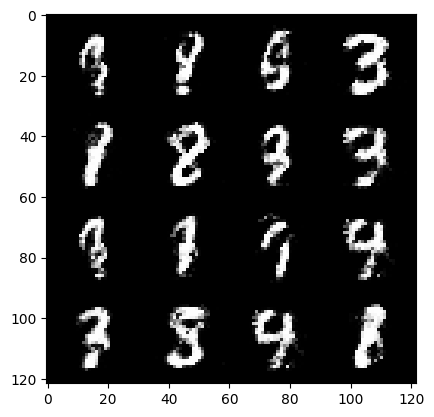

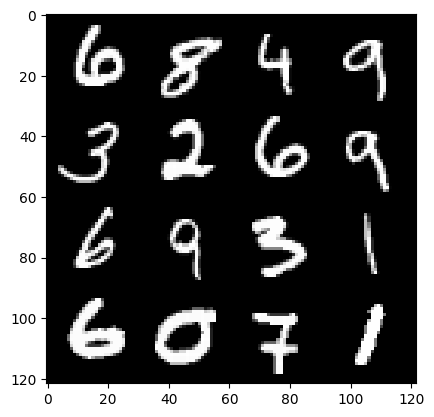

 58%|█████▊    | 272/469 [00:03<00:03, 64.40it/s]

85: step 42300 / Gen loss: 3.3430581903457646 / disc_loss: 0.1525788457194965


 19%|█▉        | 88/469 [00:01<00:05, 73.91it/s]

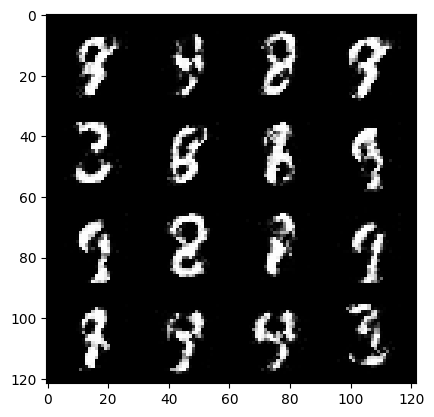

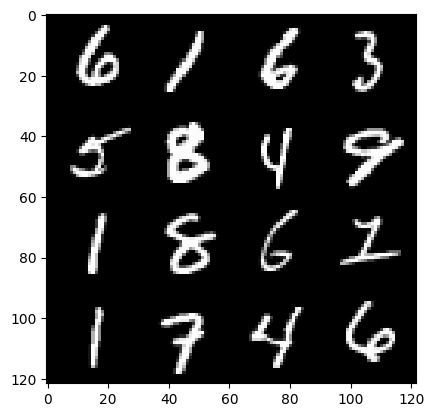

 20%|██        | 96/469 [00:01<00:06, 60.19it/s]

86: step 42600 / Gen loss: 3.635100919405616 / disc_loss: 0.13637878050406774


 82%|████████▏ | 383/469 [00:05<00:01, 74.87it/s]

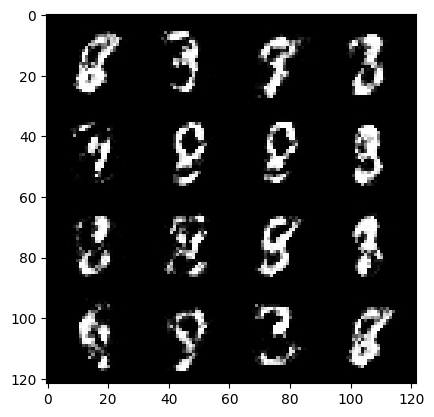

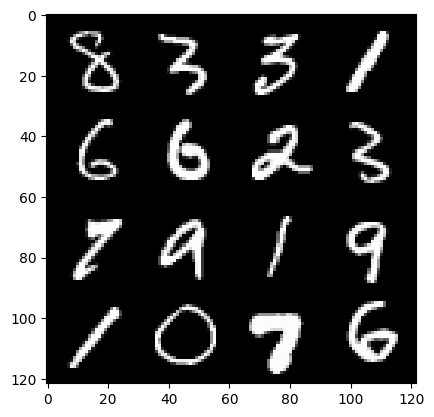

 85%|████████▍ | 398/469 [00:05<00:01, 62.64it/s]

86: step 42900 / Gen loss: 3.3608156808217364 / disc_loss: 0.16222363258401543


 46%|████▌     | 216/469 [00:02<00:03, 73.25it/s]

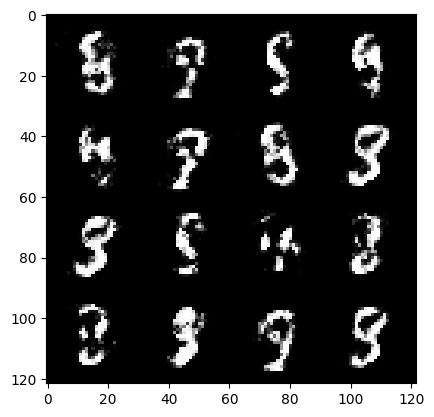

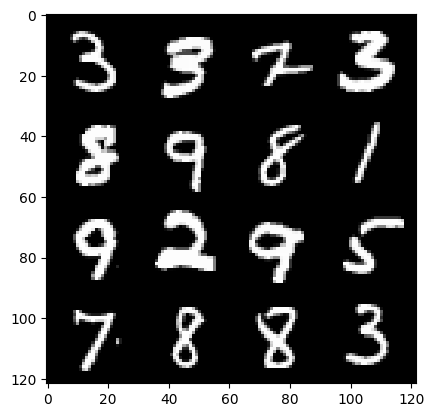

 49%|████▉     | 232/469 [00:03<00:03, 63.54it/s]

87: step 43200 / Gen loss: 3.4000965253512048 / disc_loss: 0.16751075451572733


 10%|█         | 48/469 [00:00<00:05, 71.89it/s]

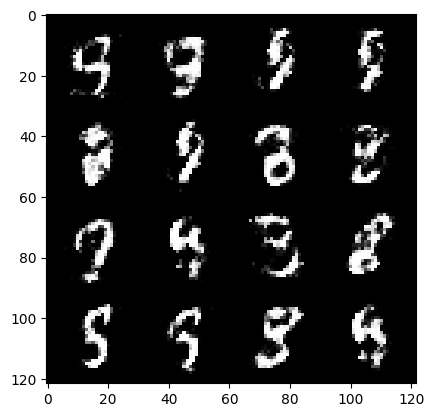

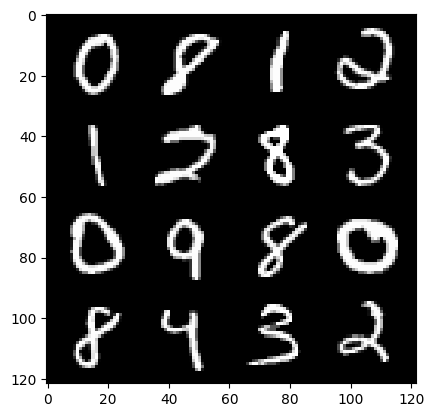

 13%|█▎        | 63/469 [00:00<00:06, 60.09it/s]

88: step 43500 / Gen loss: 3.4828709022204074 / disc_loss: 0.13732369186977553


 75%|███████▍  | 350/469 [00:04<00:01, 73.29it/s]

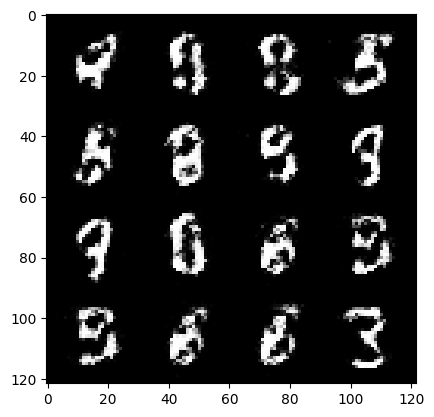

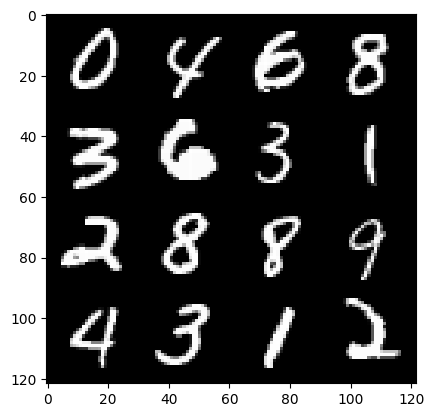

 78%|███████▊  | 365/469 [00:05<00:01, 62.96it/s]

88: step 43800 / Gen loss: 3.536847462654113 / disc_loss: 0.14923206120729435


 38%|███▊      | 176/469 [00:02<00:03, 74.60it/s]

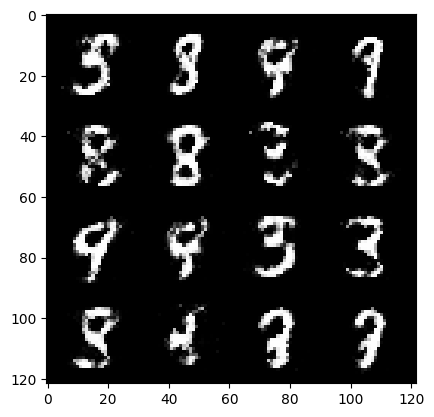

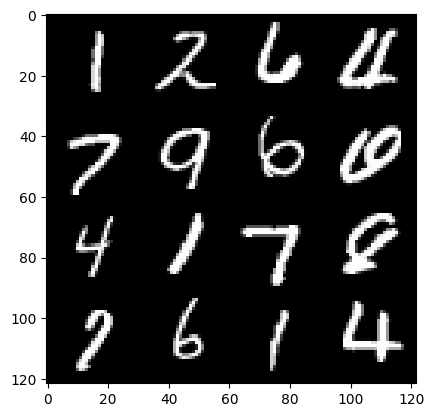

 41%|████      | 191/469 [00:02<00:04, 63.22it/s]

89: step 44100 / Gen loss: 3.3913721768061342 / disc_loss: 0.1553224336355925


  2%|▏         | 8/469 [00:00<00:06, 73.62it/s]

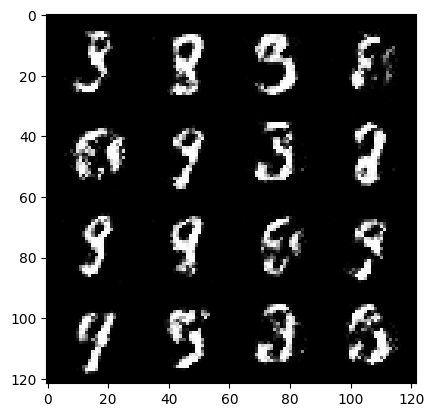

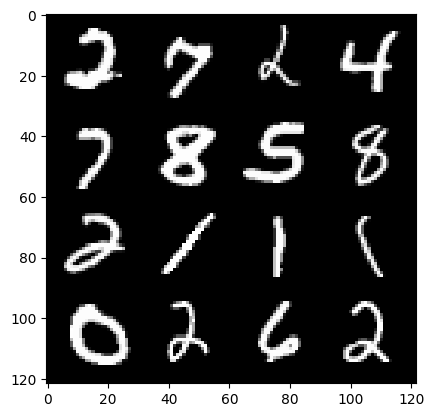

  5%|▌         | 24/469 [00:00<00:07, 59.69it/s]

90: step 44400 / Gen loss: 3.341995811462402 / disc_loss: 0.15853139164547125


 67%|██████▋   | 313/469 [00:04<00:02, 68.06it/s]

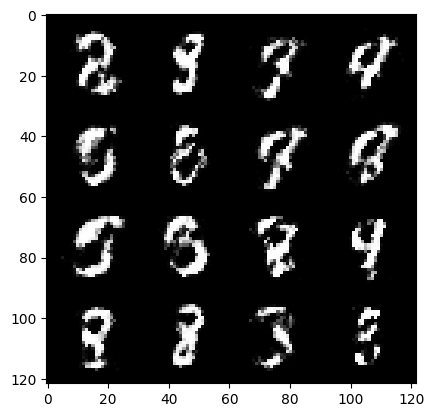

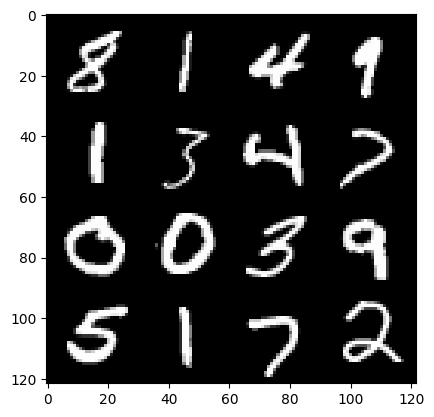

 70%|██████▉   | 327/469 [00:04<00:02, 59.71it/s]

90: step 44700 / Gen loss: 3.4468238600095127 / disc_loss: 0.15634562795360876


 31%|███       | 144/469 [00:01<00:04, 74.35it/s]

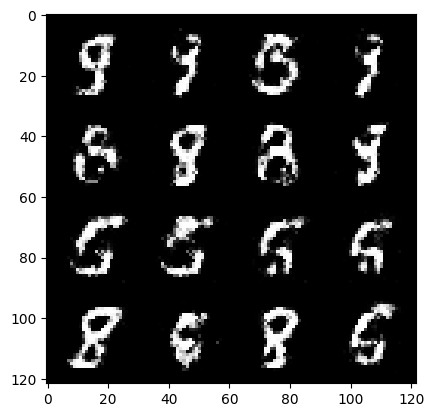

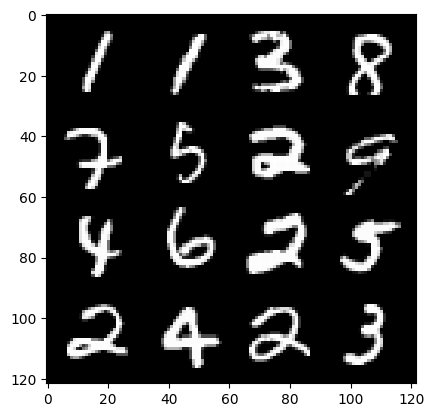

 32%|███▏      | 152/469 [00:02<00:05, 61.01it/s]

91: step 45000 / Gen loss: 3.5257393360137943 / disc_loss: 0.1409261525919041


 94%|█████████▎| 439/469 [00:06<00:00, 65.27it/s]

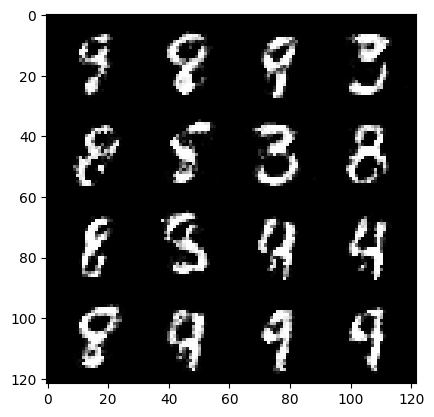

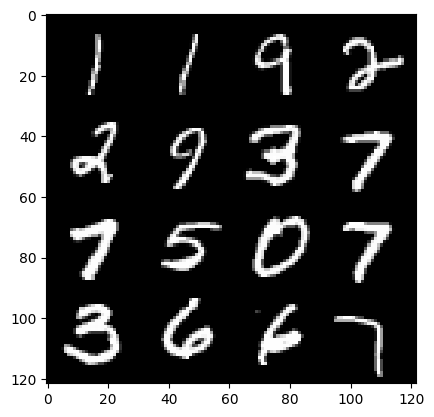

 97%|█████████▋| 453/469 [00:06<00:00, 55.65it/s]

91: step 45300 / Gen loss: 3.2084689164161677 / disc_loss: 0.17670393715302146


 58%|█████▊    | 270/469 [00:03<00:02, 70.92it/s]

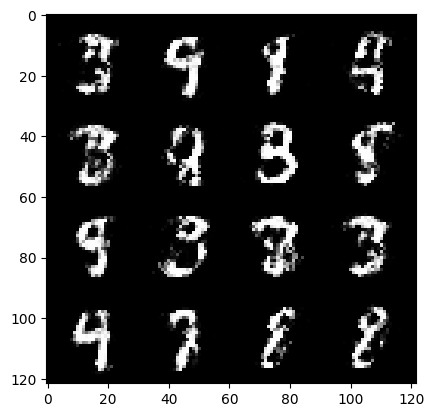

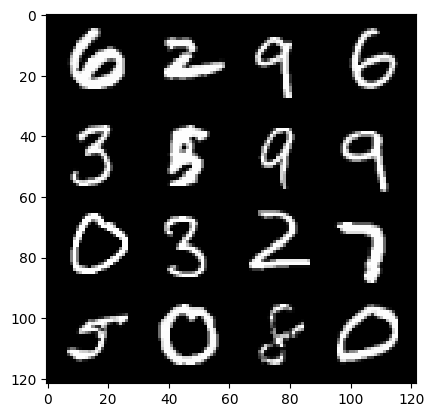

 61%|██████    | 285/469 [00:04<00:03, 61.32it/s]

92: step 45600 / Gen loss: 3.243068732420604 / disc_loss: 0.17555754465361417


 22%|██▏       | 104/469 [00:01<00:04, 73.58it/s]

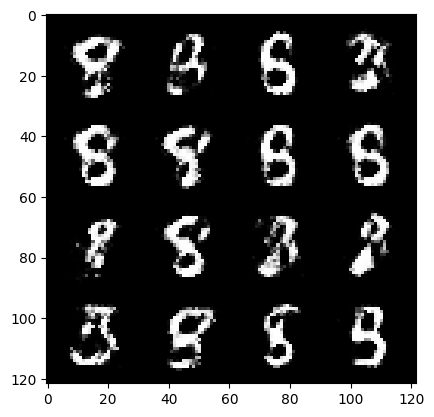

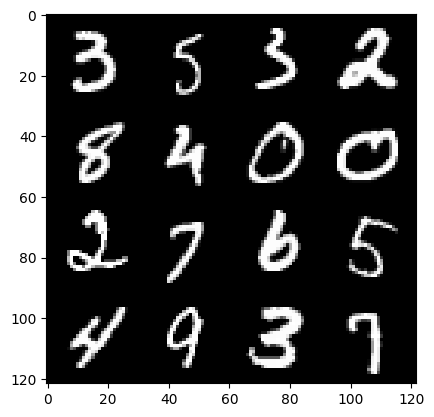

 25%|██▌       | 119/469 [00:01<00:05, 60.06it/s]

93: step 45900 / Gen loss: 3.1475761747360242 / disc_loss: 0.19816416837275017


 86%|████████▌ | 403/469 [00:05<00:00, 67.78it/s]

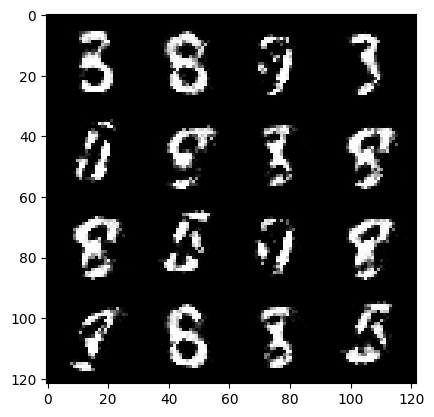

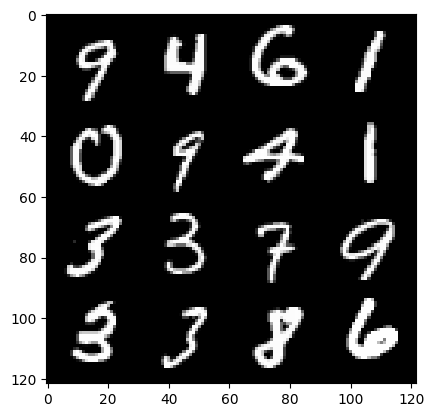

 89%|████████▉ | 417/469 [00:06<00:00, 56.42it/s]

93: step 46200 / Gen loss: 3.1223791917165116 / disc_loss: 0.17569321617484077


 50%|█████     | 236/469 [00:03<00:03, 71.53it/s]

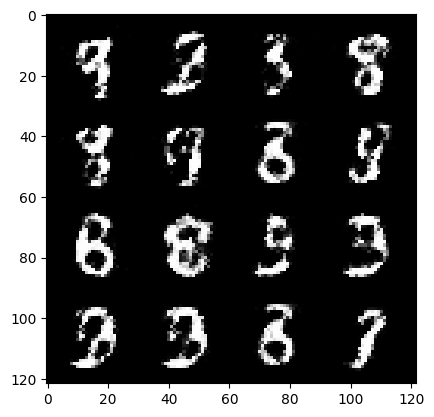

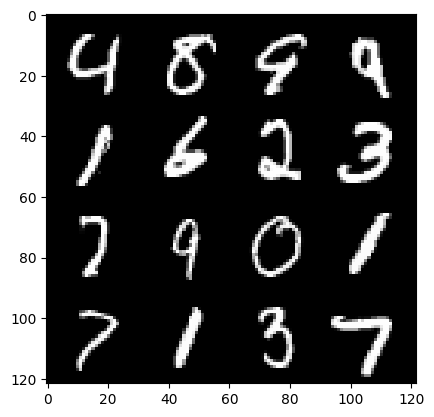

 54%|█████▎    | 251/469 [00:03<00:03, 60.08it/s]

94: step 46500 / Gen loss: 3.313093546231588 / disc_loss: 0.15723573207855224


 14%|█▎        | 64/469 [00:00<00:05, 73.95it/s]

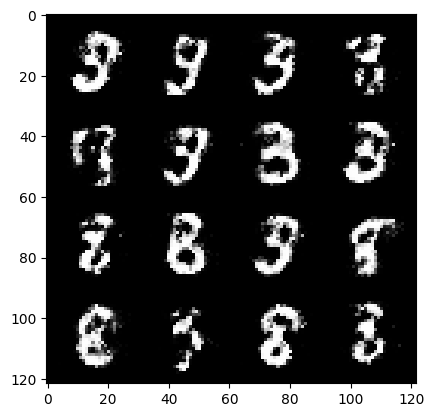

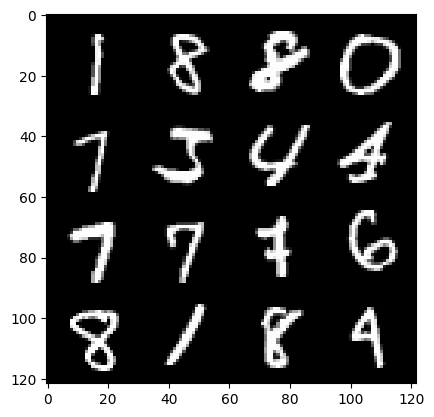

 17%|█▋        | 80/469 [00:01<00:06, 63.66it/s]

95: step 46800 / Gen loss: 3.2971789590517684 / disc_loss: 0.1677548072983822


 78%|███████▊  | 367/469 [00:05<00:01, 74.17it/s]

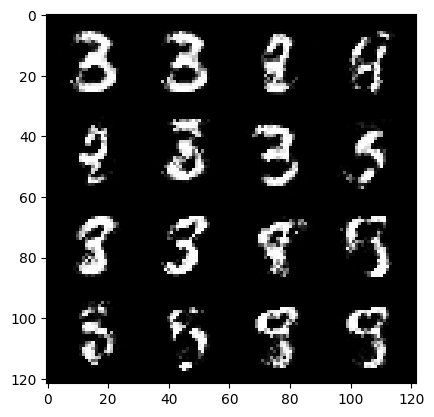

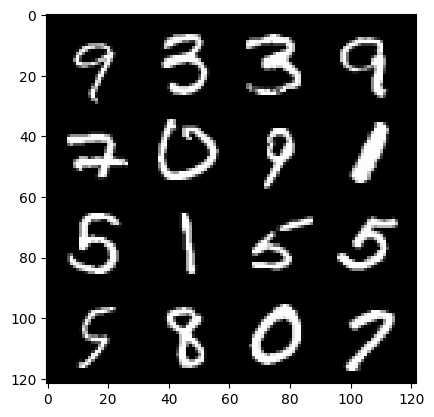

 80%|███████▉  | 375/469 [00:05<00:01, 60.00it/s]

95: step 47100 / Gen loss: 3.146524679660797 / disc_loss: 0.18865211832026646


 42%|████▏     | 198/469 [00:02<00:03, 72.72it/s]

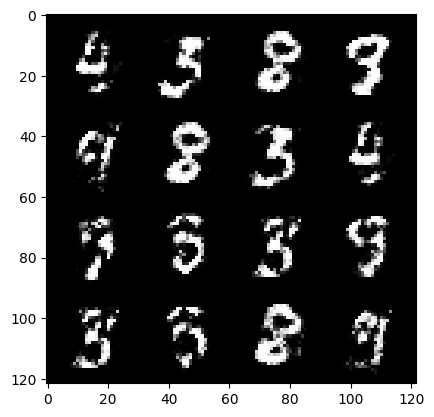

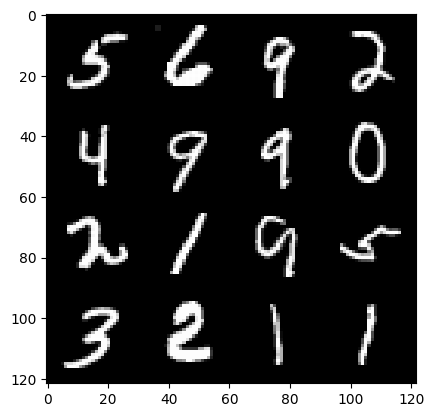

 45%|████▌     | 213/469 [00:03<00:04, 61.17it/s]

96: step 47400 / Gen loss: 3.1573812468846625 / disc_loss: 0.1714181413253148


  6%|▌         | 27/469 [00:00<00:07, 58.29it/s]

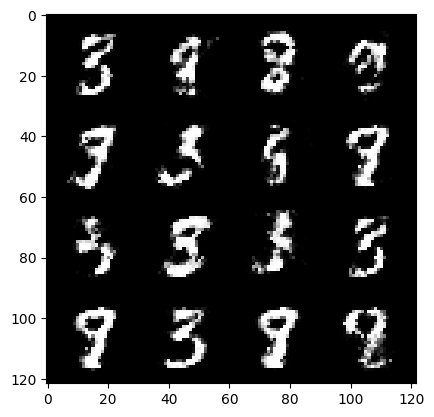

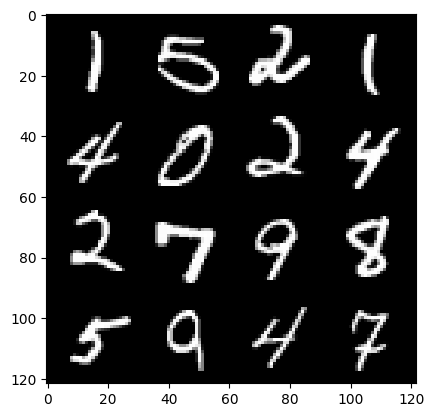

  8%|▊         | 39/469 [00:00<00:08, 48.80it/s]

97: step 47700 / Gen loss: 3.121707754929863 / disc_loss: 0.1822972044348718


 69%|██████▉   | 325/469 [00:04<00:01, 72.63it/s]

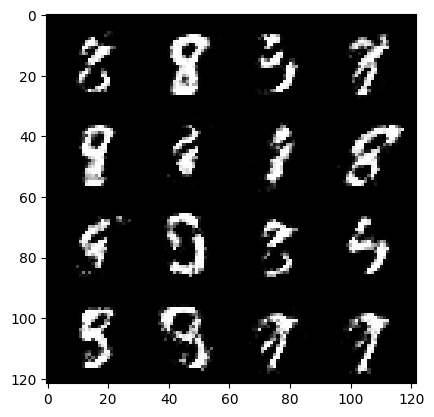

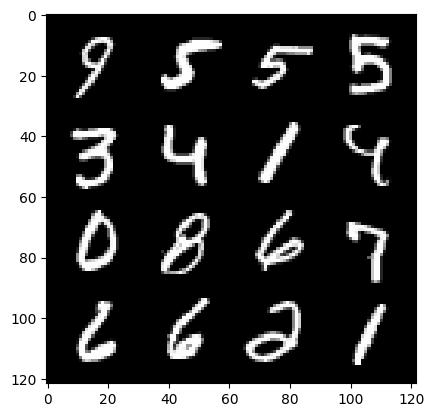

 72%|███████▏  | 340/469 [00:05<00:02, 62.55it/s]

97: step 48000 / Gen loss: 3.2570535413424153 / disc_loss: 0.15756494036565225


 33%|███▎      | 157/469 [00:02<00:04, 64.67it/s]

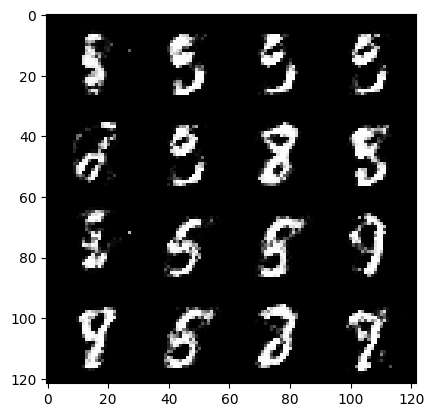

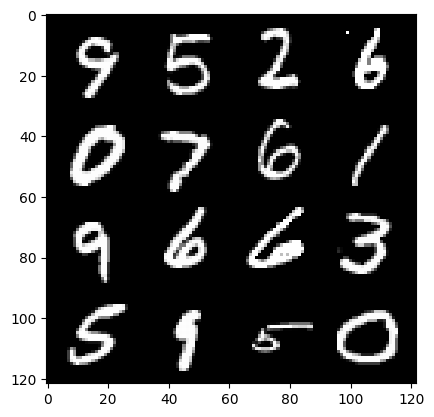

 36%|███▋      | 171/469 [00:02<00:05, 51.69it/s]

98: step 48300 / Gen loss: 3.204879887104032 / disc_loss: 0.1645836535841227


 98%|█████████▊| 458/469 [00:06<00:00, 72.84it/s]

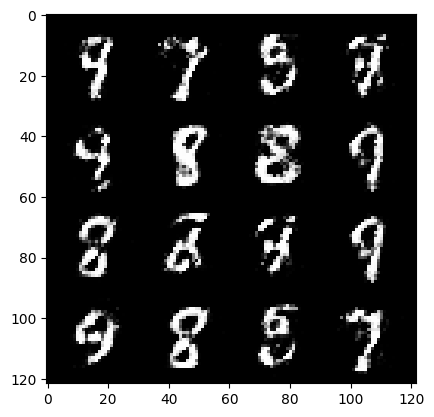

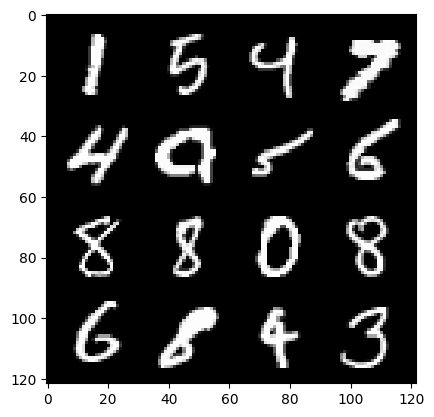

100%|██████████| 469/469 [00:06<00:00, 67.94it/s]


98: step 48600 / Gen loss: 3.066030969619754 / disc_loss: 0.17088459325333438


 61%|██████▏   | 288/469 [00:03<00:02, 73.84it/s]

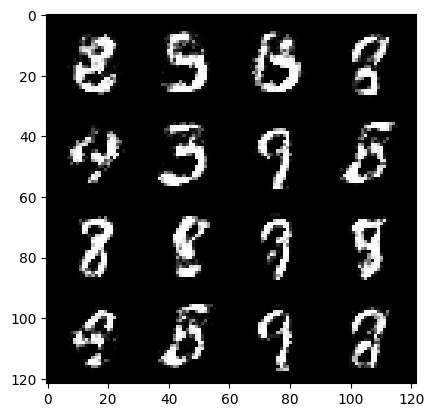

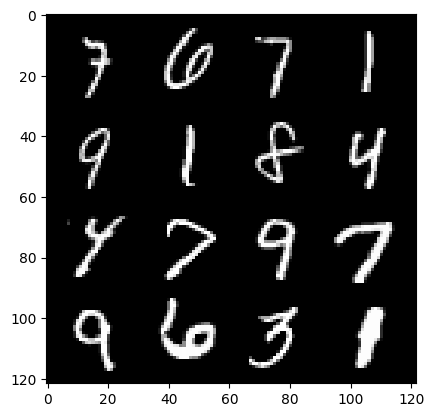

 65%|██████▍   | 304/469 [00:04<00:02, 63.04it/s]

99: step 48900 / Gen loss: 3.1469343566894556 / disc_loss: 0.16894261695444585


 26%|██▌       | 120/469 [00:01<00:04, 73.43it/s]

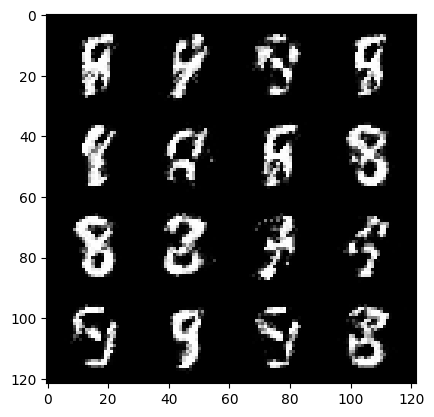

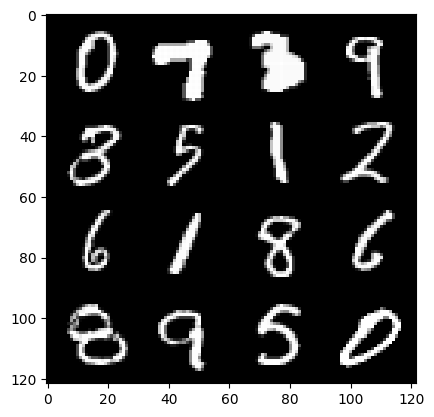

 29%|██▉       | 136/469 [00:01<00:05, 63.31it/s]

100: step 49200 / Gen loss: 3.1275052889188104 / disc_loss: 0.17991736029585206


 90%|████████▉ | 422/469 [00:05<00:00, 74.79it/s]

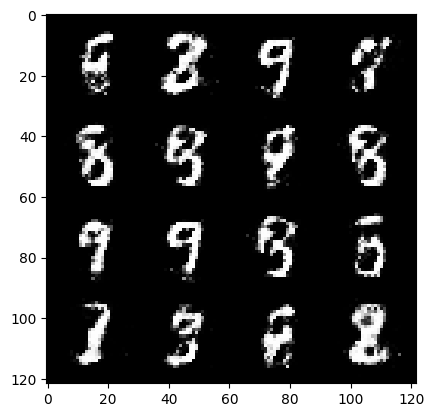

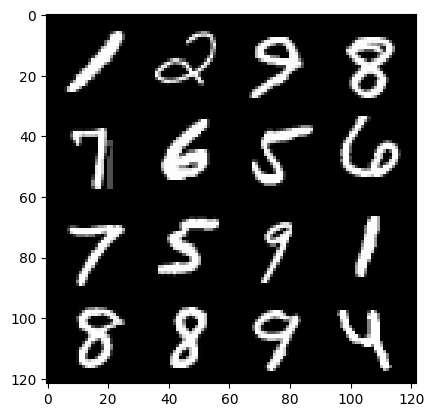

 93%|█████████▎| 438/469 [00:06<00:00, 64.46it/s]

100: step 49500 / Gen loss: 3.0774663782119753 / disc_loss: 0.1798513858517011


 53%|█████▎    | 248/469 [00:03<00:02, 75.03it/s]

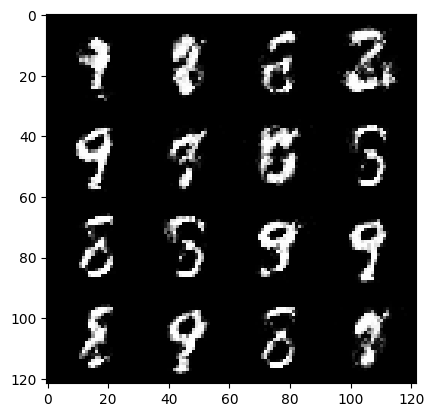

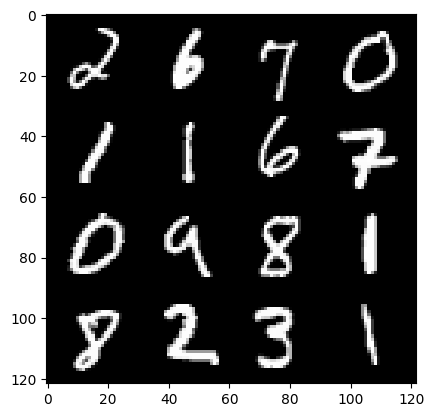

 56%|█████▌    | 263/469 [00:03<00:03, 63.34it/s]

101: step 49800 / Gen loss: 3.0008729457855225 / disc_loss: 0.19319890732566522


 17%|█▋        | 80/469 [00:01<00:05, 73.78it/s]

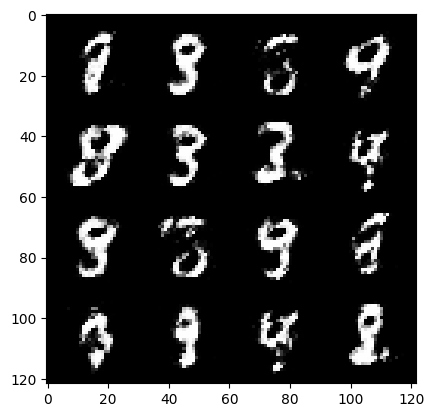

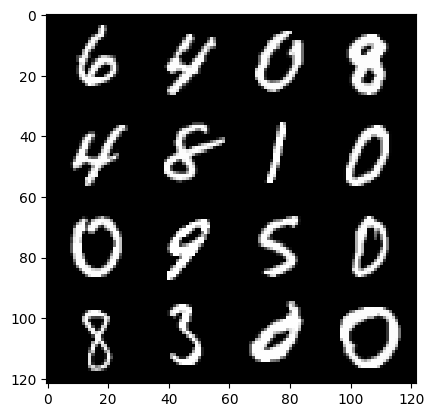

 20%|██        | 96/469 [00:01<00:05, 63.55it/s]

102: step 50100 / Gen loss: 2.9655108324686683 / disc_loss: 0.1906550707419713


 81%|████████▏ | 382/469 [00:05<00:01, 74.47it/s]

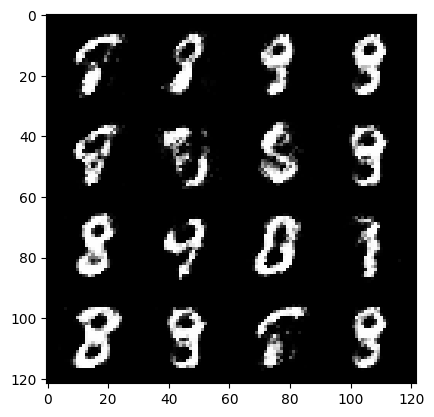

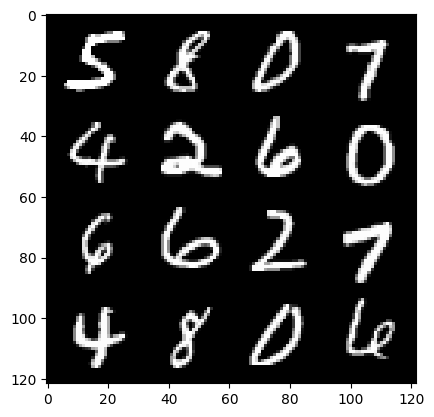

 85%|████████▍ | 397/469 [00:05<00:01, 62.08it/s]

102: step 50400 / Gen loss: 2.803207657734554 / disc_loss: 0.22658218945066147


 46%|████▌     | 216/469 [00:02<00:03, 75.06it/s]

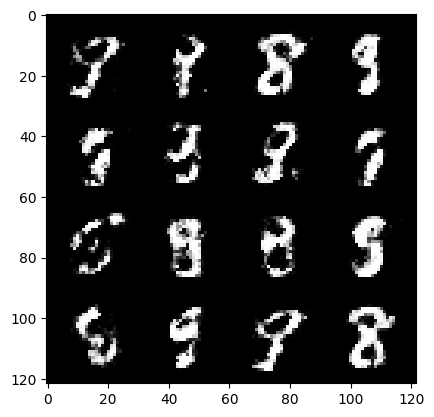

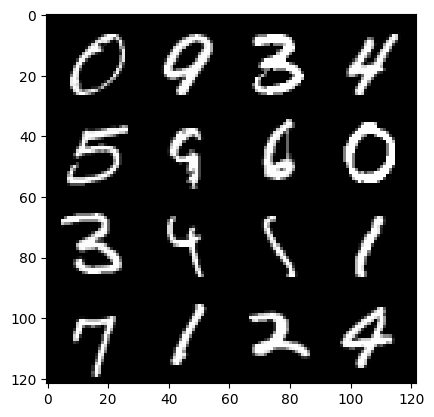

 48%|████▊     | 224/469 [00:03<00:03, 61.28it/s]

103: step 50700 / Gen loss: 2.7869745635986316 / disc_loss: 0.23411151245236397


  9%|▊         | 40/469 [00:00<00:05, 75.22it/s]

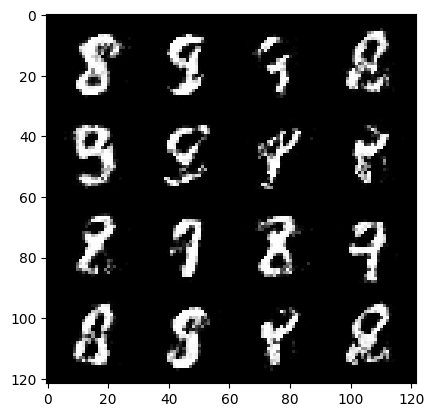

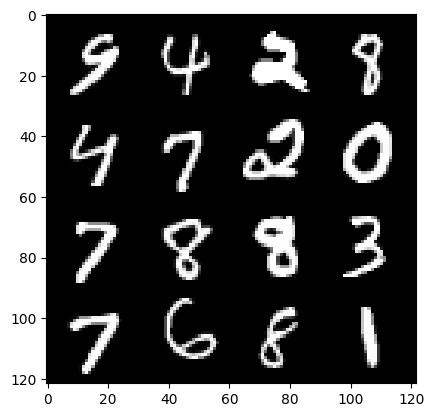

 12%|█▏        | 55/469 [00:00<00:06, 63.21it/s]

104: step 51000 / Gen loss: 2.930688750743866 / disc_loss: 0.20863258458673947


 73%|███████▎  | 342/469 [00:04<00:01, 70.40it/s]

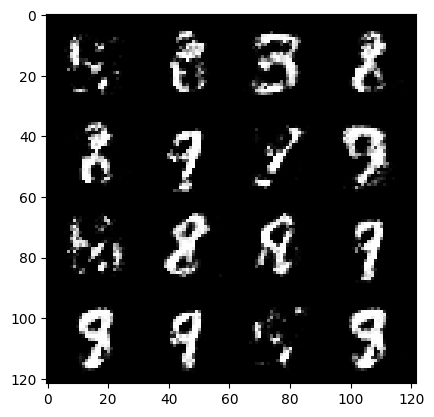

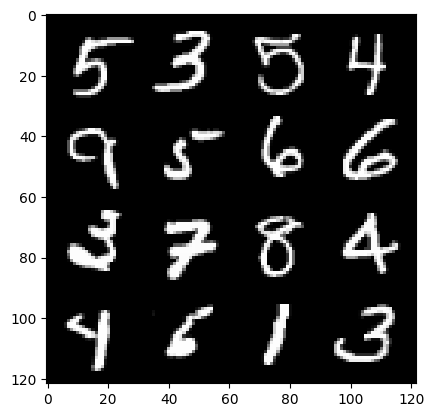

 76%|███████▋  | 358/469 [00:05<00:01, 61.61it/s]

104: step 51300 / Gen loss: 3.016923271814982 / disc_loss: 0.2036013258496921


 38%|███▊      | 176/469 [00:02<00:03, 74.02it/s]

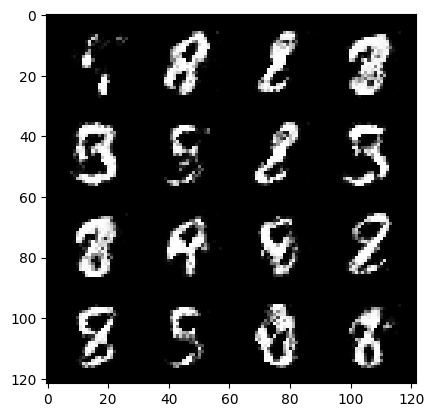

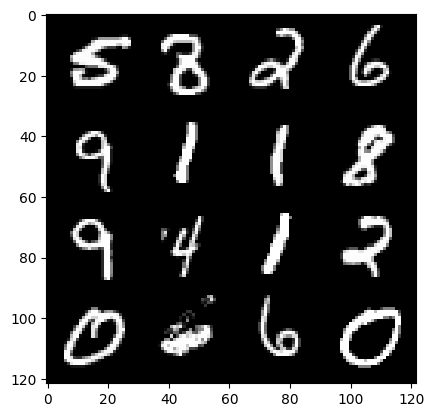

 41%|████      | 192/469 [00:02<00:04, 63.13it/s]

105: step 51600 / Gen loss: 2.810857770442964 / disc_loss: 0.20706242615977916


  1%|▏         | 7/469 [00:00<00:06, 66.20it/s]

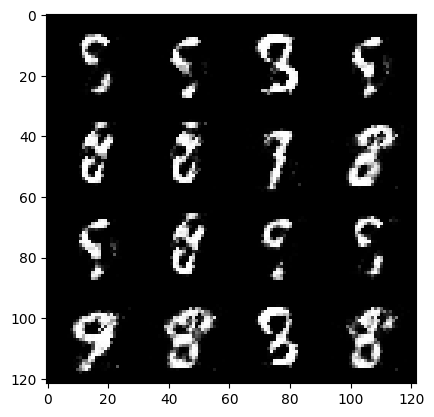

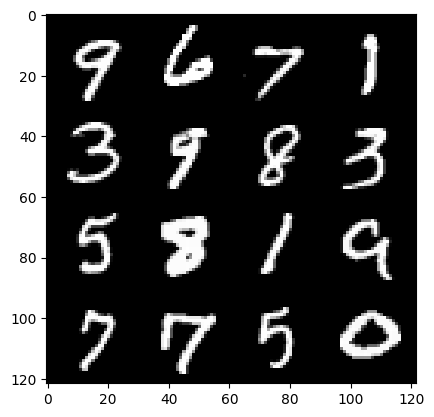

  4%|▍         | 21/469 [00:00<00:08, 55.14it/s]

106: step 51900 / Gen loss: 2.8062261255582204 / disc_loss: 0.20456813884278138


 65%|██████▌   | 306/469 [00:04<00:02, 64.77it/s]

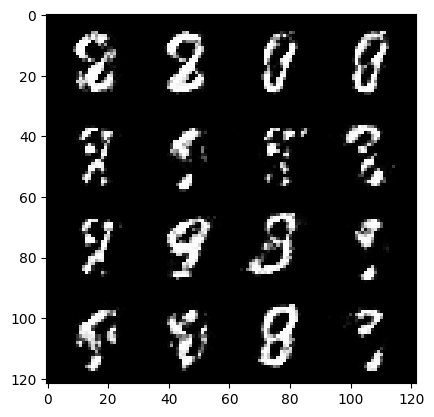

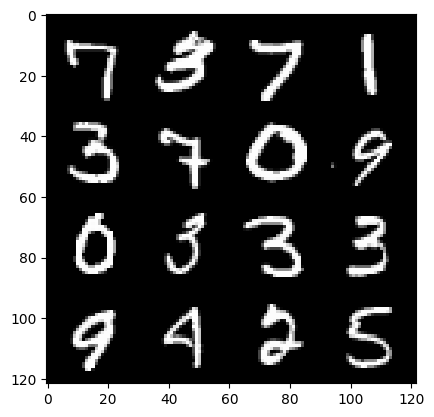

 68%|██████▊   | 320/469 [00:04<00:02, 56.28it/s]

106: step 52200 / Gen loss: 2.829175273577371 / disc_loss: 0.20577767834067345


 28%|██▊       | 133/469 [00:01<00:04, 69.39it/s]

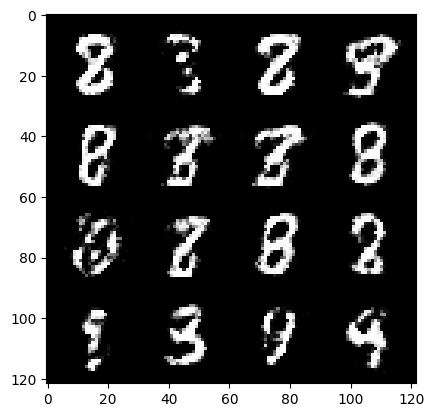

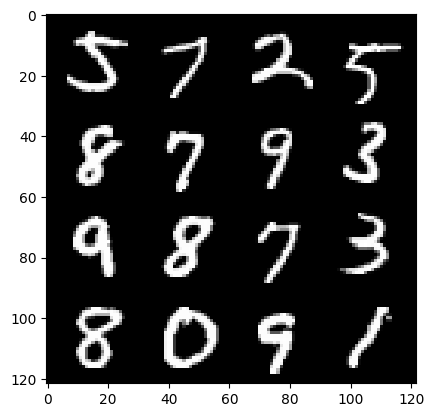

 32%|███▏      | 148/469 [00:02<00:05, 59.29it/s]

107: step 52500 / Gen loss: 2.959712768395742 / disc_loss: 0.18902322418987752


 93%|█████████▎| 436/469 [00:06<00:00, 74.27it/s]

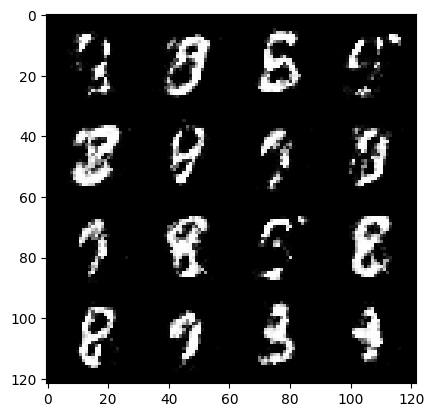

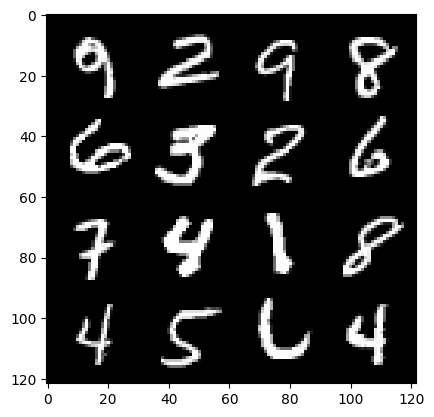

 96%|█████████▋| 452/469 [00:06<00:00, 63.31it/s]

107: step 52800 / Gen loss: 2.838062511285145 / disc_loss: 0.21388153180480007


 57%|█████▋    | 269/469 [00:03<00:02, 66.85it/s]

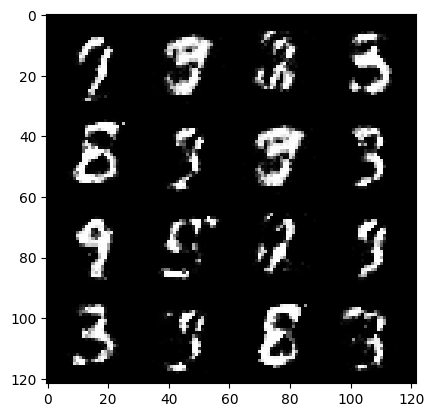

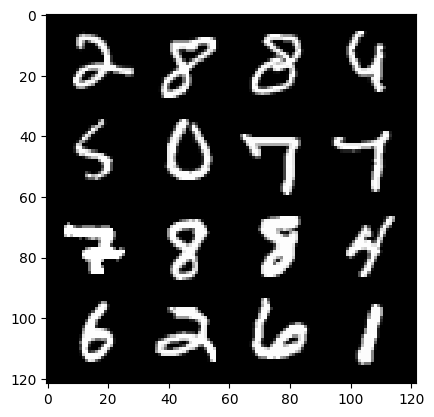

 60%|██████    | 282/469 [00:04<00:03, 52.85it/s]

108: step 53100 / Gen loss: 2.6228457887967433 / disc_loss: 0.24367274358868607


 22%|██▏       | 102/469 [00:01<00:05, 72.47it/s]

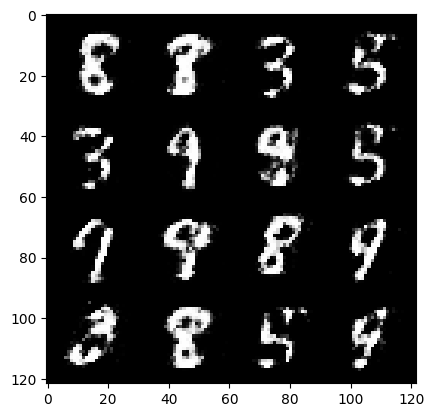

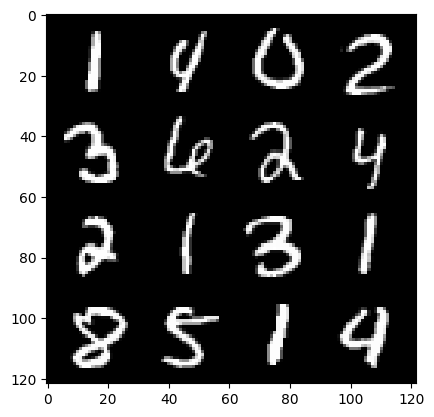

 23%|██▎       | 110/469 [00:01<00:06, 59.38it/s]

109: step 53400 / Gen loss: 2.7772248943646747 / disc_loss: 0.21236019114653276


 86%|████████▌ | 401/469 [00:05<00:01, 66.63it/s]

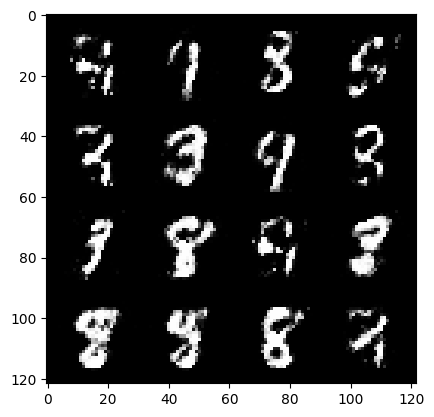

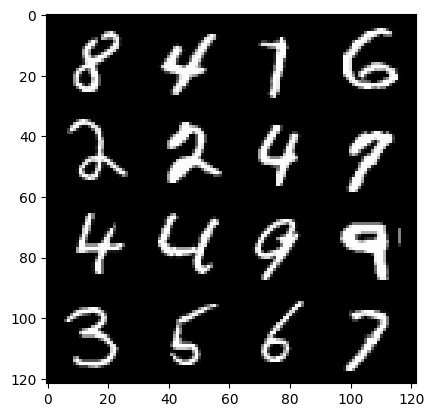

 88%|████████▊ | 415/469 [00:06<00:00, 58.97it/s]

109: step 53700 / Gen loss: 2.8767736800511687 / disc_loss: 0.19185487382113936


 49%|████▉     | 232/469 [00:03<00:03, 70.24it/s]

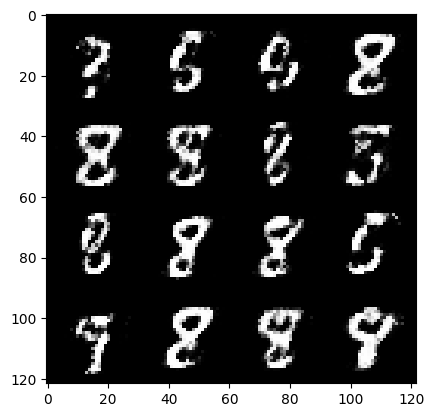

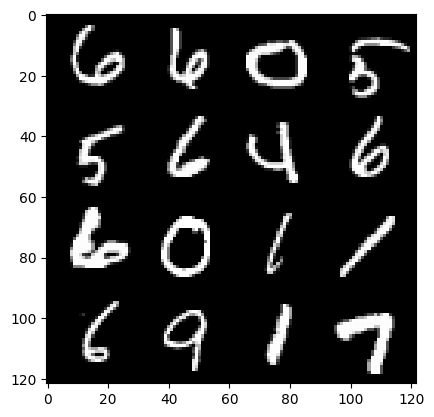

 53%|█████▎    | 247/469 [00:03<00:03, 59.18it/s]

110: step 54000 / Gen loss: 2.785082782506943 / disc_loss: 0.20953831888735275


 14%|█▎        | 64/469 [00:00<00:05, 75.65it/s]

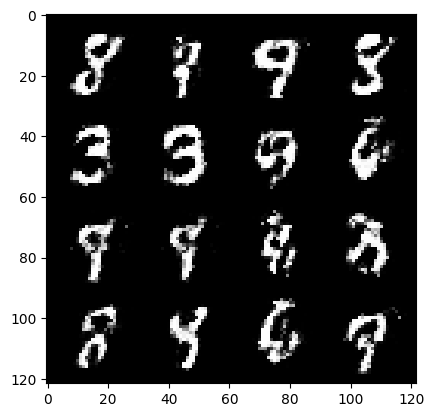

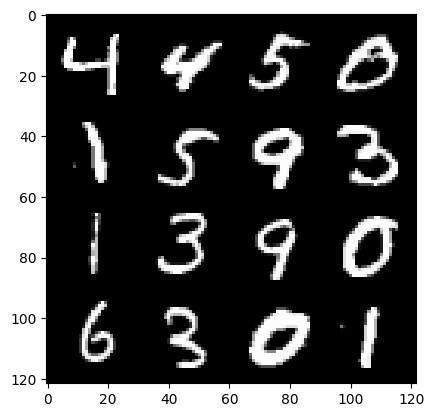

 15%|█▌        | 72/469 [00:01<00:06, 60.85it/s]

111: step 54300 / Gen loss: 2.6959489727020256 / disc_loss: 0.23413711500664566


 78%|███████▊  | 364/469 [00:05<00:01, 73.51it/s]

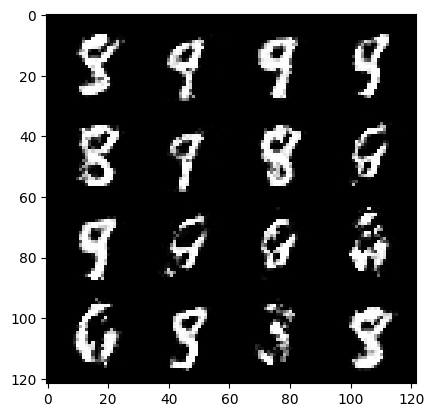

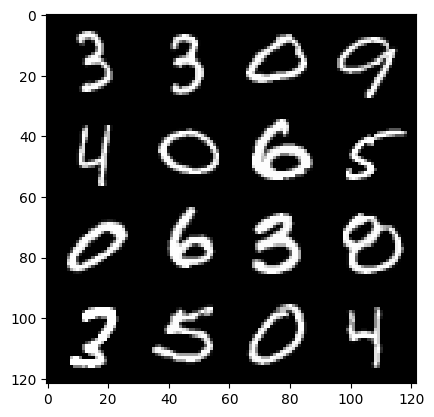

 79%|███████▉  | 372/469 [00:05<00:01, 60.38it/s]

111: step 54600 / Gen loss: 2.7815841197967544 / disc_loss: 0.20700161335368952


 41%|████      | 193/469 [00:02<00:03, 72.31it/s]

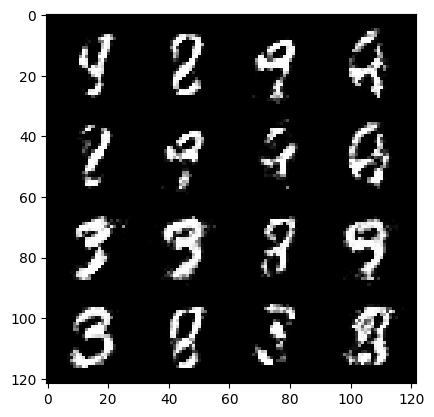

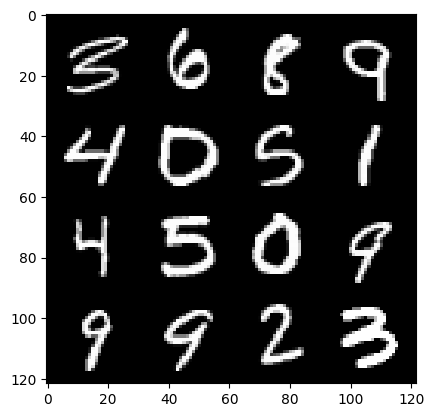

 44%|████▍     | 208/469 [00:03<00:04, 61.27it/s]

112: step 54900 / Gen loss: 2.7532893101374323 / disc_loss: 0.204660262465477


 58%|█████▊    | 271/469 [00:04<00:02, 67.73it/s]


KeyboardInterrupt: 

In [30]:
### 60000 images / 128 images = 469 steps in each epoch
### each step is going to process 128 images. (last step, little bit less)

for epoch in range(epochs):
  for real, _ in tqdm(dataloader):
    ### discriminator
    disc_optimizer.zero_grad()
    cur_bs = len(real) # real: 128 * 1 * 28 * 28
    real = real.view(cur_bs, -1) # 128 * 784
    real = real.to(device)
    disc_loss = calc_disc_loss(loss_func=loss_func, gen=gen, disc=disc, bs=cur_bs, real=real, z_dim=z_dim) # calculate the loss. we pass the real image to the discrimnator. 
    disc_loss.backward(retain_graph=True) # do the differentation and calculate the gradient.
    disc_optimizer.step() # reduce the weights.

    ### generator
    gen_optimizer.zero_grad()
    gen_loss = calc_gen_loss(loss_func=loss_func, gen=gen, disc=disc, bs=cur_bs, z_dim=z_dim)
    gen_loss.backward(retain_graph=True)
    gen_optimizer.step()

    ### visualization & stats
    mean_disc_loss += disc_loss.item()/info_step
    mean_gen_loss += gen_loss.item()/info_step

    if cur_step % info_step == 0 and cur_step > 0:
      fake_noise = gen_noise(cur_bs, z_dim=z_dim)
      fake = gen(fake_noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss = 0,0
    cur_step += 1

# zero grad is used to set the amount of gradient for this loop to be 0. 
# discriminator loss is calculated by differentiating the loss function with respect to the weight. dL/d(theta). theta are the weights. differentation is calculated for the equation based on the chain rule of calculus and the loss is put into the equation. whatever the output comes is what goes into the zero grad. now zero grad is not zero grad. and the weights are adjusted based on the learning parameters. the step() function is responsible for reducing the weights.
#








In [ ]:
#